# LIBRERIAS

In [1]:
%pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [5]:
import sys
print("Kernel Python:", sys.executable)

# instala/actualiza pip y xgboost en ESTE kernel
!{sys.executable} -m pip install -U pip
!{sys.executable} -m pip install -U xgboost

# verifica
!{sys.executable} -m pip show xgboost

Kernel Python: c:\Users\USUARIO\anaconda3\python.exe
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.8/72.0 MB 11.4 MB/s eta 0:00:07
    --------------------------------------- 1.6/72.0 MB 5.2 MB/s eta 0:00:14
   - -------------------------------------- 2.6/72.0 MB 5.2 MB/s eta 0:00:14
   -- ------------------------------------- 4.2/72.0 MB 6.0 MB/s eta 0:00:12
   --- ------------------------------------ 5.8/72.0 MB 6.2 MB/s eta 0:00:11
   --- ------------------------------------ 6.6/72.0 MB 5.8 MB/s eta 0:00:12
   --- ------------------------------------ 7.1/72.0 MB 5.3 MB/s eta 0:00:13
   ---- ----------------------------------- 7.6/72.0 MB 4.8 MB/s eta 0:00:14
   ---- ----------------------------------- 8.4/72.0 MB 4.8 MB/s eta 0:00:14
   ----- ---------------------------------- 9.7/72.0 MB 5.0 MB/s eta 0:00:13
   ----- ---------------------------------- 10.5/72.0 MB 4.9 MB/s eta 0:00:13
   ------ ------------------

  You can safely remove it manually.


Name: xgboost
Version: 3.1.1
Summary: XGBoost Python Package
Home-page: 
Author: 
Author-email: Hyunsu Cho <chohyu01@cs.washington.edu>, Jiaming Yuan <jm.yuan@outlook.com>
License: Apache-2.0
Location: c:\Users\USUARIO\anaconda3\Lib\site-packages
Requires: numpy, scipy
Required-by: 


In [6]:
# ============================================================
# LIBRER√çAS EST√ÅNDAR DE PYTHON
# ============================================================
import importlib
import json
import math
import os
import platform
import re
import sys
import time
import unicodedata
import warnings
from datetime import datetime
from math import ceil, sqrt
from typing import List

# Alias usados en funciones del proyecto
import re as _re
import unicodedata as _ud


# ============================================================
# ENTORNO JUPYTER / INTERFAZ GR√ÅFICA
# ============================================================
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import Dropdown, HTML, HBox, Layout, Text, VBox, interact


# ============================================================
# LIBRER√çAS DE AN√ÅLISIS DE DATOS Y VISUALIZACI√ìN
# ============================================================
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns


# ============================================================
# LIBRER√çAS DE MACHINE LEARNING Y ESTAD√çSTICA
# ============================================================
from scipy.stats import spearmanr
from sklearn.base import clone
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.impute import KNNImputer
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    root_mean_squared_error,
    make_scorer,
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    cross_val_score,
    learning_curve,
    train_test_split,
)
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor


# ============================================================
# OPTIMIZACI√ìN Y EXPLICABILIDAD DE MODELOS
# ============================================================
import optuna
from optuna.samplers import TPESampler
import shap


# ============================================================
# UTILIDADES Y APLICACIONES
# ============================================================
import joblib
import streamlit as st


# ============================================================
# M√ìDULOS LOCALES
# ============================================================
# Si 'diccionario.py' no est√° en el mismo directorio, a√±ade su ruta:
# sys.path.append("ruta/a/tu/modulo")  # Ejemplo: "utils"
import diccionario
importlib.reload(diccionario)


<module 'diccionario' from 'c:\\Users\\USUARIO\\Desktop\\RIO CAUCA\\diccionario.py'>

DICCIONARIO

In [7]:
importlib.reload(diccionario)  # por si qued√≥ en cach√©

print('¬øEst√° diccionario_variables?:', hasattr(diccionario, 'diccionario_variables'))
print([n for n in dir(diccionario) if not n.startswith('_')][:20])

¬øEst√° diccionario_variables?: True
['cargar_diccionario', 'diccionario_variables', 'math', 'pd', 're', 'reglas_por_parametro']


In [8]:
importlib.reload(diccionario)
len(diccionario.diccionario_variables), len(diccionario.reglas_por_parametro)


(53, 53)

In [9]:
# Visor de diccionario (Excel)

# parseo de rangos con inclusividad
def _parse_bands(cell: str):
    """
    Devuelve lista de dicts con l√≠mites e inclusividad.
    Soporta: 'a - b' (ambos inclusivos), '> a', '‚â• a', '< a', '‚â§ a'.
    Ej:
      '121 - 180' -> {'lo':121,'hi':180,'lo_inc':True,'hi_inc':True}
      '> 180'     -> {'lo':180,'hi':+inf,'lo_inc':False,'hi_inc':False}
      '‚â§ 50'      -> {'lo':-inf,'hi':50,'lo_inc':False,'hi_inc':True}
    """
    if not isinstance(cell, str):
        return []
    t = cell.strip().lower()
    if "no aplica" in t or "var√≠a" in t or "varia" in t:
        return []

    out = []
    for part in re.split(r"[;,/]| o ", t):
        s = part.strip()
        if not s:
            continue

        # a - b  (interpretar como inclusivo en ambos extremos)
        m = re.match(r"^\s*(-?\d+(?:\.\d+)?)\s*[-‚Äì]\s*(-?\d+(?:\.\d+)?)\s*$", s)
        if m:
            a, b = float(m.group(1)), float(m.group(2))
            if b < a:
                a, b = b, a
            out.append(dict(lo=a, hi=b, lo_inc=True, hi_inc=True))
            continue

        # ‚â• a  /  > a
        m = re.match(r"^\s*(‚â•|>)\s*(-?\d+(?:\.\d+)?)\s*$", s)
        if m:
            op, a = m.group(1), float(m.group(2))
            out.append(dict(lo=a, hi=math.inf, lo_inc=(op == "‚â•"), hi_inc=False))
            continue

        # ‚â§ a  /  < a
        m = re.match(r"^\s*(‚â§|<)\s*(-?\d+(?:\.\d+)?)\s*$", s)
        if m:
            op, a = m.group(1), float(m.group(2))
            out.append(dict(lo=-math.inf, hi=a, lo_inc=False, hi_inc=(op == "‚â§")))
            continue

    return out

def _fmt_rango(b):
    """Formatea un rango con par√©ntesis/brackets seg√∫n inclusividad."""
    li = "[" if b["lo_inc"] else "("
    ri = "]" if b["hi_inc"] else ")"
    lo = "-‚àû" if b["lo"] == -math.inf else f"{b['lo']:g}"
    hi = "+‚àû" if b["hi"] ==  math.inf else f"{b['hi']:g}"
    return f"{li}{lo}, {hi}{ri}"

# Carga del diccionario desde Excel
def cargar_diccionario(path="diccionario.xlsx", hoja="Hoja1"):
    df = pd.read_excel(path, sheet_name=hoja)

    # localizar columnas por nombre aproximado
    col_param   = [c for c in df.columns if ("par√°metro" in c.lower() or "parametro" in c.lower())][0]
    col_def     = [c for c in df.columns if ("definici√≥n" in c.lower() or "definicion" in c.lower())][0]
    col_rel     = [c for c in df.columns if ("relaci√≥n"  in c.lower() or "relacion"  in c.lower())][0]
    col_ref     = [c for c in df.columns if "referencia" in c.lower()][0]

    # columnas de color (si existen en la hoja)
    col_verde   = next((c for c in df.columns if "verde"   in c.lower()), None)
    col_amar    = next((c for c in df.columns if "amarill" in c.lower()), None)
    col_naranja = next((c for c in df.columns if "naranja" in c.lower()), None)
    col_rojo    = next((c for c in df.columns if "rojo"    in c.lower()), None)

    diccionario_variables = {}
    reglas_por_parametro  = {}

    for _, r in df.iterrows():
        nombre = str(r[col_param]).strip()
        if not nombre or nombre.lower() == "nan":
            continue

        diccionario_variables[nombre] = {
            "definicion": r.get(col_def, ""),
            "relacion_contaminacion": r.get(col_rel, ""),
            "referencia": r.get(col_ref, "")
        }

        # si hay columnas de color, parsear rangos
        if all([col_verde, col_amar, col_naranja, col_rojo]):
            reglas_por_parametro[nombre] = {
                "V": _parse_bands(str(r.get(col_verde, ""))),
                "A": _parse_bands(str(r.get(col_amar, ""))),
                "N": _parse_bands(str(r.get(col_naranja, ""))),
                "R": _parse_bands(str(r.get(col_rojo, "")))
            }

    return diccionario_variables, reglas_por_parametro

# Cargar (ajusta ruta/hoja si cambian)
diccionario_variables, reglas_por_parametro = cargar_diccionario("diccionario.xlsx", "Hoja1")

# UI
todas = sorted(diccionario_variables.keys(), key=str.casefold)
buscar   = Text(placeholder='Filtrar por nombre‚Ä¶', description='Buscar:', layout=Layout(width='50%'))
selector = Dropdown(options=todas, description='Variable:', layout=Layout(width='70%'))

definicion  = HTML()
relacion    = HTML()
referencia  = HTML()
rangos_html = HTML()

def render():
    var  = selector.value
    info = diccionario_variables.get(var, {})

    definicion.value = f"<b>Definici√≥n</b><br>{info.get('definicion', '(sin definici√≥n)')}"
    relacion.value   = f"<b>Relaci√≥n con la contaminaci√≥n</b><br>{info.get('relacion_contaminacion', '(sin informaci√≥n)')}"
    referencia.value = f"<b>Referencia</b><br>{info.get('referencia', '(sin referencia)')}"

    # rangos por color (si existen)
    r = reglas_por_parametro.get(var)
    if r:
        partes = []
        color_emoji = {"V":"üü¢", "A":"üü°", "N":"üü†", "R":"üî¥"}
        for k in ["V","A","N","R"]:
            bandas = r.get(k, [])
            if bandas:
                bandas_txt = ", ".join(_fmt_rango(b) for b in bandas)
                partes.append(f"{color_emoji[k]} <b>{k}</b>: {bandas_txt}")
        rangos_html.value = "<b>Rangos por color</b><br>" + "<br>".join(partes)
    else:
        rangos_html.value = "<b>Rangos por color</b><br>(no definidos para esta variable)"

def filtrar(_):
    q = buscar.value.strip().lower()
    opciones = [v for v in todas if q in v.lower()] or todas
    selector.options = opciones
    if selector.value not in opciones:
        selector.value = opciones[0]

buscar.observe(filtrar, names='value')
selector.observe(lambda _: render(), names='value')

# primera renderizaci√≥n y despliegue
render()
ui = VBox([
    HBox([buscar]),
    HBox([selector]),
    HTML("<hr>"),
    definicion, HTML("<br>"),
    relacion,   HTML("<br>"),
    referencia, HTML("<br>"),
    rangos_html
])
display(ui)

In [10]:
df = pd.read_csv('Calidad_del_agua_del_Rio_Cauca.csv', sep=';')

df.head()

FECHA DE MUESTREO        ESTACIONES   pH TEMPERATURA (¬∞C) COLOR (UPC)  \
0  12/19/1998 12:00:00 AM            YOTOCO  7.1              4.1         NaN   
1  12/19/1998 12:00:00 AM        MEDIACANOA    7                2         NaN   
2  12/19/1998 12:00:00 AM  PASO DE LA TORRE    7             22.9         NaN   
3          5/09/1990 0:00      ANTES SUAREZ  6.6              NaN         NaN   
4          1/10/1990 0:00  ANTES RIO OVEJAS  6.7              NaN         NaN   

  TURBIEDAD (UNT)  SOLIDOS TOTALES (mg SST/l)  \
0             4.1                         NaN   
1               2                         NaN   
2             3.4                         NaN   
3             NaN                       157.0   
4             NaN                       143.0   

  SOLIDOS SUSPENDIDOS TOTALES (mg SS/l) SOLIDOS DISUELTOS (mg SD/l)  \
0                                   110                         NaN   
1                                   130                         NaN   
2                                 153.3                         NaN   
3                                  29.3                       127.7   
4                                    65                          78   

  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)  ... CROMO TOTAL (mg Cr/l)  \
0                                     4.2  ...                   NaN   
1                                       3  ...                   NaN   
2                                       5  ...                   NaN   
3                                     0.5  ...                   NaN   
4                                     2.1  ...                   NaN   

  CROMO DISUELTO (mg Cr/l) NIQUEL TOTAL (mg Ni/l) NIQUEL DISUELTO (mg Ni/l)  \
0                      NaN                    NaN                       NaN   
1                      NaN                    NaN                       NaN   
2                      NaN                    NaN                       NaN   
3                      NaN                      0                       NaN   
4                      NaN                    NaN                       NaN   

  PLOMO TOTAL (mg Pb/l) PLOMO DISUELTO (mg Pb/l) MERCURIO (¬µg Hg/l)  \
0                   NaN                      NaN                NaN   
1                   NaN                      NaN                NaN   
2                   NaN                      NaN                NaN   
3                   NaN                      NaN                NaN   
4                   NaN                      NaN                NaN   

  COLIFORMES TOTALES (NMP/100 ml) COLIFORMES FECALES (NMP/100 ml)  \
0                             NaN                             NaN   
1                             NaN                             NaN   
2                             NaN                             NaN   
3                        2.4*10E4                              23   
4                        2.4*10E4                         24*10E4   

  CAUDAL (m3/s)  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN  

[5 rows x 56 columns]

In [11]:
df_sin_columnas = df.drop(columns=['FECHA DE MUESTREO', 'ESTACIONES'])
df_sin_columnas.head()

pH TEMPERATURA (¬∞C) COLOR (UPC) TURBIEDAD (UNT)  \
0  7.1              4.1         NaN             4.1   
1    7                2         NaN               2   
2    7             22.9         NaN             3.4   
3  6.6              NaN         NaN             NaN   
4  6.7              NaN         NaN             NaN   

   SOLIDOS TOTALES (mg SST/l) SOLIDOS SUSPENDIDOS TOTALES (mg SS/l)  \
0                         NaN                                   110   
1                         NaN                                   130   
2                         NaN                                 153.3   
3                       157.0                                  29.3   
4                       143.0                                    65   

  SOLIDOS DISUELTOS (mg SD/l) DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)  \
0                         NaN                                     4.2   
1                         NaN                                       3   
2                         NaN                                       5   
3                       127.7                                     0.5   
4                          78                                     2.1   

  DEMANDA QUIMICA DE OXIGENO (mg O2/l) OXIGENO DISUELTO (mg O2/l)  ...  \
0                                  NaN                        1.5  ...   
1                                  NaN                       1.81  ...   
2                                  NaN                          2  ...   
3                                  5.2                        5.6  ...   
4                                   24                          6  ...   

  CROMO TOTAL (mg Cr/l) CROMO DISUELTO (mg Cr/l) NIQUEL TOTAL (mg Ni/l)  \
0                   NaN                      NaN                    NaN   
1                   NaN                      NaN                    NaN   
2                   NaN                      NaN                    NaN   
3                   NaN                      NaN                      0   
4                   NaN                      NaN                    NaN   

  NIQUEL DISUELTO (mg Ni/l) PLOMO TOTAL (mg Pb/l) PLOMO DISUELTO (mg Pb/l)  \
0                       NaN                   NaN                      NaN   
1                       NaN                   NaN                      NaN   
2                       NaN                   NaN                      NaN   
3                       NaN                   NaN                      NaN   
4                       NaN                   NaN                      NaN   

  MERCURIO (¬µg Hg/l) COLIFORMES TOTALES (NMP/100 ml)  \
0                NaN                             NaN   
1                NaN                             NaN   
2                NaN                             NaN   
3                NaN                        2.4*10E4   
4                NaN                        2.4*10E4   

  COLIFORMES FECALES (NMP/100 ml)  CAUDAL (m3/s)  
0                             NaN            NaN  
1                             NaN            NaN  
2                             NaN            NaN  
3                              23            NaN  
4                         24*10E4            NaN  

[5 rows x 54 columns]

# EDA

In [12]:
# Copiar el dataframe
df_eda = df_sin_columnas.copy()

# Convertir todas las columnas a n√∫meros, reemplazando la coma decimal
for columna in df_eda.columns:
    df_eda[columna] = pd.to_numeric(
        df_eda[columna].astype(str).str.replace(',', '.'), 
        errors='coerce'
    )

# Eliminar columnas que est√©n completamente vac√≠as
df_eda.dropna(axis='columns', how='all', inplace=True)

# Confirmar que los datos est√°n limpios (sin nulos y con tipos num√©ricos)
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2254 entries, 0 to 2253
Data columns (total 39 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   pH                                       2208 non-null   float64
 1   TEMPERATURA (¬∞C)                         1956 non-null   float64
 2   COLOR (UPC)                              1882 non-null   float64
 3   TURBIEDAD (UNT)                          2090 non-null   float64
 4   SOLIDOS TOTALES (mg SST/l)               2194 non-null   float64
 5   SOLIDOS SUSPENDIDOS TOTALES (mg SS/l)    2188 non-null   float64
 6   SOLIDOS DISUELTOS (mg SD/l)              2190 non-null   float64
 7   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)  2092 non-null   float64
 8   DEMANDA QUIMICA DE OXIGENO (mg O2/l)     2066 non-null   float64
 9   OXIGENO DISUELTO (mg O2/l)               2179 non-null   float64
 10  DUREZA TOTAL (mg CaCO3/l)                2167 n

In [13]:
# Empezar con las estad√≠sticas base de .describe() y transponer la tabla
estadisticas_df = df_eda.describe().T

# Calcular y a√±adir las estad√≠sticas adicionales que solicitaste
estadisticas_df['Tipo de dato'] = df_eda.dtypes
estadisticas_df['IQR'] = estadisticas_df['75%'] - estadisticas_df['25%']
# .mad() est√° obsoleto, la forma moderna es (df - df.mean()).abs().mean()
estadisticas_df['MAD'] = (df_eda - df_eda.mean()).abs().mean()
estadisticas_df['CV'] = estadisticas_df['std'] / estadisticas_df['mean']
estadisticas_df['Skewness'] = df_eda.skew()
estadisticas_df['Kurtosis'] = df_eda.kurtosis()
n = len(df_eda)
estadisticas_df['SE.Skewness'] = np.sqrt((6 * n * (n - 1)) / ((n - 2) * (n + 1) * (n + 3)))
estadisticas_df['Pct.Valid'] = (estadisticas_df['count'] / n) * 100

# Renombrar las columnas para que coincidan con tu lista
estadisticas_df.rename(columns={
    'count': 'N.Valid',
    'mean': 'Mean',
    'std': 'Std.Dev',
    'min': 'Min',
    '25%': 'Q1',
    '50%': 'Median',
    '75%': 'Q3',
    'max': 'Max'
}, inplace=True)

# Seleccionar y ordenar las columnas para el informe final
columnas_finales = [
    'Tipo de dato', 'N.Valid', 'Pct.Valid', 'Mean', 'Std.Dev', 'Min', 
    'Q1', 'Median', 'Q3', 'Max', 'IQR', 'MAD', 'CV', 
    'Skewness', 'SE.Skewness', 'Kurtosis'
]
estadisticas_completas = estadisticas_df[columnas_finales]

# Formatear: 2 decimales; si es entero, sin decimales (no afecta "Tipo de dato")
def _fmt(x):
    if pd.isna(x):
        return ""
    if isinstance(x, (int, np.integer)):
        return f"{x}"
    if isinstance(x, (float, np.floating)):
        return f"{int(x)}" if float(x).is_integer() else f"{x:.2f}"
    return x  # deja textos/objetos tal cual

estadisticas_completas_fmt = estadisticas_completas.copy()
cols_numericas = [c for c in estadisticas_completas_fmt.columns if c != 'Tipo de dato']
for c in cols_numericas:
    estadisticas_completas_fmt[c] = estadisticas_completas_fmt[c].map(_fmt)

# Mostrar la tabla de estad√≠sticas completas
estadisticas_completas_fmt

Tipo de dato N.Valid Pct.Valid  \
pH                                           float64    2208     97.96   
TEMPERATURA (¬∞C)                             float64    1956     86.78   
COLOR (UPC)                                  float64    1882     83.50   
TURBIEDAD (UNT)                              float64    2090     92.72   
SOLIDOS TOTALES (mg SST/l)                   float64    2194     97.34   
SOLIDOS SUSPENDIDOS TOTALES (mg SS/l)        float64    2188     97.07   
SOLIDOS DISUELTOS (mg SD/l)                  float64    2190     97.16   
DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)      float64    2092     92.81   
DEMANDA QUIMICA DE OXIGENO (mg O2/l)         float64    2066     91.66   
OXIGENO DISUELTO (mg O2/l)                   float64    2179     96.67   
DUREZA TOTAL (mg CaCO3/l)                    float64    2167     96.14   
DUREZA CALCICA (mg CaCO3/l)                  float64    2166     96.10   
DUREZA MAGNESICA (mg CaCO3/l)                float64    2167     96.14   
CALCIO (mg Ca/l)                             float64    2166     96.10   
MAGNESIO (mg Mg/l)                           float64    2167     96.14   
ALCALINIDAD TOTAL (mg CaCO3/l)               float64    2159     95.79   
BICARBONATOS (mg CaCO3/l)                    float64    2158     95.74   
CONDUCTIVIDAD EL√âCTRICA (¬µS/cm)              float64    2196     97.43   
HIERRO TOTAL (mg Fe/l)                       float64    2062     91.48   
MANGANESO TOTAL (mg Mn/l)                    float64    1594     70.72   
SODIO TOTAL (mg Na/l)                        float64    1945     86.29   
POTASIO TOTAL (mg K/l)                       float64    1984     88.02   
COBRE TOTAL (mg Cu/l)                        float64     537     23.82   
ZINC TOTAL (mg Zn/l)                         float64    1039     46.10   
NITROGENO TOTAL (mg N/l)                     float64    1322     58.65   
NITROGENO AMONIACAL (mg N-NH3/l)             float64    1288     57.14   
NITRITOS (mg N-NO2/l)                        float64    1943     86.20   
NITRATOS (mg N-NO3/l)                        float64    1958     86.87   
CLORUROS (mg Cl/l)                           float64    2083     92.41   
FOSFORO TOTAL (mg P/l)                       float64    1797     79.72   
FOSFATOS (mg PO4/l)                          float64    1113     49.38   
SULFATOS (mg SO4/l)                          float64    1932     85.71   
CADMIO TOTAL (mg Cd/l)                       float64     100      4.44   
CROMO TOTAL (mg Cr/l)                        float64     195      8.65   
NIQUEL TOTAL (mg Ni/l)                       float64     206      9.14   
PLOMO TOTAL (mg Pb/l)                        float64     172      7.63   
COLIFORMES TOTALES (NMP/100 ml)              float64    1814     80.48   
COLIFORMES FECALES (NMP/100 ml)              float64    1870     82.96   
CAUDAL (m3/s)                                float64     222      9.85   

                                                      Mean  \
pH                                                    7.04   
TEMPERATURA (¬∞C)                                     22.02   
COLOR (UPC)                                         135.45   
TURBIEDAD (UNT)                                     130.73   
SOLIDOS TOTALES (mg SST/l)                          275.19   
SOLIDOS SUSPENDIDOS TOTALES (mg SS/l)               165.20   
SOLIDOS DISUELTOS (mg SD/l)                         117.51   
DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)               5.22   
DEMANDA QUIMICA DE OXIGENO (mg O2/l)                 29.89   
OXIGENO DISUELTO (mg O2/l)                            4.10   
DUREZA TOTAL (mg CaCO3/l)                            49.35   
DUREZA CALCICA (mg CaCO3/l)                          27.37   
DUREZA MAGNESICA (mg CaCO3/l)                        23.81   
CALCIO (mg Ca/l)                                     11.89   
MAGNESIO (mg Mg/l)                                    6.32   
ALCALINIDAD TOTAL (mg CaCO3/l)                       37.53   
BICARBONATOS (mg CaCO

In [14]:
print(f"Columnas evaluadas: {df_eda.shape[1]}")

Columnas evaluadas: 39


In [15]:
# Definir umbral
umbral = 80

# Filtrar variables con Pct.Valid < 80
vars_baja_completitud = estadisticas_completas[estadisticas_completas['Pct.Valid'] < umbral]

print(f"Variables con menos del {umbral}% de datos v√°lidos: {len(vars_baja_completitud)}\n")
display(vars_baja_completitud[['Pct.Valid', 'N.Valid', 'Tipo de dato']])

Variables con menos del 80% de datos v√°lidos: 12



Pct.Valid  N.Valid Tipo de dato
MANGANESO TOTAL (mg Mn/l)         70.718722   1594.0      float64
COBRE TOTAL (mg Cu/l)             23.824312    537.0      float64
ZINC TOTAL (mg Zn/l)              46.095830   1039.0      float64
NITROGENO TOTAL (mg N/l)          58.651287   1322.0      float64
NITROGENO AMONIACAL (mg N-NH3/l)  57.142857   1288.0      float64
FOSFORO TOTAL (mg P/l)            79.724933   1797.0      float64
FOSFATOS (mg PO4/l)               49.378882   1113.0      float64
CADMIO TOTAL (mg Cd/l)             4.436557    100.0      float64
CROMO TOTAL (mg Cr/l)              8.651287    195.0      float64
NIQUEL TOTAL (mg Ni/l)             9.139308    206.0      float64
PLOMO TOTAL (mg Pb/l)              7.630878    172.0      float64
CAUDAL (m3/s)                      9.849157    222.0      float64

In [16]:
# Columnas que cumplen el umbral
columnas_mantener = estadisticas_completas[estadisticas_completas['Pct.Valid'] >= umbral].index.tolist()

print(f"Columnas que cumplen el {umbral}% de datos v√°lidos ({len(columnas_mantener)}):")
print(columnas_mantener)

# Crear un nuevo DataFrame solo con esas columnas
df_filtrado = df_eda[columnas_mantener]

Columnas que cumplen el 80% de datos v√°lidos (27):
['pH', 'TEMPERATURA (¬∞C)', 'COLOR (UPC)', 'TURBIEDAD (UNT)', 'SOLIDOS TOTALES (mg SST/l)', 'SOLIDOS SUSPENDIDOS TOTALES (mg SS/l)', 'SOLIDOS DISUELTOS (mg SD/l)', 'DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)', 'DEMANDA QUIMICA DE OXIGENO (mg O2/l)', 'OXIGENO DISUELTO (mg O2/l)', 'DUREZA TOTAL (mg CaCO3/l)', 'DUREZA CALCICA (mg CaCO3/l)', 'DUREZA MAGNESICA (mg CaCO3/l)', 'CALCIO (mg Ca/l)', 'MAGNESIO (mg Mg/l)', 'ALCALINIDAD TOTAL (mg CaCO3/l)', 'BICARBONATOS (mg CaCO3/l)', 'CONDUCTIVIDAD EL√âCTRICA (¬µS/cm)', 'HIERRO TOTAL (mg Fe/l)', 'SODIO TOTAL (mg Na/l)', 'POTASIO TOTAL (mg K/l)', 'NITRITOS (mg N-NO2/l)', 'NITRATOS (mg N-NO3/l)', 'CLORUROS (mg Cl/l)', 'SULFATOS (mg SO4/l)', 'COLIFORMES TOTALES (NMP/100 ml)', 'COLIFORMES FECALES (NMP/100 ml)']


# VARIABLES OBJETIVO

In [17]:
# --- Variables objetivo sin cruzar con diccionario ---

def _canon(s: str) -> str:
    if s is None:
        return ""
    s = str(s)
    # normaliza acentos y s√≠mbolos raros
    s = _ud.normalize("NFKD", s).encode("ascii", "ignore").decode("ascii")
    s = s.lower().strip()
    # homogeneiza separadores y espacios
    s = s.replace("¬µ", "u").replace("¬∫", "")
    s = s.replace("/", " ").replace("-", " ")
    s = s.replace("%", " ").replace("¬∞", " ")
    s = _re.sub(r"\s+", " ", s)
    return s

# 1) Crear mapa canon -> original solo para df_filtrado
df_cols_map = { _canon(c): c for c in df_filtrado.columns }

# 2) Mostrar informaci√≥n
print(f"Total de variables post-umbral en df_filtrado: {len(df_cols_map)}\n")
print("Variables disponibles en df_filtrado:")
for k in df_cols_map.values():
    print(" -", k)

Total de variables post-umbral en df_filtrado: 27

Variables disponibles en df_filtrado:
 - pH
 - TEMPERATURA (¬∞C)
 - COLOR (UPC)
 - TURBIEDAD (UNT)
 - SOLIDOS TOTALES (mg SST/l)
 - SOLIDOS SUSPENDIDOS TOTALES (mg SS/l)
 - SOLIDOS DISUELTOS (mg SD/l)
 - DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)
 - DEMANDA QUIMICA DE OXIGENO (mg O2/l)
 - OXIGENO DISUELTO (mg O2/l)
 - DUREZA TOTAL (mg CaCO3/l)
 - DUREZA CALCICA (mg CaCO3/l)
 - DUREZA MAGNESICA (mg CaCO3/l)
 - CALCIO (mg Ca/l)
 - MAGNESIO (mg Mg/l)
 - ALCALINIDAD TOTAL (mg CaCO3/l)
 - BICARBONATOS (mg CaCO3/l)
 - CONDUCTIVIDAD EL√âCTRICA (¬µS/cm)
 - HIERRO TOTAL (mg Fe/l)
 - SODIO TOTAL (mg Na/l)
 - POTASIO TOTAL (mg K/l)
 - NITRITOS (mg N-NO2/l)
 - NITRATOS (mg N-NO3/l)
 - CLORUROS (mg Cl/l)
 - SULFATOS (mg SO4/l)
 - COLIFORMES TOTALES (NMP/100 ml)
 - COLIFORMES FECALES (NMP/100 ml)


In [18]:
df_base = df_filtrado.drop(columns=['FECHA DE MUESTREO', 'ESTACIONES'], errors='ignore').copy()
df_base.head()

pH  TEMPERATURA (¬∞C)  COLOR (UPC)  TURBIEDAD (UNT)  \
0  7.1               4.1          NaN              4.1   
1  7.0               2.0          NaN              2.0   
2  7.0              22.9          NaN              3.4   
3  6.6               NaN          NaN              NaN   
4  6.7               NaN          NaN              NaN   

   SOLIDOS TOTALES (mg SST/l)  SOLIDOS SUSPENDIDOS TOTALES (mg SS/l)  \
0                         NaN                                  110.0   
1                         NaN                                  130.0   
2                         NaN                                  153.3   
3                       157.0                                   29.3   
4                       143.0                                   65.0   

   SOLIDOS DISUELTOS (mg SD/l)  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)  \
0                          NaN                                      4.2   
1                          NaN                                      3.0   
2                          NaN                                      5.0   
3                        127.7                                      0.5   
4                         78.0                                      2.1   

   DEMANDA QUIMICA DE OXIGENO (mg O2/l)  OXIGENO DISUELTO (mg O2/l)  ...  \
0                                   NaN                        1.50  ...   
1                                   NaN                        1.81  ...   
2                                   NaN                        2.00  ...   
3                                   5.2                        5.60  ...   
4                                  24.0                        6.00  ...   

   CONDUCTIVIDAD EL√âCTRICA (¬µS/cm)  HIERRO TOTAL (mg Fe/l)  \
0                            103.0                     NaN   
1                            103.0                     NaN   
2                            110.0                     NaN   
3                             73.9                    2.65   
4                             67.9                    3.07   

   SODIO TOTAL (mg Na/l)  POTASIO TOTAL (mg K/l)  NITRITOS (mg N-NO2/l)  \
0                    NaN                     NaN                    NaN   
1                    NaN                     NaN                    NaN   
2                    NaN                     NaN                    NaN   
3                   4.66                    1.14                 0.0030   
4                   3.95                    1.16                 0.0018   

   NITRATOS (mg N-NO3/l)  CLORUROS (mg Cl/l)  SULFATOS (mg SO4/l)  \
0                    NaN                3.08                  NaN   
1                    NaN                3.02                  NaN   
2                    NaN                3.59                  NaN   
3                   0.06                5.00                 19.0   
4                   0.03                6.00                 18.0   

   COLIFORMES TOTALES (NMP/100 ml)  COLIFORMES FECALES (NMP/100 ml)  
0                              NaN                              NaN  
1                              NaN                              NaN  
2                              NaN                              NaN  
3                              NaN                             23.0  
4                              NaN                              NaN  

[5 rows x 27 columns]

In [19]:
df_filtrado.columns

print(f"Variables disponibles en el filtro ({len(df_filtrado.columns)}):")

objetivos = ['DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)', 'pH']

Variables disponibles en el filtro (27):


In [20]:
objetivos: List[str]

In [21]:
def get_X_y_para(objetivos: str):
    assert objetivos in df_base.columns, f"{objetivos} no est√° en df_base."

    # y (sin NaN)
    y = df_base[objetivos].dropna()

    # X = todo menos objetivo, alineado a y
    X = df_base.drop(columns=objetivos).loc[y.index]

    # Solo columnas num√©ricas
    X = X.select_dtypes(include='number').copy()

    # Limpieza b√°sica
    X = X.replace([np.inf, -np.inf], np.nan).dropna(axis=1, how='all')

    # Quitar columnas constantes
    const = X.nunique(dropna=True) <= 1
    if const.any():
        X = X.loc[:, ~const]

    # Seguridad de alineaci√≥n
    X, y = X.align(y, join='inner', axis=0)

    return X, y

# USO
if 'objetivos' in globals():
    print("Objetivos seleccionados:", objetivos)
    for obj in objetivos:
        X_obj, y_obj = get_X_y_para(obj)
        print(f"{obj} -> X: {X_obj.shape}, y: {y_obj.shape}")
else:
    print("A√∫n no has confirmado los objetivos con el selector.")

Objetivos seleccionados: ['DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)', 'pH']
DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) -> X: (2092, 26), y: (2092,)
pH -> X: (2208, 26), y: (2208,)


# Fase 2. An√°lisis Exploratorio y Selecci√≥n de Variables

# IMPUTACI√ìN KNN

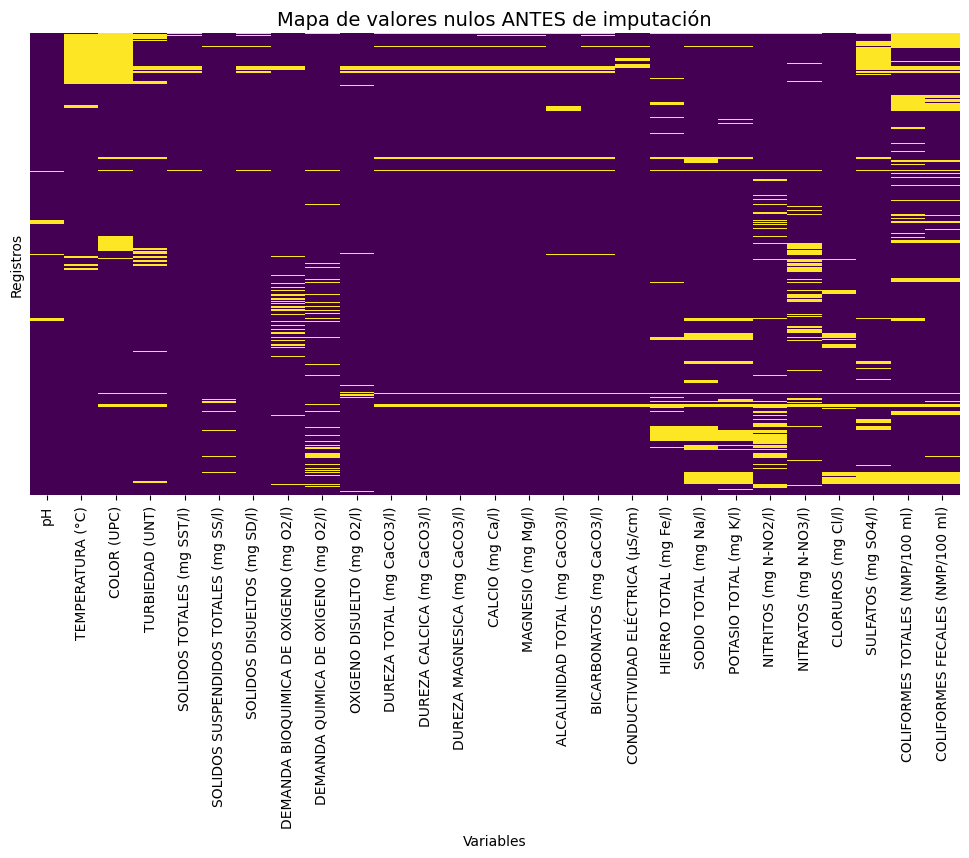

In [22]:
# --- An√°lisis de valores nulos ANTES de imputaci√≥n ---

# 1) Conteo de nulos por variable
null_counts = df_filtrado.isnull().sum()
null_percent = (null_counts / len(df_filtrado)) * 100

# 2) Tabla resumen
tabla_nulos = pd.DataFrame({
    "Nulos": null_counts,
    "% Nulos": null_percent
}).sort_values(by="% Nulos", ascending=False)

# 3) Visualizaci√≥n gr√°fica (heatmap de nulos antes de imputaci√≥n)
plt.figure(figsize=(12, 6))
sns.heatmap(df_filtrado.isnull(), cbar=False, cmap="viridis", yticklabels=False)
plt.title("Mapa de valores nulos ANTES de imputaci√≥n", fontsize=14)
plt.xlabel("Variables")
plt.ylabel("Registros")
plt.show()

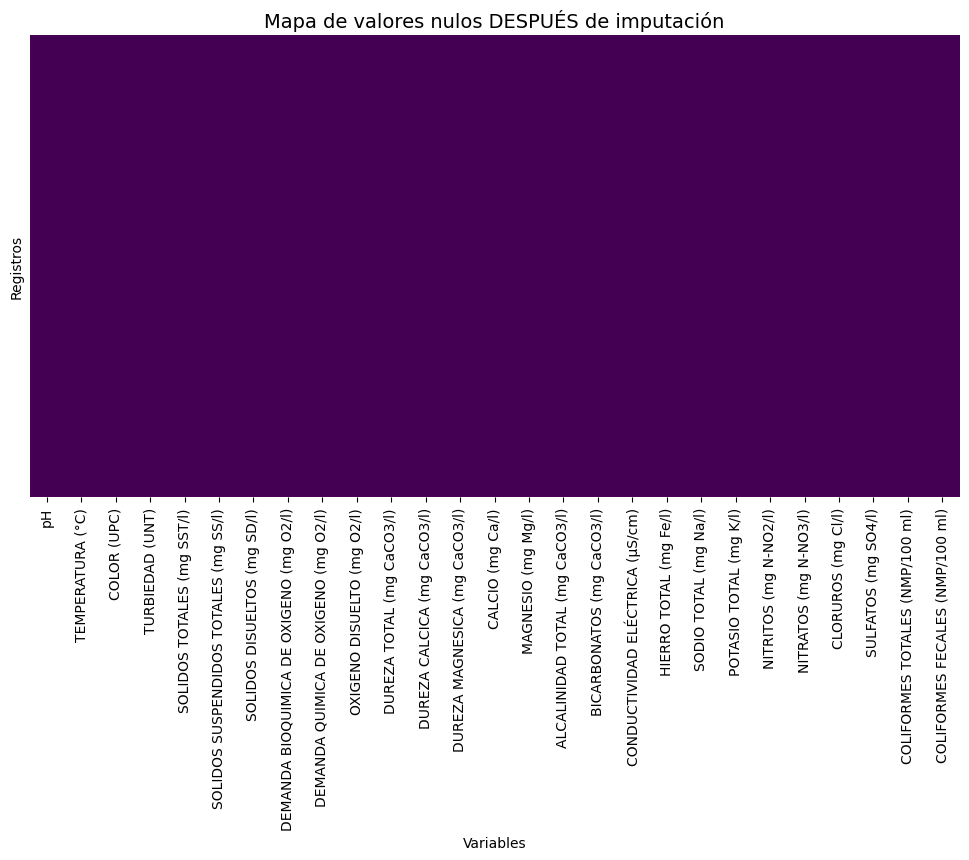

In [23]:
# 1. Escalar los datos
scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_filtrado),
    columns=df_filtrado.columns
)

# 2. Imputar con KNN
imputer = KNNImputer(n_neighbors=5, weights="distance")
df_imputed_scaled = pd.DataFrame(
    imputer.fit_transform(df_scaled),
    columns=df_scaled.columns
)

# 3. Desescalar (volver a la escala original)
df_imputed = pd.DataFrame(
    scaler.inverse_transform(df_imputed_scaled),
    columns=df_filtrado.columns
)

# 4. Visualizar el resultado (valores nulos despu√©s de imputaci√≥n)
plt.figure(figsize=(12, 6))
sns.heatmap(df_imputed.isnull(), cbar=False, cmap="viridis", yticklabels=False)
plt.title("Mapa de valores nulos DESPU√âS de imputaci√≥n", fontsize=14)
plt.xlabel("Variables")
plt.ylabel("Registros")
plt.show()

## HISTOGRAMAS

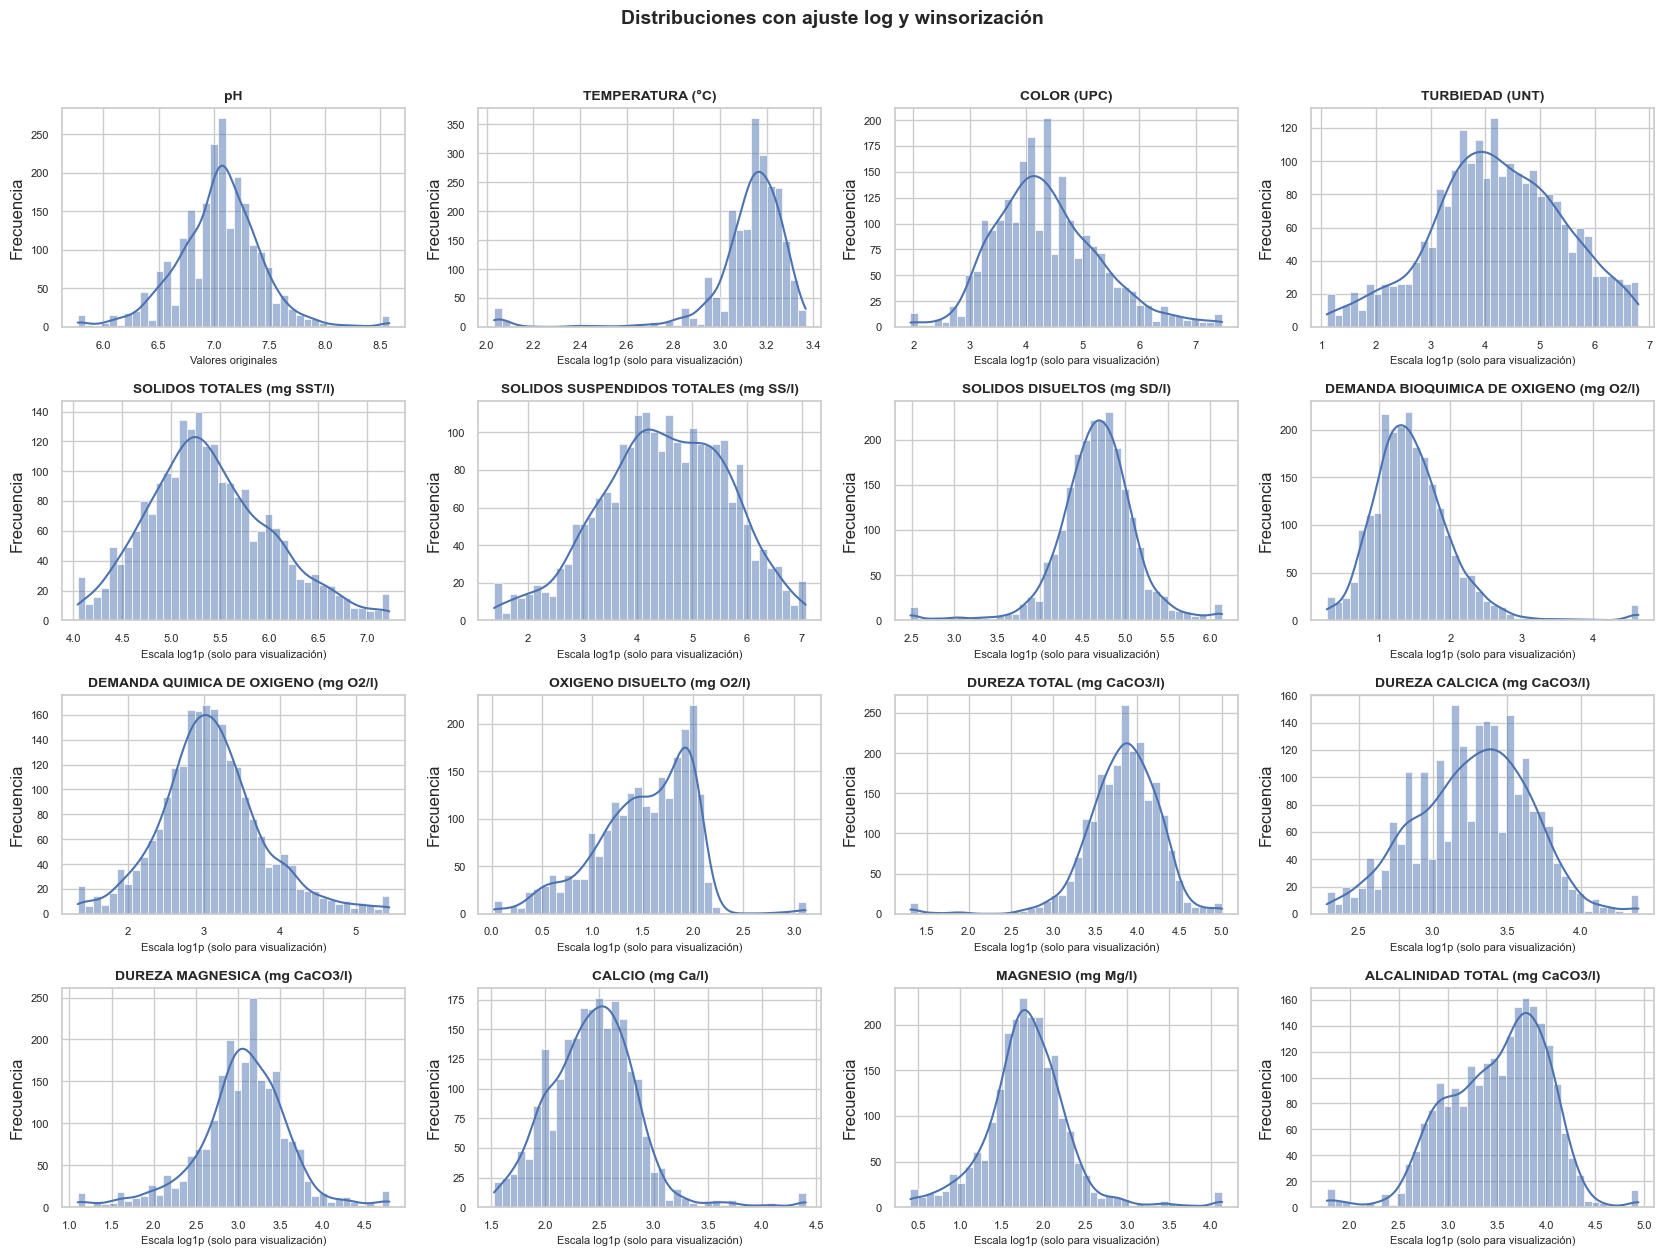

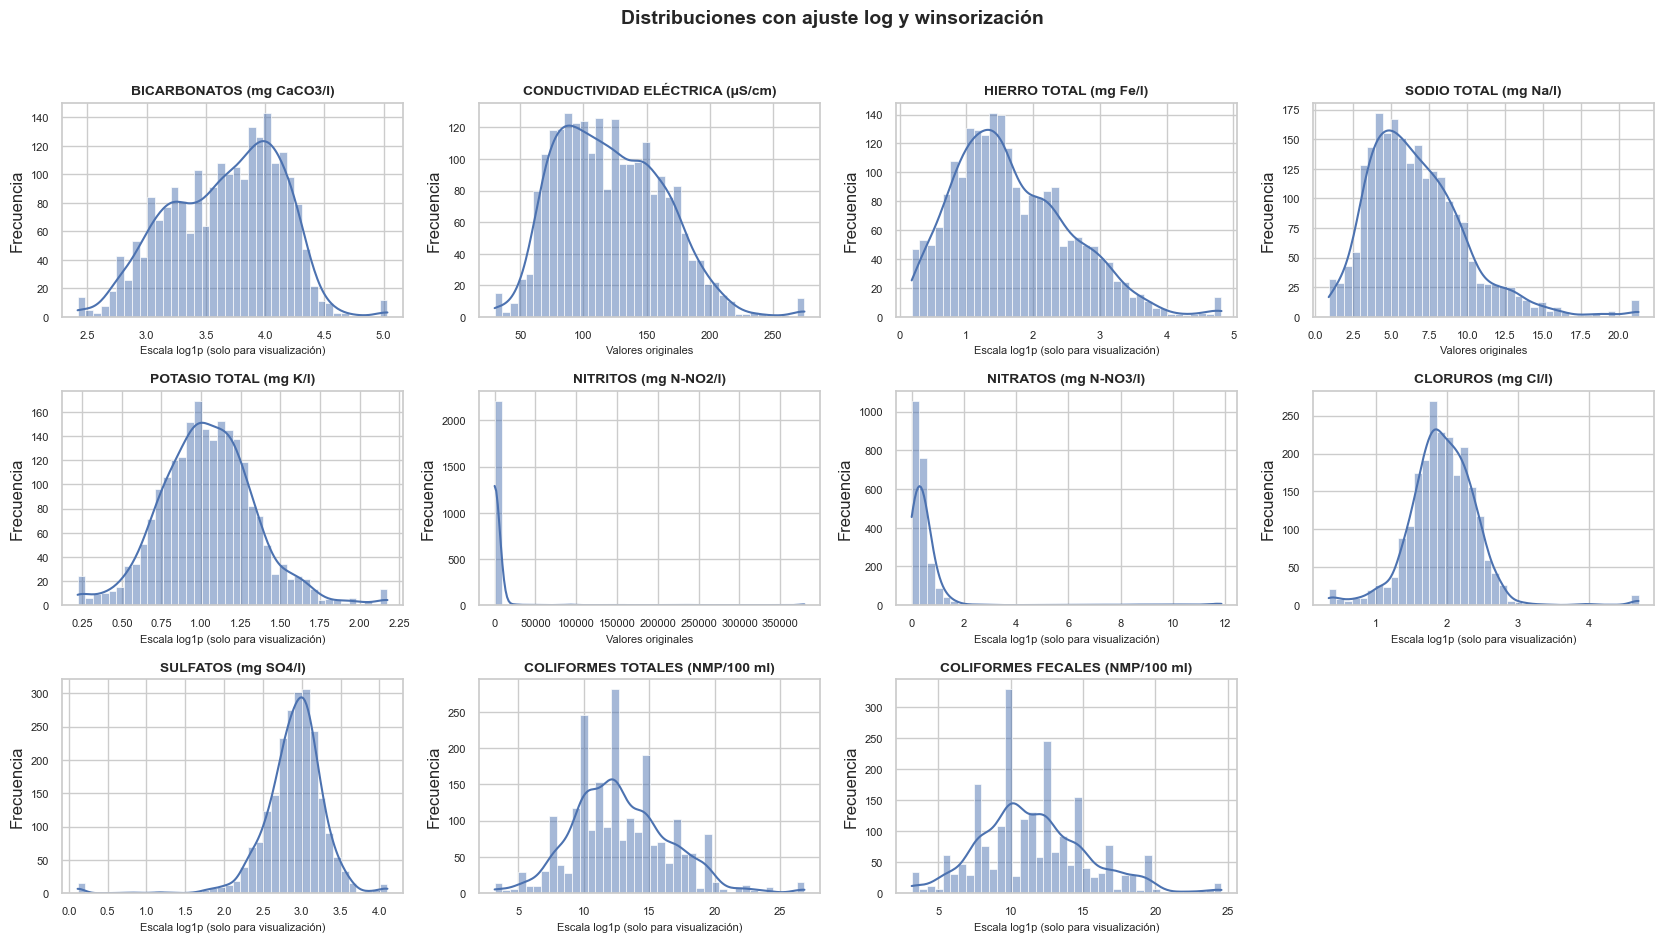

In [24]:
sns.set_theme(style="whitegrid")

# utilidad: decidir si conviene log
def needs_log(series, skew_thr=1.0):
    s = pd.to_numeric(series, errors='coerce').dropna()
    return (s.min() >= 0) and (abs(s.skew()) > skew_thr)

# utilidad: preparar para graficar
def prep_for_plot(series, winsor=(0.005, 0.995), bins=40):
    s = pd.to_numeric(series, errors='coerce').dropna()
    if needs_log(s):
        s = np.log1p(s)   # log(1+x), estable para 0+
        xlab = "Escala log1p (solo para visualizaci√≥n)"
    else:
        xlab = "Valores originales"
    lo, hi = s.quantile(winsor[0]), s.quantile(winsor[1])
    s = s.clip(lo, hi)
    return s, xlab

# columnas num√©ricas v√°lidas
num_cols = df_imputed.select_dtypes(include='number').columns.tolist()
num_cols = [c for c in num_cols if df_imputed[c].notna().any()]

# par√°metros de layout
COLS = 4
BINS = 40
PAGE = COLS * 4
H, W = 3.2, 4.2

# loop por p√°ginas
for start in range(0, len(num_cols), PAGE):
    subset = num_cols[start:start+PAGE]
    rows = int(np.ceil(len(subset) / COLS))
    fig, axes = plt.subplots(rows, COLS, figsize=(W*COLS, H*rows))
    axes = np.array(axes).reshape(-1)

    for ax, col in zip(axes, subset):
        s_plot, xlab = prep_for_plot(df_imputed[col], winsor=(0.005, 0.995), bins=BINS)
        sns.histplot(s_plot, bins=BINS, kde=(len(s_plot) > 50), ax=ax, color="#4C72B0")
        ax.set_title(col, fontsize=10, fontweight="bold")
        ax.set_xlabel(xlab, fontsize=8)
        ax.set_ylabel("Frecuencia")
        ax.tick_params(axis='both', labelsize=8)

    # limpiar ejes vac√≠os
    for ax in axes[len(subset):]:
        ax.remove()

    fig.suptitle("Distribuciones con ajuste log y winsorizaci√≥n", fontsize=14, fontweight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

## BOXPLOTS

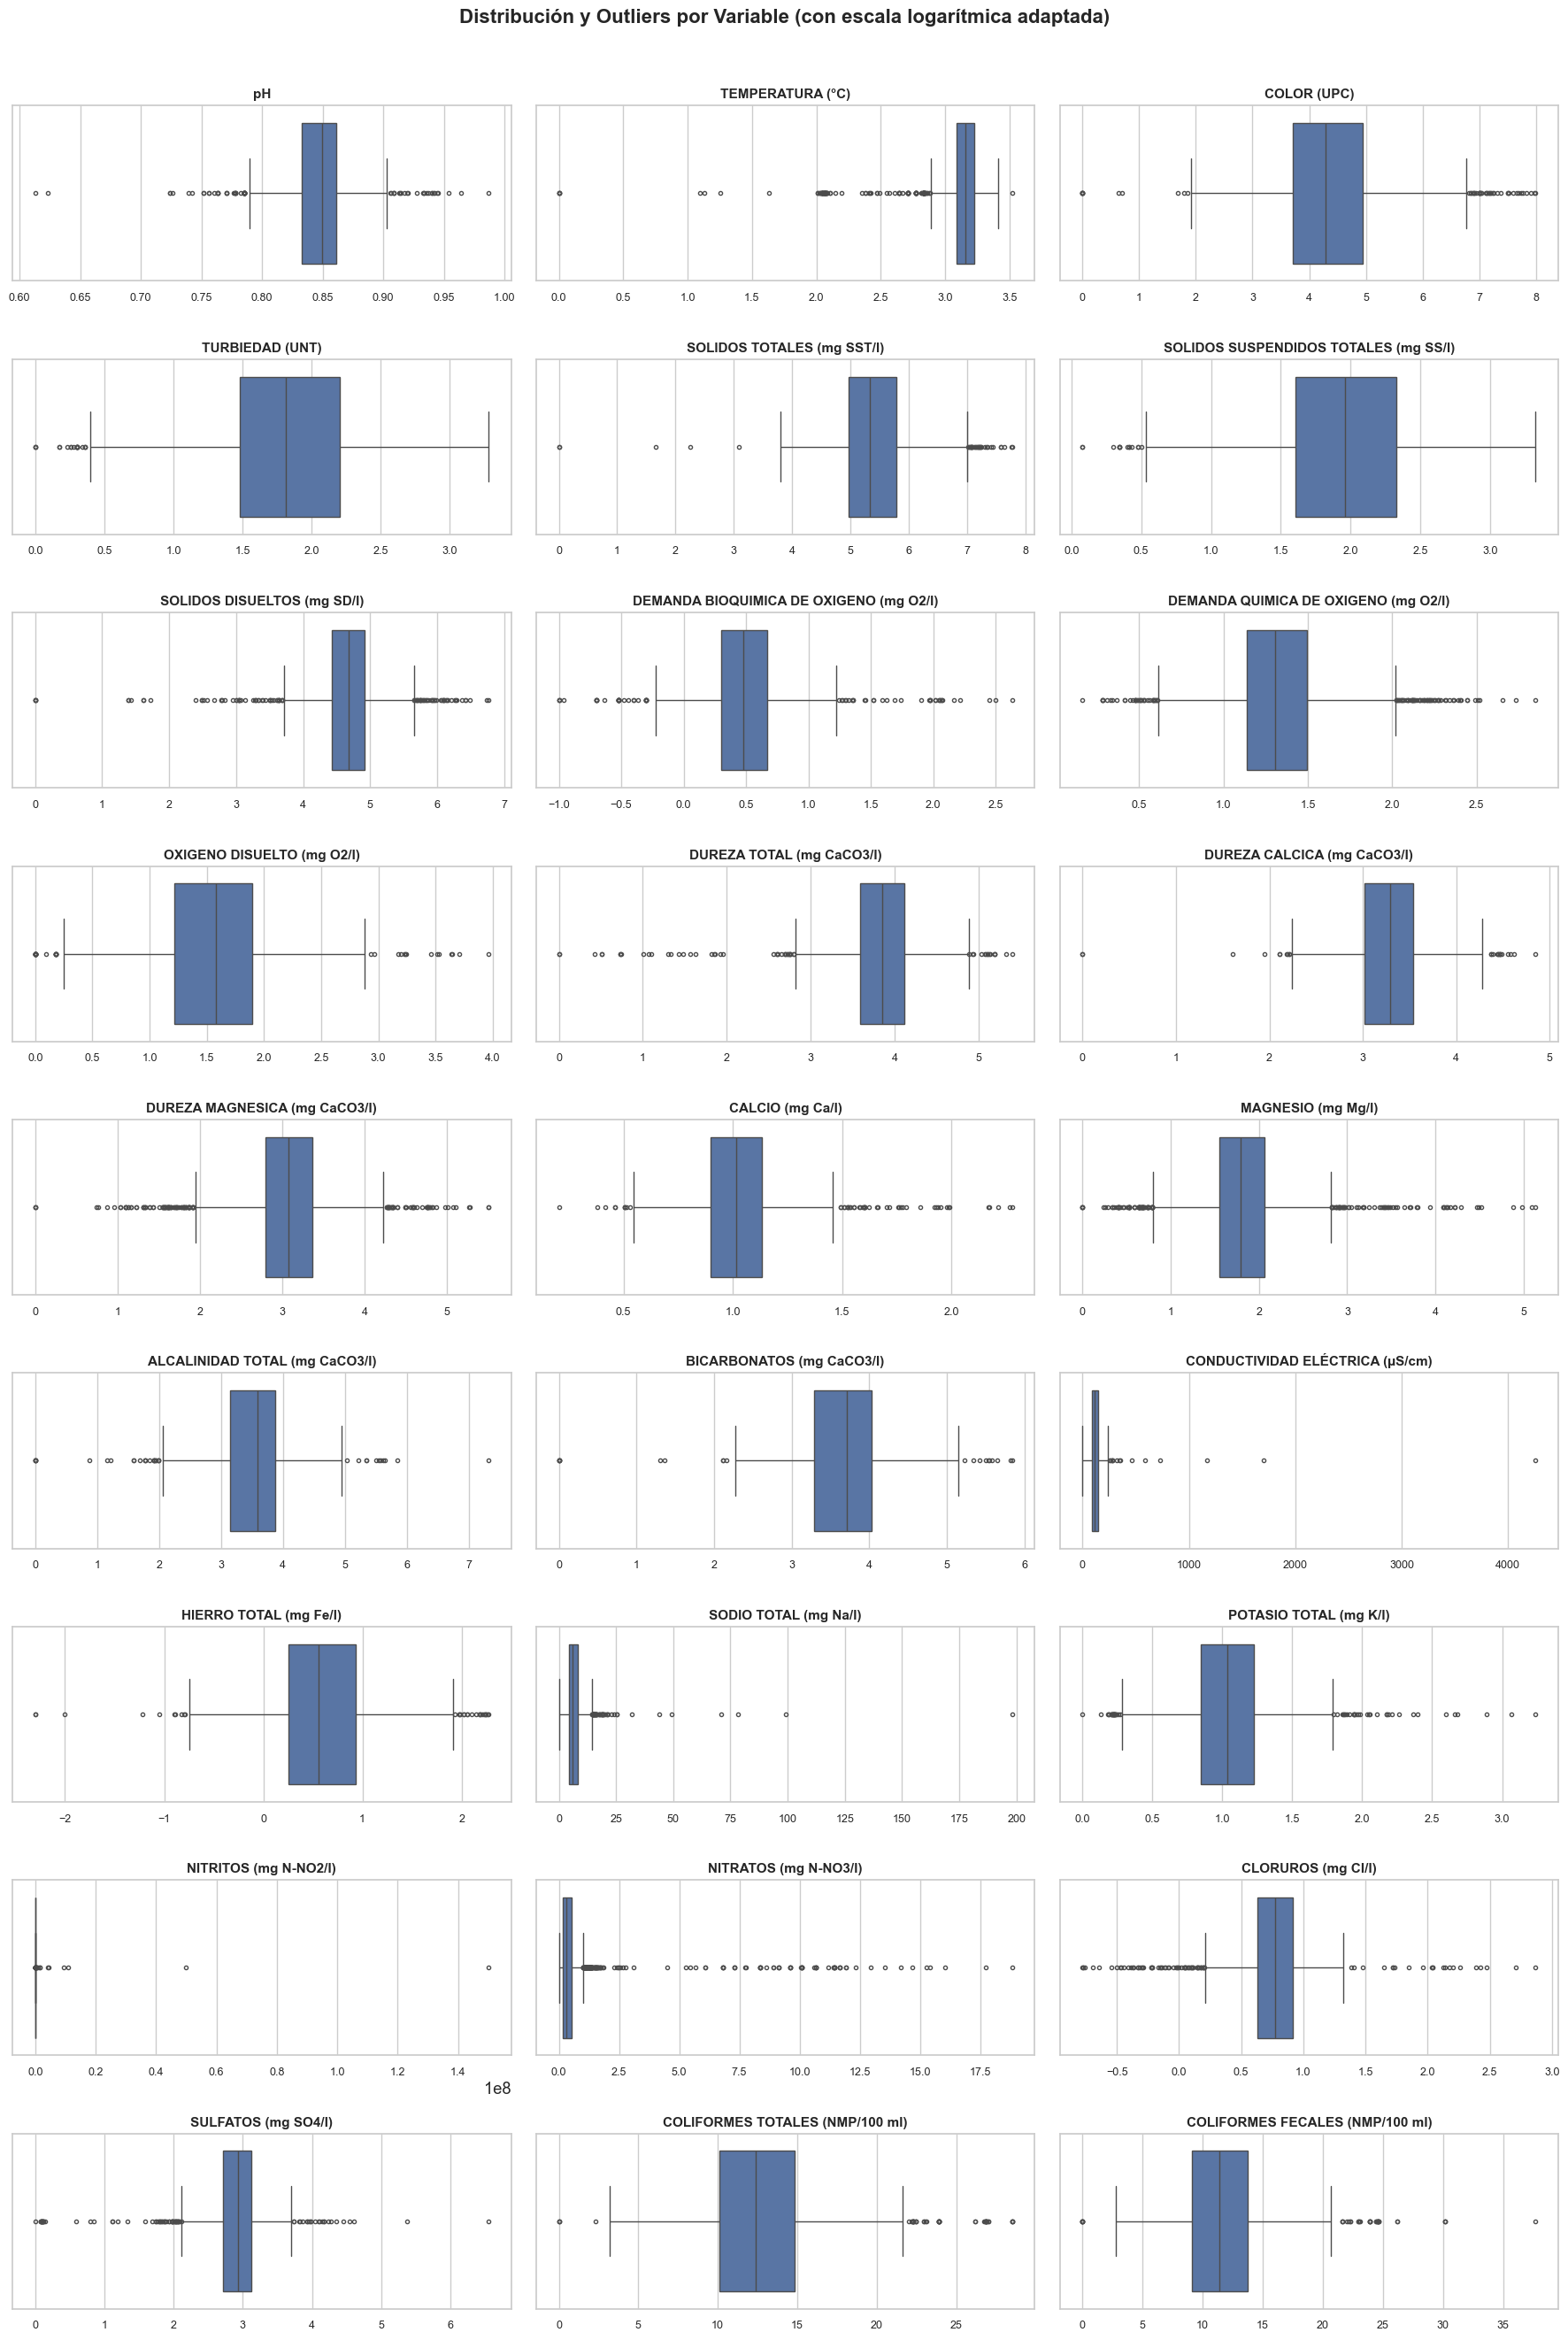

In [25]:
# Estilo gr√°fico
sns.set_theme(style="whitegrid", font_scale=1.2)

# Copia segura de la base imputada
df_box = df_imputed.copy()

# Funci√≥n: aplicar logaritmo solo si es seguro
def log_transform_safe(series):
    s = pd.to_numeric(series, errors="coerce")
    if (s > 0).all():
        return np.log10(s)          # log base 10 si todos > 0
    elif (s >= 0).all():
        return np.log1p(s)          # log(1+x) si todos >= 0
    else:
        return s                    # si hay negativos, no se transforma

# Aplicar la transformaci√≥n log segura a cada columna
df_box = df_box.apply(log_transform_safe)

# Configuraci√≥n de subplots
num_vars = len(df_box.columns)
num_cols = 3
num_rows = int(np.ceil(num_vars / num_cols))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, num_rows * 3))
axes = axes.flatten()

# Crear un boxplot por variable
for i, col in enumerate(df_box.columns):
    sns.boxplot(
        x=df_box[col],
        ax=axes[i],
        color="#4C72B0",
        fliersize=3,    # tama√±o de puntos at√≠picos
        linewidth=1
    )
    axes[i].set_title(col, fontsize=11, fontweight="bold")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].tick_params(axis='x', labelsize=9)

# Eliminar subplots vac√≠os si sobran
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Ajustar dise√±o
fig.suptitle(
    "Distribuci√≥n y Outliers por Variable (con escala logar√≠tmica adaptada)",
    fontsize=16, fontweight="bold"
)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [26]:
ols_prob = ['NITRITOS (mg N-NO2/l)', 'CONDUCTIVIDAD EL√âCTRICA (¬µS/cm)']

diag = []
for c in ols_prob:
    s = pd.to_numeric(df_imputed[c], errors='coerce').dropna()

    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    outliers = ((s < q1 - 1.5*iqr) | (s > q3 + 1.5*iqr))

    diag.append({
        'col': c,
        'n': s.size,
        'zeros_%': (s.eq(0).mean() * 100).round(2),
        'min': s.min(),
        'q1': q1, 
        'median': s.median(), 
        'q3': q3, 
        'max': s.max(),
        'skew': s.skew(), 
        'kurt': s.kurt(),
        'outliers(n)': int(outliers.sum()),
        'outliers_%': (outliers.mean() * 100).round(2)
    })

pd.DataFrame(diag)

col     n  zeros_%           min     q1  \
0            NITRITOS (mg N-NO2/l)  2254      0.0 -1.455192e-11   0.01   
1  CONDUCTIVIDAD EL√âCTRICA (¬µS/cm)  2254      0.0 -1.421085e-14  87.50   

     median         q3          max       skew         kurt  outliers(n)  \
0    0.0251    0.08885  150000000.0  41.428283  1810.841234          446   
1  117.0000  151.00000       4259.0  28.374031  1052.214221           14   

   outliers_%  
0       19.79  
1        0.62

In [27]:
# Top 10 valores m√°s altos para revisar posibles errores/unidades
cols_prob = ['NITRITOS (mg N-NO2/l)', 'CONDUCTIVIDAD EL√âCTRICA (¬µS/cm)']

for c in cols_prob:
    print(f"\nTop 10 valores de {c}:")
    top_vals = (
        df_imputed[[c]]
        .reset_index(names="idx")   # mostrar √≠ndice original como columna
        .sort_values(c, ascending=False)
        .head(10)
    )
    display(top_vals)


Top 10 valores de NITRITOS (mg N-NO2/l):


idx  NITRITOS (mg N-NO2/l)
2166  2166            150000000.0
2174  2174             50000000.0
2171  2171             11000000.0
2172  2172              9300000.0
2168  2168              4600000.0
2175  2175              4300000.0
2180  2180              1500000.0
2165  2165              1500000.0
2186  2186               930000.0
2164  2164               430000.0


Top 10 valores de CONDUCTIVIDAD EL√âCTRICA (¬µS/cm):


idx  CONDUCTIVIDAD EL√âCTRICA (¬µS/cm)
1078  1078                           4259.0
1885  1885                           1706.0
649    649                           1172.0
374    374                            727.2
1887  1887                            589.0
1437  1437                            467.0
744    744                            354.0
342    342                            343.4
46      46                            319.5
561    561                            283.9

In [28]:
def transform_robusta_para_plot(s: pd.Series, p_low=0.005, p_high=0.995):

    s = pd.to_numeric(s, errors='coerce').dropna()

    # epsilon = mitad del m√≠nimo positivo para permitir log(0)
    min_pos = s[s > 0].min()
    eps = min_pos/2 if pd.notna(min_pos) and min_pos > 0 else 1e-12

    # Transformaci√≥n seg√∫n el rango
    if (s >= 0).all():
        s = np.log10(s + eps)
    else:
        med = s.median()
        iqr = (s.quantile(0.75) - s.quantile(0.25)) or 1.0
        s = (s - med) / iqr

    # Winsorizaci√≥n para limitar outliers extremos
    lo, hi = s.quantile(p_low), s.quantile(p_high)
    return s.clip(lo, hi)


# Copia para graficar con variables transformadas
df_plot = df_imputed.copy()
for c in cols_prob:
    df_plot[c] = transform_robusta_para_plot(df_imputed[c])


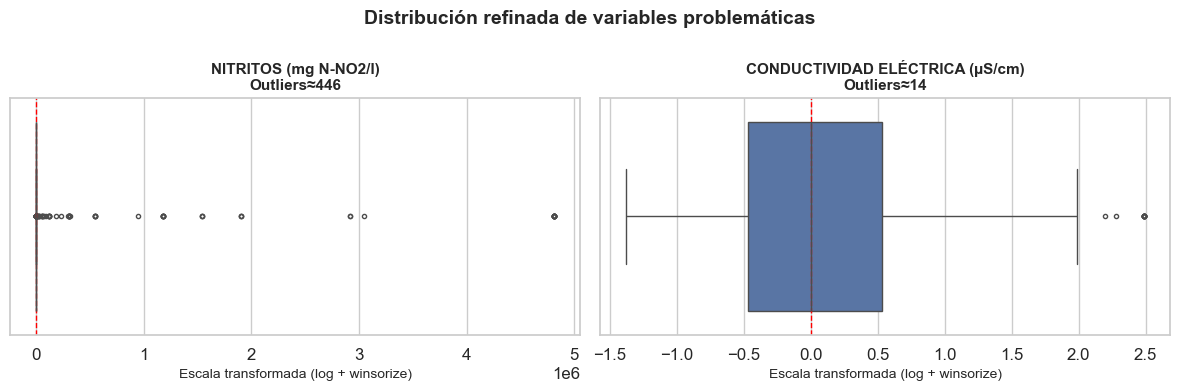

In [29]:
sns.set_theme(style="whitegrid", font_scale=1.1)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, col in zip(axes, cols_prob):
    sns.boxplot(
        x=df_plot[col], 
        ax=ax, 
        color="#4C72B0", 
        fliersize=3, 
        linewidth=1
    )
    # L√≠nea en la mediana
    ax.axvline(df_plot[col].median(), ls="--", color="red", lw=1)
    
    # Contar outliers extremos (en escala transformada)
    q1, q3 = df_plot[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    outliers = ((df_plot[col] < q1 - 1.5*iqr) | (df_plot[col] > q3 + 1.5*iqr)).sum()

    ax.set_title(f"{col}\nOutliers‚âà{outliers}", fontsize=11, fontweight="bold")
    ax.set_xlabel("Escala transformada (log + winsorize)", fontsize=10)
    ax.set_ylabel("")

fig.suptitle("Distribuci√≥n refinada de variables problem√°ticas", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


# CORRELACIONES (excluyendo objetivos)

Columnas usadas para correlaci√≥n entre predictores: 25
Objetivos excluidos del mapa entre predictores: ['DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)', 'pH']

Pares altamente correlacionados (Pearson):


Variable_1                             Variable_2  \
285          NITRITOS (mg N-NO2/l)                  NITRATOS (mg N-NO3/l)   
69      SOLIDOS TOTALES (mg SST/l)  SOLIDOS SUSPENDIDOS TOTALES (mg SS/l)   
209               CALCIO (mg Ca/l)                     MAGNESIO (mg Mg/l)   
196  DUREZA MAGNESICA (mg CaCO3/l)                     MAGNESIO (mg Mg/l)   

     Correlacion  
285     0.999167  
69      0.945886  
209     0.889820  
196     0.862277


Pares altamente correlacionados (Spearman):


Variable_1                             Variable_2  \
196    DUREZA MAGNESICA (mg CaCO3/l)                     MAGNESIO (mg Mg/l)   
181      DUREZA CALCICA (mg CaCO3/l)                       CALCIO (mg Ca/l)   
234   ALCALINIDAD TOTAL (mg CaCO3/l)              BICARBONATOS (mg CaCO3/l)   
299  COLIFORMES TOTALES (NMP/100 ml)        COLIFORMES FECALES (NMP/100 ml)   
69        SOLIDOS TOTALES (mg SST/l)  SOLIDOS SUSPENDIDOS TOTALES (mg SS/l)   
164        DUREZA TOTAL (mg CaCO3/l)            DUREZA CALCICA (mg CaCO3/l)   
165        DUREZA TOTAL (mg CaCO3/l)          DUREZA MAGNESICA (mg CaCO3/l)   

     Correlacion  
196     0.989248  
181     0.959695  
234     0.933178  
299     0.890696  
69      0.863731  
164     0.817818  
165     0.804018

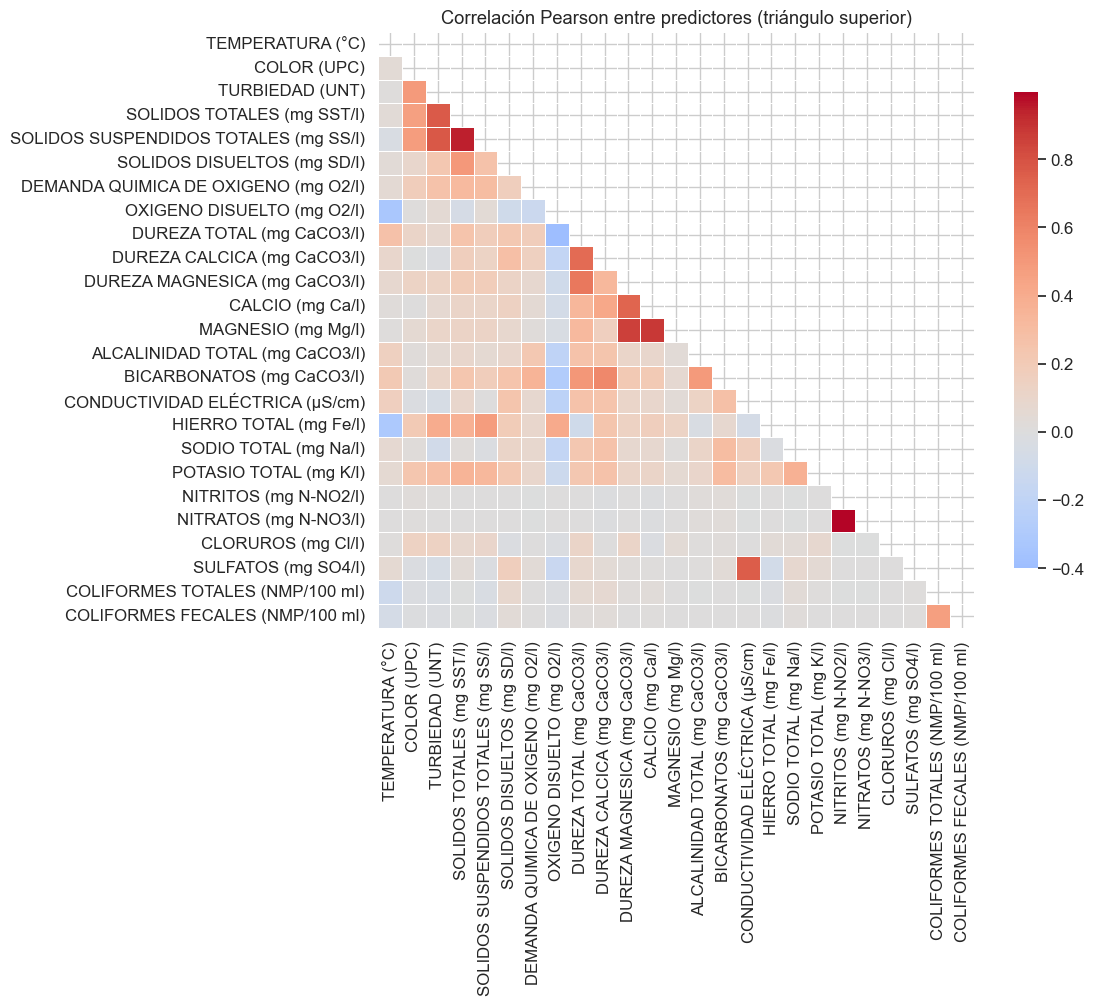

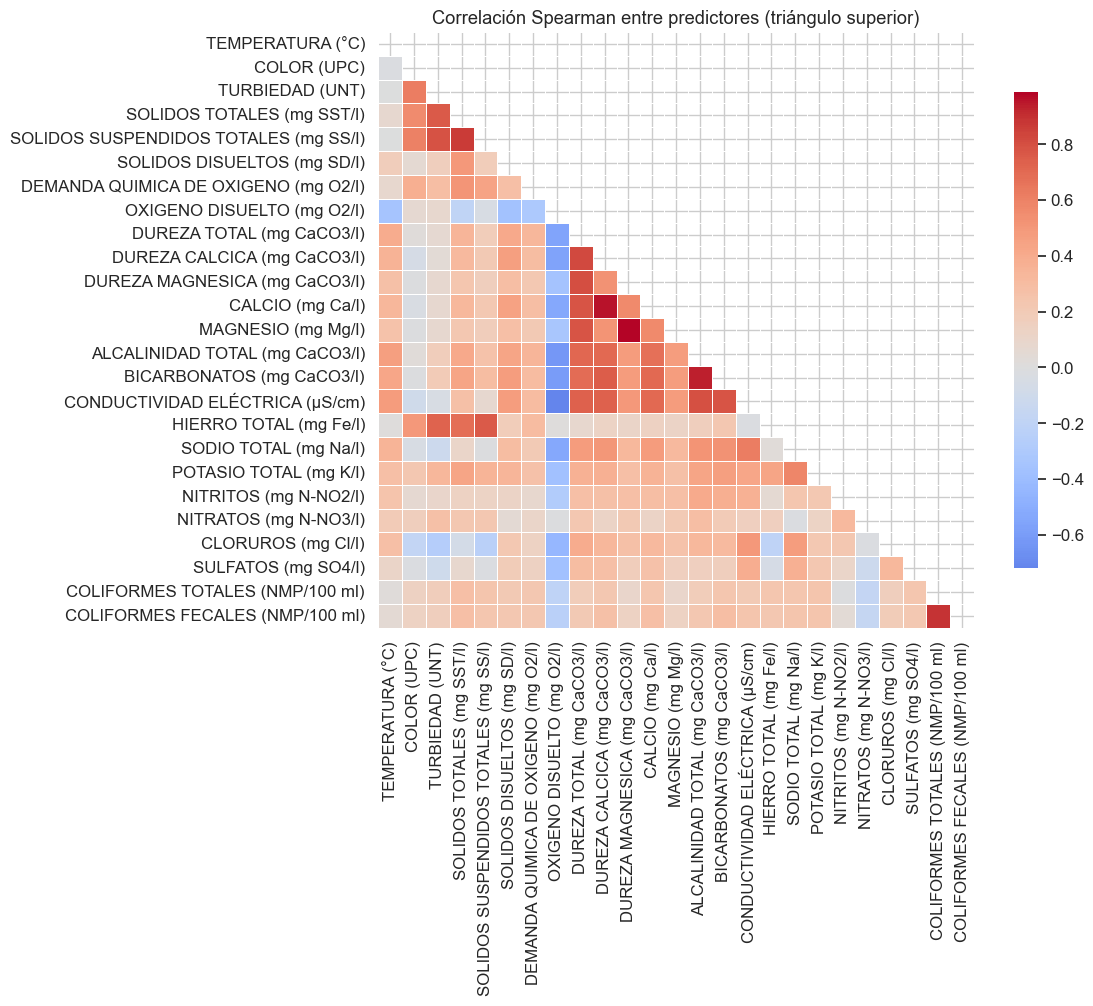


Correlaci√≥n Spearman de predictores con el objetivo: DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)


Spearman_vs_objetivo
BICARBONATOS (mg CaCO3/l)                          0.526899
CONDUCTIVIDAD EL√âCTRICA (¬µS/cm)                    0.500682
ALCALINIDAD TOTAL (mg CaCO3/l)                     0.488444
CALCIO (mg Ca/l)                                   0.460828
DUREZA CALCICA (mg CaCO3/l)                        0.458406
SODIO TOTAL (mg Na/l)                              0.381278
DUREZA TOTAL (mg CaCO3/l)                          0.357546
COLIFORMES FECALES (NMP/100 ml)                    0.354755
POTASIO TOTAL (mg K/l)                             0.335980
DEMANDA QUIMICA DE OXIGENO (mg O2/l)               0.320140
COLIFORMES TOTALES (NMP/100 ml)                    0.319804
SOLIDOS DISUELTOS (mg SD/l)                        0.305377
SOLIDOS TOTALES (mg SST/l)                         0.300415
NITRITOS (mg N-NO2/l)                              0.290383
MAGNESIO (mg Mg/l)                                 0.281166
DUREZA MAGNESICA (mg CaCO3/l)                      0.273995
SOLIDOS SUSPENDIDOS TOTALES (mg SS/l)              0.246680
TEMPERATURA (¬∞C)                                   0.239650
CLORUROS (mg Cl/l)                                 0.220268
HIERRO TOTAL (mg Fe/l)                             0.207312
SULFATOS (mg SO4/l)                                0.176245
TURBIEDAD (UNT)                                    0.154607
NITRATOS (mg N-NO3/l)                              0.081484
COLOR (UPC)                                        0.054881
OXIGENO DISUELTO (mg O2/l)                        -0.497489


Correlaci√≥n Spearman de predictores con el objetivo: pH


Spearman_vs_objetivo
NITRATOS (mg N-NO3/l)                              0.306038
ALCALINIDAD TOTAL (mg CaCO3/l)                     0.285236
BICARBONATOS (mg CaCO3/l)                          0.243331
TEMPERATURA (¬∞C)                                   0.235442
DUREZA CALCICA (mg CaCO3/l)                        0.172514
NITRITOS (mg N-NO2/l)                              0.170256
CALCIO (mg Ca/l)                                   0.164018
CONDUCTIVIDAD EL√âCTRICA (¬µS/cm)                    0.158347
DUREZA TOTAL (mg CaCO3/l)                          0.153381
SOLIDOS SUSPENDIDOS TOTALES (mg SS/l)              0.107343
DUREZA MAGNESICA (mg CaCO3/l)                      0.098545
MAGNESIO (mg Mg/l)                                 0.094437
SOLIDOS TOTALES (mg SST/l)                         0.089851
TURBIEDAD (UNT)                                    0.079100
COLOR (UPC)                                        0.036896
OXIGENO DISUELTO (mg O2/l)                         0.030051
SODIO TOTAL (mg Na/l)                              0.027339
DEMANDA QUIMICA DE OXIGENO (mg O2/l)               0.008562
SOLIDOS DISUELTOS (mg SD/l)                        0.003770
HIERRO TOTAL (mg Fe/l)                             0.001060
POTASIO TOTAL (mg K/l)                            -0.042816
CLORUROS (mg Cl/l)                                -0.055488
COLIFORMES FECALES (NMP/100 ml)                   -0.069841
COLIFORMES TOTALES (NMP/100 ml)                   -0.093693
SULFATOS (mg SO4/l)                               -0.148100

In [30]:
# Requisitos: df_imputed ya creado; 'objetivos' definido (1 o 2 nombres exactos en df_imputed)

# Preparar base num√©rica y limpiar
df_num = df_imputed.select_dtypes(include='number').copy()
df_num = df_num.replace([np.inf, -np.inf], np.nan).dropna(axis=1, how='all')

# Quitar columnas constantes
var0 = df_num.nunique(dropna=True) <= 1
if var0.any():
    df_num = df_num.loc[:, ~var0]

# Excluir objetivos del bloque de correlaci√≥n entre predictores
objetivos_presentes = [o for o in (objetivos if 'objetivos' in globals() else []) if o in df_num.columns]
pred_cols = [c for c in df_num.columns if c not in objetivos_presentes]

print(f"Columnas usadas para correlaci√≥n entre predictores: {len(pred_cols)}")
if objetivos_presentes:
    print("Objetivos excluidos del mapa entre predictores:", objetivos_presentes)

assert len(pred_cols) > 1, "No hay columnas num√©ricas v√°lidas para correlaci√≥n entre predictores."

# Correlaciones entre predictores (Pearson y Spearman)
corr_p = df_num[pred_cols].corr(method='pearson')
corr_s = df_num[pred_cols].corr(method='spearman')

# Funci√≥n para extraer pares fuertes (sin duplicados)
def pares_fuertes(corr, umbral=0.8):
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
    corr_u = corr.where(mask)
    out = (
        corr_u.stack()
        .rename("Correlacion")
        .reset_index()
        .rename(columns={"level_0": "Variable_1", "level_1": "Variable_2"})
        .assign(abs_val=lambda d: d["Correlacion"].abs())
        .query("abs_val >= @umbral")
        .sort_values("abs_val", ascending=False)
        .drop(columns="abs_val")
    )
    return out

pares_pearson  = pares_fuertes(corr_p, umbral=0.8)
pares_spearman = pares_fuertes(corr_s, umbral=0.8)

print("\nPares altamente correlacionados (Pearson):")
display(pares_pearson.head(20))
print("\nPares altamente correlacionados (Spearman):")
display(pares_spearman.head(20))

# Heatmaps (tri√°ngulo superior)
def heatmap_corr(corr, title):
    mask = np.triu(np.ones_like(corr, dtype=bool))
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr, mask=mask, cmap="coolwarm", center=0,
        square=True, linewidths=.5, cbar_kws={"shrink": .8}
    )
    plt.title(title)
    plt.tight_layout()
    plt.show()

heatmap_corr(corr_p, "Correlaci√≥n Pearson entre predictores (tri√°ngulo superior)")
heatmap_corr(corr_s, "Correlaci√≥n Spearman entre predictores (tri√°ngulo superior)")

# (Extra √∫til) Correlaci√≥n de CADA objetivo vs. predictores
if objetivos_presentes:
    for obj in objetivos_presentes:
        # solo columnas que coexisten con el objetivo sin NaN simult√°neo
        sub = df_num[pred_cols + [obj]].dropna(subset=[obj])
        corr_obj = sub.corr(method='spearman')[obj].drop(labels=[obj]).sort_values(ascending=False)
        print(f"\nCorrelaci√≥n Spearman de predictores con el objetivo: {obj}")
        display(corr_obj.to_frame(name="Spearman_vs_objetivo"))

# FILTRO POR COLINEALIDAD (Spearman)

In [31]:
# Usa corr_s (entre predictores) ya calculado
UMBRAL = 0.85  # ajusta a gusto (0.8-0.9 suele ser razonable)

corr_abs = corr_s.abs()
mask_sup = np.triu(np.ones_like(corr_abs, dtype=bool), k=1)
pairs = (
    corr_abs.where(mask_sup)
    .stack()
    .rename("rho")
    .reset_index()
    .rename(columns={"level_0": "A", "level_1": "B"})
    .query("rho >= @UMBRAL")
    .sort_values("rho", ascending=False)
)

print(f"Pares con |Spearman| ‚â• {UMBRAL}: {len(pairs)}")
display(pairs.head(20))

# ===== Heur√≠stica mejorada para decidir a qui√©n eliminar =====
# 1) Preferir la variable con MAYOR |corr| respecto al/los objetivo(s) seleccionados.
# 2) Si no hay objetivos (o empate), usar el mayor promedio de |corr| con las dem√°s (tu fallback).

# Objetivos presentes en df_num (si definiste 'objetivos' antes)
objetivos_presentes = [o for o in (objetivos if 'objetivos' in globals() else []) if o in df_imputed.columns]

# Construir score por variable basado en relaci√≥n con objetivos
target_score = {}
if objetivos_presentes:
    # Spearman entre TODOS los num√©ricos y cada objetivo (en abs) y tomamos el m√°ximo por variable
    for var in df_num.columns:
        if var in objetivos_presentes:
            continue
        cors = []
        for obj in objetivos_presentes:
            sub = df_imputed[[var, obj]].dropna()
            if sub.shape[0] > 2:
                cors.append(sub.corr(method='spearman').iloc[0, 1])
        target_score[var] = np.max(np.abs(cors)) if cors else 0.0
else:
    # si no hay objetivos, score = 0 (se usar√° el fallback)
    target_score = {var: 0.0 for var in df_num.columns}

# Fallback: correlaci√≥n media absoluta con el resto (tu criterio original)
mean_abs_corr = corr_abs.mean().to_dict()

eliminar, conservar = set(), set()

for _, row in pairs.iterrows():
    a, b = row["A"], row["B"]
    # si ya se decidi√≥ algo por pares anteriores, saltar
    if a in eliminar or b in eliminar:
        continue

    # nunca eliminar objetivos (por seguridad, aunque aqu√≠ no deber√≠an estar)
    if a in objetivos_presentes:
        conservar.add(a); eliminar.add(b); continue
    if b in objetivos_presentes:
        conservar.add(b); eliminar.add(a); continue

    # 1) usar score con objetivos
    ta, tb = target_score.get(a, 0.0), target_score.get(b, 0.0)

    if not np.isclose(ta, tb):
        keep, drop = (a, b) if ta > tb else (b, a)
    else:
        # 2) empate o sin objetivos -> usar promedio de |corr|
        ma, mb = mean_abs_corr.get(a, 0.0), mean_abs_corr.get(b, 0.0)
        keep, drop = (a, b) if ma >= mb else (b, a)

    conservar.add(keep)
    eliminar.add(drop)

eliminar = sorted(eliminar)
print(f"\nVariables a eliminar por alta colinealidad (heur√≠stica objetivo‚Üífallback):")
print(eliminar)

# DataFrame filtrado por correlaci√≥n (listo para VIF / feature selection)
df_corr_filtered = df_num.drop(columns=eliminar, errors='ignore')

print(f"\nShape original (num√©rico): {df_num.shape}")
print(f"Shape tras filtrar por correlaci√≥n: {df_corr_filtered.shape}")

# ver resumen de lo conservado
conservadas = list(df_corr_filtered.columns)
print(f"\nVariables conservadas ({len(conservadas)}):")
conservadas

Pares con |Spearman| ‚â• 0.85: 5


A                                      B  \
196    DUREZA MAGNESICA (mg CaCO3/l)                     MAGNESIO (mg Mg/l)   
181      DUREZA CALCICA (mg CaCO3/l)                       CALCIO (mg Ca/l)   
234   ALCALINIDAD TOTAL (mg CaCO3/l)              BICARBONATOS (mg CaCO3/l)   
299  COLIFORMES TOTALES (NMP/100 ml)        COLIFORMES FECALES (NMP/100 ml)   
69        SOLIDOS TOTALES (mg SST/l)  SOLIDOS SUSPENDIDOS TOTALES (mg SS/l)   

          rho  
196  0.989248  
181  0.959695  
234  0.933178  
299  0.890696  
69   0.863731


Variables a eliminar por alta colinealidad (heur√≠stica objetivo‚Üífallback):
['ALCALINIDAD TOTAL (mg CaCO3/l)', 'COLIFORMES TOTALES (NMP/100 ml)', 'DUREZA CALCICA (mg CaCO3/l)', 'DUREZA MAGNESICA (mg CaCO3/l)', 'SOLIDOS SUSPENDIDOS TOTALES (mg SS/l)']

Shape original (num√©rico): (2254, 27)
Shape tras filtrar por correlaci√≥n: (2254, 22)

Variables conservadas (22):


['pH',
 'TEMPERATURA (¬∞C)',
 'COLOR (UPC)',
 'TURBIEDAD (UNT)',
 'SOLIDOS TOTALES (mg SST/l)',
 'SOLIDOS DISUELTOS (mg SD/l)',
 'DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)',
 'DEMANDA QUIMICA DE OXIGENO (mg O2/l)',
 'OXIGENO DISUELTO (mg O2/l)',
 'DUREZA TOTAL (mg CaCO3/l)',
 'CALCIO (mg Ca/l)',
 'MAGNESIO (mg Mg/l)',
 'BICARBONATOS (mg CaCO3/l)',
 'CONDUCTIVIDAD EL√âCTRICA (¬µS/cm)',
 'HIERRO TOTAL (mg Fe/l)',
 'SODIO TOTAL (mg Na/l)',
 'POTASIO TOTAL (mg K/l)',
 'NITRITOS (mg N-NO2/l)',
 'NITRATOS (mg N-NO3/l)',
 'CLORUROS (mg Cl/l)',
 'SULFATOS (mg SO4/l)',
 'COLIFORMES FECALES (NMP/100 ml)']

# VIF iterativo

In [32]:
# df_corr_filtered: viene del paso anterior (filtrado por correlaci√≥n)
X0 = df_corr_filtered.copy()

# Por seguridad, quitar filas con NaN residuales
X0 = X0.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

# Objetivos a proteger (no deben eliminarse nunca)
objetivos_presentes = [o for o in (objetivos if 'objetivos' in globals() else []) if o in X0.columns]

def calc_vif(dfX: pd.DataFrame) -> pd.DataFrame:
    """Calcula VIF para todas las columnas de dfX."""
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    Xmat = dfX.values
    vif_vals = [variance_inflation_factor(Xmat, i) for i in range(Xmat.shape[1])]
    return pd.DataFrame({"feature": dfX.columns, "VIF": vif_vals}).sort_values("VIF", ascending=False)

UMBRAL_VIF = 10.0
removed = []
vif_historial = []

X = X0.copy()

while True:
    vif_df = calc_vif(X)
    vif_historial.append(vif_df.assign(iter=len(vif_historial)+1))

    # variable con VIF m√°ximo
    idx_max = vif_df["VIF"].idxmax()
    feat_max = vif_df.loc[idx_max, "feature"]
    max_vif = vif_df.loc[idx_max, "VIF"]

    print(f"Iteraci√≥n {len(vif_historial)} | M√°x VIF = {max_vif:.2f} ({feat_max}) | n_vars = {X.shape[1]}")

    # condici√≥n de parada
    if (max_vif <= UMBRAL_VIF) or (X.shape[1] <= 2):
        break

    # NO eliminar objetivos
    if feat_max in objetivos_presentes:
        print(f"{feat_max} es objetivo, se conserva aunque tenga VIF alto.")
        break

    # eliminar la variable m√°s colineal y repetir
    removed.append((feat_max, float(max_vif)))
    X = X.drop(columns=[feat_max])

# DataFrames de salida
vif_historial = pd.concat(vif_historial, ignore_index=True)
vif_final = calc_vif(X).reset_index(drop=True)
df_vif_filtered = X.copy()

print("\nVariables eliminadas por VIF > {:.1f}:".format(UMBRAL_VIF))
for f, v in removed:
    print(f"  - {f} (VIF={v:.2f})")

print("\nResumen:")
print(f"Shape inicial (post-correlaci√≥n): {X0.shape}")
print(f"Shape final (post-VIF):           {df_vif_filtered.shape}")

print("\nVIF final (variables conservadas):")
display(vif_final)

Iteraci√≥n 1 | M√°x VIF = 616.90 (NITRITOS (mg N-NO2/l)) | n_vars = 22
Iteraci√≥n 2 | M√°x VIF = 5.86 (CALCIO (mg Ca/l)) | n_vars = 21

Variables eliminadas por VIF > 10.0:
  - NITRITOS (mg N-NO2/l) (VIF=616.90)

Resumen:
Shape inicial (post-correlaci√≥n): (2254, 22)
Shape final (post-VIF):           (2254, 21)

VIF final (variables conservadas):


feature       VIF
0                          CALCIO (mg Ca/l)  5.855409
1                        MAGNESIO (mg Mg/l)  5.740587
2                SOLIDOS TOTALES (mg SST/l)  3.903843
3                           TURBIEDAD (UNT)  3.168682
4                    HIERRO TOTAL (mg Fe/l)  2.994304
5           CONDUCTIVIDAD EL√âCTRICA (¬µS/cm)  2.949222
6                       SULFATOS (mg SO4/l)  2.608597
7   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)  2.223375
8                 BICARBONATOS (mg CaCO3/l)  1.979933
9                 DUREZA TOTAL (mg CaCO3/l)  1.911038
10               OXIGENO DISUELTO (mg O2/l)  1.590968
11              SOLIDOS DISUELTOS (mg SD/l)  1.564340
12                   POTASIO TOTAL (mg K/l)  1.458421
13                              COLOR (UPC)  1.436853
14                    SODIO TOTAL (mg Na/l)  1.308509
15     DEMANDA QUIMICA DE OXIGENO (mg O2/l)  1.268452
16                         TEMPERATURA (¬∞C)  1.224073
17                       CLORUROS (mg Cl/l)  1.061917
18          COLIFORMES FECALES (NMP/100 ml)  1.009549
19                    NITRATOS (mg N-NO3/l)  1.002852
20                                       pH  0.202579

## RFE

In [33]:
# 0) asegura artefactos global
try:
    artefactos  # noqa
except NameError:
    artefactos = {}

# 1) constantes
rng = 42
OBJ_DBO = "DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)"
OBJ_PH  = "pH"

# 2) helpers
def _metricas(y, yhat):
    rmse = sqrt(mean_squared_error(y, yhat))
    r2   = r2_score(y, yhat)
    mae  = mean_absolute_error(y, yhat)
    return rmse, r2, mae

def _prep_xy_vif(objetivo):
    assert 'df_vif_filtered' in globals(), "Falta df_vif_filtered"
    assert 'df_imputed' in globals(), "Falta df_imputed"
    X0 = df_vif_filtered.select_dtypes(include='number').copy()
    if objetivo in X0.columns:
        X0 = X0.drop(columns=[objetivo])
    y0 = df_imputed.loc[:, objetivo].copy()
    m  = y0.notna()
    X  = X0.loc[m].copy(); y = y0.loc[m].copy()
    X, y = X.align(y, join='inner', axis=0)
    assert X.shape[1] > 0 and len(X) > 0, f"Sin features o filas para {objetivo} en VIF"
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=rng, shuffle=True)
    assert list(Xtr.columns) == list(Xte.columns), "Columnas desalineadas"
    return Xtr, Xte, ytr, yte, list(X.columns)

# 3) modelado b√°sico (sin grid/optuna)
def entrenar_modelos_basicos_vif(objetivo):
    global artefactos

    Xtr, Xte, ytr, yte, cols = _prep_xy_vif(objetivo)

    modelos = {
        "LR":        Pipeline([("std", StandardScaler()), ("m", LinearRegression())]),
        "CART":      DecisionTreeRegressor(random_state=rng),
        "RF":        RandomForestRegressor(random_state=rng, n_jobs=-1),
        "SVR (RBF)": Pipeline([("std", StandardScaler()), ("m", SVR(kernel="rbf"))]),
        "MLP":       Pipeline([("std", StandardScaler()), ("m", MLPRegressor(random_state=rng, max_iter=600))])
    }
    # incluye XGBoost si est√° disponible
    try:
        import xgboost as xgb
        modelos["XGBoost"] = xgb.XGBRegressor(
            random_state=rng, tree_method="hist", n_jobs=-1,
            max_depth=6, learning_rate=0.1, n_estimators=400,
            subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0
        )
    except Exception:
        pass

    filas, ganadores = [], {}
    for nombre, est in modelos.items():
        est.fit(Xtr, ytr)
        yhat = est.predict(Xte)
        rmse, r2, mae = _metricas(yte, yhat)
        filas.append([objetivo, "vif", nombre, rmse, r2, mae])
        ganadores[nombre] = est

    tabla = (
        pd.DataFrame(filas, columns=["objetivo","escenario","modelo","RMSE","R2","MAE"])
          .sort_values("RMSE").reset_index(drop=True)
    )

    artefactos.setdefault("vif_basico_resumen", pd.DataFrame())
    artefactos["vif_basico_resumen"] = pd.concat(
        [artefactos["vif_basico_resumen"], tabla], ignore_index=True
    )
    artefactos.setdefault("modelos_basicos", {}).setdefault(objetivo, {})["vif"] = ganadores
    artefactos.setdefault("splits", {}).setdefault(objetivo, {})["vif"] = {
        "X_test": Xte, "y_test": yte, "cols": cols
    }

    print(f"\n=== Modelado b√°sico VIF ¬∑ {objetivo} (sin Grid/Optuna) ===")
    print(tabla.to_string(index=False))
    return tabla, ganadores

# 4) ejecutar sin resumen combinado (lo haremos tras tuning)
tabla_vif_dbo, modelos_vif_dbo = entrenar_modelos_basicos_vif(OBJ_DBO)
tabla_vif_ph,  modelos_vif_ph  = entrenar_modelos_basicos_vif(OBJ_PH)

# (opcional) si quieres ver el acumulado, descomenta:
resumen_vif_basico = artefactos["vif_basico_resumen"].sort_values(["objetivo","RMSE"]).reset_index(drop=True)
print("\n=== RESUMEN VIF ¬∑ Modelado b√°sico (DBO y pH) ===")
print(resumen_vif_basico.to_string(index=False))


=== Modelado b√°sico VIF ¬∑ DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (sin Grid/Optuna) ===
                               objetivo escenario    modelo      RMSE        R2      MAE
DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)       vif       MLP  4.414317  0.826051 2.317418
DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)       vif        LR  7.229026  0.533496 3.747344
DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)       vif   XGBoost  9.234570  0.238747 2.104272
DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)       vif        RF  9.413510  0.208959 2.229894
DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)       vif SVR (RBF) 10.204570  0.070423 2.147748
DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)       vif      CART 20.062384 -2.593031 3.024809

=== Modelado b√°sico VIF ¬∑ pH (sin Grid/Optuna) ===
objetivo escenario    modelo     RMSE        R2      MAE
      pH       vif   XGBoost 0.304564  0.380392 0.217445
      pH       vif        RF 0.316523  0.330777 0.228103
      pH       vif SVR (RBF) 0.322365  0.305845 0.236289
    

In [34]:
# Helpers necesarios por RFE

def get_feature_frame_base():
    if 'df_vif_filtered' in globals():              # tras VIF
        X0 = df_vif_filtered.copy()
    elif 'df_filtrado' in globals():                # tras filtro de completitud
        X0 = df_filtrado.copy()
    elif 'df_base' in globals():
        X0 = df_base.copy()
    else:
        X0 = df_imputed.select_dtypes(include='number').copy()
    X0 = X0.replace([np.inf, -np.inf], np.nan).dropna(axis=1, how='all')
    const = X0.nunique(dropna=True) <= 1
    if const.any():
        X0 = X0.loc[:, ~const]
    return X0

def build_X_y_for_target(y_col: str):
    assert 'df_imputed' in globals(), "df_imputed no est√° definido."
    assert y_col in df_imputed.columns, f"No encuentro '{y_col}' en df_imputed."
    X0 = get_feature_frame_base()
    if y_col in X0.columns:
        X0 = X0.drop(columns=[y_col])
    X = X0.select_dtypes(include='number').copy()
    y = df_imputed.loc[X.index, y_col].copy()
    mask = y.notna()
    X = X.loc[mask]; y = y.loc[mask]
    X, y = X.align(y, join='inner', axis=0)
    return X, y

# chequeo r√°pido
print("build_X_y_for_target disponible?:", 'build_X_y_for_target' in globals())

build_X_y_for_target disponible?: True


In [35]:
# RFE optimizado

def _get_active_Xy(y_col):
    X, y = build_X_y_for_target(y_col)
    X = X.replace([np.inf, -np.inf], np.nan).dropna(axis=1, how='all')
    return X, y

def _preselect_topk_spearman(X, y, k=20):
    cor = X.apply(lambda c: c.corr(y, method="spearman")).abs().sort_values(ascending=False)
    keep = cor.index[:min(k, X.shape[1])]
    return X[keep].copy()

def rfe_seleccion_por_objetivo(y_col, k=None, usar_preselect=True, top_pre=20, step=2):
    X, y = _get_active_Xy(y_col)
    if usar_preselect and X.shape[1] > top_pre:
        X = _preselect_topk_spearman(X, y, k=top_pre)

    p = X.shape[1]
    k_final = min(p, max(5, int(sqrt(p))) if k is None else k)
    modelos = {
        "RFE-Linear": ("std", LinearRegression()),
        "RFE-Ridge":  ("std", Ridge(alpha=1.0)),
        "RFE-SVRlin": ("minmax", SVR(kernel="linear", C=2.0))
    }
    votos = {}
    for nombre, (escala, est) in modelos.items():
        if escala == "std":
            Xs = pd.DataFrame(StandardScaler().fit_transform(X), index=X.index, columns=X.columns)
        else:
            Xs = pd.DataFrame(MinMaxScaler().fit_transform(X), index=X.index, columns=X.columns)
        sel = RFE(estimator=est, n_features_to_select=k_final, step=step).fit(Xs, y)
        kept = X.columns[sel.support_]
        for f in kept:
            votos[f] = votos.get(f, 0) + 1

    votos_df = pd.DataFrame({"feature": list(votos.keys()), "votos": list(votos.values())}) \
                 .sort_values("votos", ascending=False).reset_index(drop=True)
    mayoria_umbral = ceil(len(modelos)/2)  # con 3 modelos, mayor√≠a = 2
    seleccion_mayoria = votos_df.loc[votos_df["votos"] >= mayoria_umbral, "feature"].tolist()
    return {"tabla_votos": votos_df, "seleccion_mayoria": seleccion_mayoria, "k_final": k_final, "p_analizado": p}

# ejecutar RFE para los objetivos y construir una selecci√≥n com√∫n que luego se unir√° con Permuted
rfe_resultados = {}
for target in objetivos:  # objetivos = [DBO, pH] ya fijados
    rfe_resultados[target] = rfe_seleccion_por_objetivo(target, k=None, usar_preselect=True, top_pre=20, step=2)

if len(objetivos) == 2:
    a, b = objetivos
    rfe_comun = sorted(list(set(rfe_resultados[a]["seleccion_mayoria"]).intersection(rfe_resultados[b]["seleccion_mayoria"])))
    if len(rfe_comun) < 5:
        rfe_comun = sorted(list(set(rfe_resultados[a]["seleccion_mayoria"]).union(rfe_resultados[b]["seleccion_mayoria"])))
else:
    rfe_comun = rfe_resultados[objetivos[0]]["seleccion_mayoria"]

print("Selecci√≥n RFE por objetivo:")
for t in objetivos:
    print(f" - {t}: {rfe_resultados[t]['seleccion_mayoria']}")
print("Selecci√≥n RFE com√∫n (pH ‚à© DBO, con fallback a uni√≥n si es corta):", rfe_comun)

Selecci√≥n RFE por objetivo:
 - DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l): ['CALCIO (mg Ca/l)', 'HIERRO TOTAL (mg Fe/l)', 'TURBIEDAD (UNT)', 'SOLIDOS TOTALES (mg SST/l)', 'MAGNESIO (mg Mg/l)']
 - pH: ['BICARBONATOS (mg CaCO3/l)', 'CONDUCTIVIDAD EL√âCTRICA (¬µS/cm)', 'POTASIO TOTAL (mg K/l)', 'SULFATOS (mg SO4/l)', 'TEMPERATURA (¬∞C)']
Selecci√≥n RFE com√∫n (pH ‚à© DBO, con fallback a uni√≥n si es corta): ['BICARBONATOS (mg CaCO3/l)', 'CALCIO (mg Ca/l)', 'CONDUCTIVIDAD EL√âCTRICA (¬µS/cm)', 'HIERRO TOTAL (mg Fe/l)', 'MAGNESIO (mg Mg/l)', 'POTASIO TOTAL (mg K/l)', 'SOLIDOS TOTALES (mg SST/l)', 'SULFATOS (mg SO4/l)', 'TEMPERATURA (¬∞C)', 'TURBIEDAD (UNT)']


In [36]:
def tablas_rfe_sencillas(rfe_resultados, rfe_comun, top=None):
    tablas = {}
    for obj in objetivos:
        df = rfe_resultados[obj]["tabla_votos"].copy()
        sel = set(rfe_resultados[obj]["seleccion_mayoria"])
        out = (
            df.assign(Seleccion=lambda d: np.where(d["feature"].isin(sel), "S√≠", "No"))
              .rename(columns={"feature": "Variable", "votos": "Votos"})
              .loc[:, ["Variable", "Votos", "Seleccion"]]
              .sort_values("Votos", ascending=False)
              .reset_index(drop=True)
        )
        if top is not None:
            out = out.head(top)
        print(f"\nTabla RFE ‚Äî {obj}")
        display(out)
        tablas[obj] = out

    tabla_comun = pd.DataFrame({"Variable": rfe_comun}).reset_index(drop=True)
    print("\nSelecci√≥n RFE com√∫n (pH ‚à© DBO, con fallback a uni√≥n si fue corta)")
    display(tabla_comun)
    return {"por_objetivo": tablas, "comun": tabla_comun}

rfe_tablas = tablas_rfe_sencillas(rfe_resultados, rfe_comun, top=None)


Tabla RFE ‚Äî DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)


Variable  Votos Seleccion
0                      CALCIO (mg Ca/l)      3        S√≠
1                HIERRO TOTAL (mg Fe/l)      3        S√≠
2                       TURBIEDAD (UNT)      2        S√≠
3            SOLIDOS TOTALES (mg SST/l)      2        S√≠
4                    MAGNESIO (mg Mg/l)      2        S√≠
5  DEMANDA QUIMICA DE OXIGENO (mg O2/l)      1        No
6            OXIGENO DISUELTO (mg O2/l)      1        No
7             BICARBONATOS (mg CaCO3/l)      1        No


Tabla RFE ‚Äî pH


Variable  Votos Seleccion
0        BICARBONATOS (mg CaCO3/l)      3        S√≠
1  CONDUCTIVIDAD EL√âCTRICA (¬µS/cm)      3        S√≠
2           POTASIO TOTAL (mg K/l)      3        S√≠
3              SULFATOS (mg SO4/l)      3        S√≠
4                 TEMPERATURA (¬∞C)      2        S√≠
5                      COLOR (UPC)      1        No


Selecci√≥n RFE com√∫n (pH ‚à© DBO, con fallback a uni√≥n si fue corta)


Variable
0        BICARBONATOS (mg CaCO3/l)
1                 CALCIO (mg Ca/l)
2  CONDUCTIVIDAD EL√âCTRICA (¬µS/cm)
3           HIERRO TOTAL (mg Fe/l)
4               MAGNESIO (mg Mg/l)
5           POTASIO TOTAL (mg K/l)
6       SOLIDOS TOTALES (mg SST/l)
7              SULFATOS (mg SO4/l)
8                 TEMPERATURA (¬∞C)
9                  TURBIEDAD (UNT)

# Fase 3. Entrenamiento de Modelos de Regresi√≥n

In [37]:
# Entrenar 4 escenarios exactos (VIF, DBO, pH, Uni√≥n) guardando todo en memoria y mostrando una sola tabla
try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception:
    HAS_XGB = False

# Comprobaciones de entorno
assert 'df_vif_filtered' in globals()
assert 'df_imputed' in globals()
assert 'objetivos' in globals()
assert 'rfe_resultados' in globals()
assert 'rfe_comun' in globals()

# Config ‚Äúanti-sobreajuste‚Äù
rng = 42
TEST_SIZE = 0.20
EVITA_COOBJETIVO = True           # evita usar el otro objetivo como predictor
GRUPOS_SPLIT = None               # ej.: df_meta.loc[df_vif_filtered.index, "estacion"]; si None, usa split aleatorio

# 1) Definici√≥n de modelos base
def registry():
    m = {
        "LinearRegression": Pipeline([("sc", StandardScaler()), ("m", LinearRegression())]),
        "DecisionTree (CART)": DecisionTreeRegressor(random_state=rng),
        "RandomForest": RandomForestRegressor(n_estimators=600, random_state=rng, n_jobs=1),
        "SVR (RBF)": Pipeline([("mx", MinMaxScaler()), ("m", SVR(kernel="rbf", C=10.0, epsilon=0.1))]),
        "MLPRegressor": Pipeline([
            ("sc", StandardScaler()),
            ("m", MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=2000, random_state=rng))
        ])
    }
    if HAS_XGB:
        m["XGBoost"] = XGBRegressor(
            n_estimators=800, learning_rate=0.05, max_depth=6,
            subsample=0.8, colsample_bytree=0.8,
            random_state=rng, n_jobs=1
        )
    return m

# 2) Funciones para construir X, y

def _filtra_coobjetivo(X, y_col):
    if not EVITA_COOBJETIVO:
        return X
    if len(objetivos) == 2:
        other = objetivos[0] if objetivos[1] == y_col else objetivos[1]
        if other in X.columns:
            X = X.drop(columns=[other])
    return X

def build_xy_vif(y_col):
    X = df_vif_filtered.select_dtypes(include='number').copy()
    if y_col in X.columns:
        X = X.drop(columns=[y_col])
    X = _filtra_coobjetivo(X, y_col)
    y = df_imputed.loc[X.index, y_col].copy()
    m = y.notna()
    return X.loc[m], y.loc[m], list(X.columns)

def build_xy_vars(y_col, feat_list):
    keep = [c for c in feat_list if c in df_vif_filtered.columns and c != y_col]
    X = df_vif_filtered.loc[:, keep].copy()
    X = _filtra_coobjetivo(X, y_col)
    y = df_imputed.loc[X.index, y_col].copy()
    m = y.notna()
    return X.loc[m], y.loc[m], list(X.columns)

# 3) Definici√≥n de escenarios

dbo_obj, ph_obj = objetivos if len(objetivos) == 2 else (objetivos[0], objetivos[0])

escenarios = {
    "VIF": None,
    f"{dbo_obj} (RFE)": rfe_resultados[dbo_obj]["seleccion_mayoria"],
    f"{ph_obj} (RFE)": rfe_resultados[ph_obj]["seleccion_mayoria"],
    "Uni√≥n RFE (DBO‚à™pH)": sorted(
        list(
            set(rfe_resultados[dbo_obj]["seleccion_mayoria"])
            | set(rfe_resultados[ph_obj]["seleccion_mayoria"])
        ) if isinstance(rfe_comun, list) and len(rfe_comun) == 0
        else list(rfe_comun)
    )
}

# 4) Crear splits fijos reproducibles

splits = {}
for nombre_esc, feats in escenarios.items():
    for y_col in objetivos:
        X, y, _ = (build_xy_vif(y_col) if nombre_esc == "VIF" else build_xy_vars(y_col, feats))
        if X.shape[1] == 0:
            continue

        X = X.sort_index()
        y = y.loc[X.index]

        if GRUPOS_SPLIT is not None:
            g_series = pd.Series(GRUPOS_SPLIT).loc[X.index]
            gss = GroupShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=rng)
            idx_tr, idx_te = next(gss.split(X, y, groups=g_series))
            Xtr_idx, Xte_idx = X.index[idx_tr], X.index[idx_te]
        else:
            Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=TEST_SIZE, shuffle=True, random_state=rng)
            Xtr_idx, Xte_idx = Xtr.index, Xte.index

        splits[(y_col, nombre_esc)] = (Xtr_idx, Xte_idx)

# 5) Entrenamiento con splits fijos

filas, modelos = [], {}
for nombre_esc, feats in escenarios.items():
    for y_col in objetivos:
        X, y, usadas = (build_xy_vif(y_col) if nombre_esc == "VIF" else build_xy_vars(y_col, feats))
        if X.shape[1] == 0:
            continue

        idx_tr, idx_te = splits[(y_col, nombre_esc)]
        Xtr, Xte = X.loc[idx_tr], X.loc[idx_te]
        ytr, yte = y.loc[idx_tr], y.loc[idx_te]

        for mdl_name, mdl in registry().items():
            est = clone(mdl).fit(Xtr, ytr)
            prd = est.predict(Xte)
            filas.append({
                "escenario": nombre_esc,
                "objetivo": y_col,
                "modelo": mdl_name,
                "R2": r2_score(yte, prd),
                "RMSE": root_mean_squared_error(yte, prd),
                "MAE": mean_absolute_error(yte, prd),
                "n_vars": len(usadas),
                "vars": ", ".join(usadas)
            })
            modelos[(y_col, nombre_esc, mdl_name)] = est

# 6) Construcci√≥n de la tabla y guardado de artefactos

tabla_4esc = (
    pd.DataFrame(filas)
    .sort_values(["escenario", "objetivo", "RMSE", "MAE", "R2", "modelo"],
                 ascending=[True, True, True, True, False, True])
    .reset_index(drop=True)
)

artefactos = artefactos if 'artefactos' in globals() else {}
artefactos["resumen_global_4esc"] = tabla_4esc
artefactos["modelos_entrenados_4esc"] = modelos
artefactos["escenarios_features"] = {
    k: (
        list(df_vif_filtered.select_dtypes(include='number').drop(columns=[y], errors='ignore').columns)
        if k == "VIF" else list(v)
    )
    for k, v in escenarios.items()
    for y in objetivos
}
artefactos["splits_fijos"] = splits

print("Tabla √∫nica de resultados por escenario y modelo:")
display(tabla_4esc)

Tabla √∫nica de resultados por escenario y modelo:


escenario  \
0   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
1   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
2   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
3   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
4   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
5   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
6   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
7   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
8   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
9   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
10  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
11  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
12                             Uni√≥n RFE (DBO‚à™pH)   
13                             Uni√≥n RFE (DBO‚à™pH)   
14                             Uni√≥n RFE (DBO‚à™pH)   
15                             Uni√≥n RFE (DBO‚à™pH)   
16                             Uni√≥n RFE (DBO‚à™pH)   
17                             Uni√≥n RFE (DBO‚à™pH)   
18                             Uni√≥n RFE (DBO‚à™pH)   
19                             Uni√≥n RFE (DBO‚à™pH)   
20                             Uni√≥n RFE (DBO‚à™pH)   
21                             Uni√≥n RFE (DBO‚à™pH)   
22                             Uni√≥n RFE (DBO‚à™pH)   
23                             Uni√≥n RFE (DBO‚à™pH)   
24                                            VIF   
25                                            VIF   
26                                            VIF   
27                                            VIF   
28                                            VIF   
29                                            VIF   
30                                            VIF   
31                                            VIF   
32                                            VIF   
33                                            VIF   
34                                            VIF   
35                                            VIF   
36                                       pH (RFE)   
37                                       pH (RFE)   
38                                       pH (RFE)   
39                                       pH (RFE)   
40                                       pH (RFE)   
41                                       pH (RFE)   
42                                       pH (RFE)   
43                                       pH (RFE)   
44                                       pH (RFE)   
45                                       pH (RFE)   
46                                       pH (RFE)   
47                                       pH (RFE)   

                                   objetivo               modelo        R2  \
0   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)         MLPRegressor  0.904183   
1   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)     LinearRegression  0.537509   
2   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)            SVR (RBF)  0.492852   
3   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)         RandomForest -0.312055   
4   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)              XGBoost -0.332520   
5   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)  DecisionTree (CART) -2.312008   
6                                        pH            SVR (RBF)  0.069067   
7                                        pH         RandomForest  0.062087   
8                                        pH              XGBoost  0.029260   
9                                        pH     LinearRegression  0.026894   
10                                       pH         MLPRegressor  0.003033   
11                                       pH  DecisionTree (CART) -1.555368   
12  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)         MLPRegressor  0.892057   
13  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)            SVR (RBF)  0.747960   
14  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)              XGBoost  0.562399   
15  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)     LinearRegression  0.529742   
16  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)         RandomForest  0.138265   
17

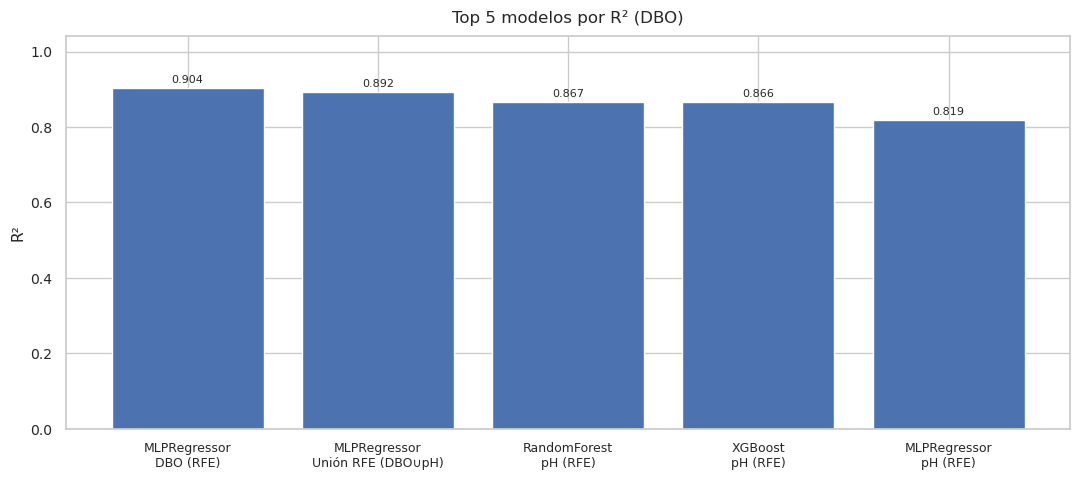

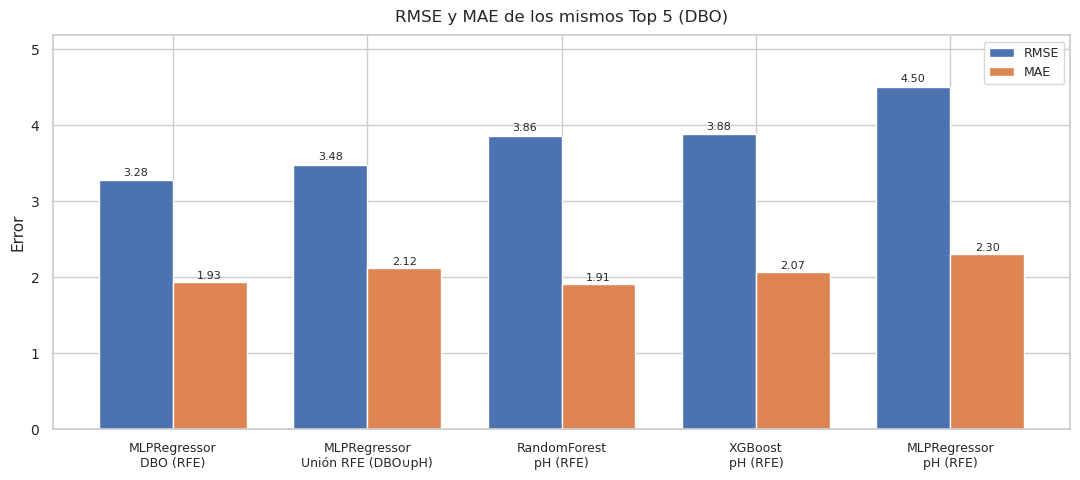

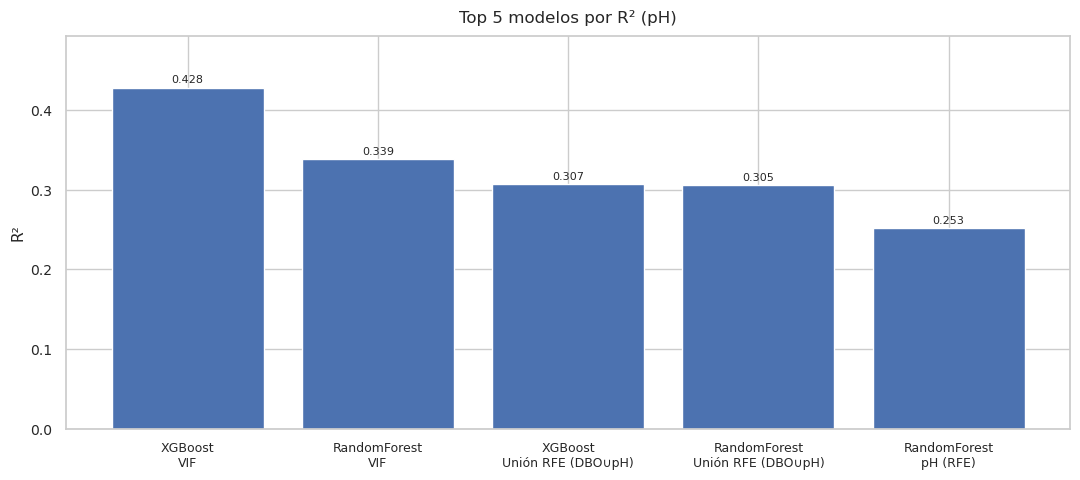

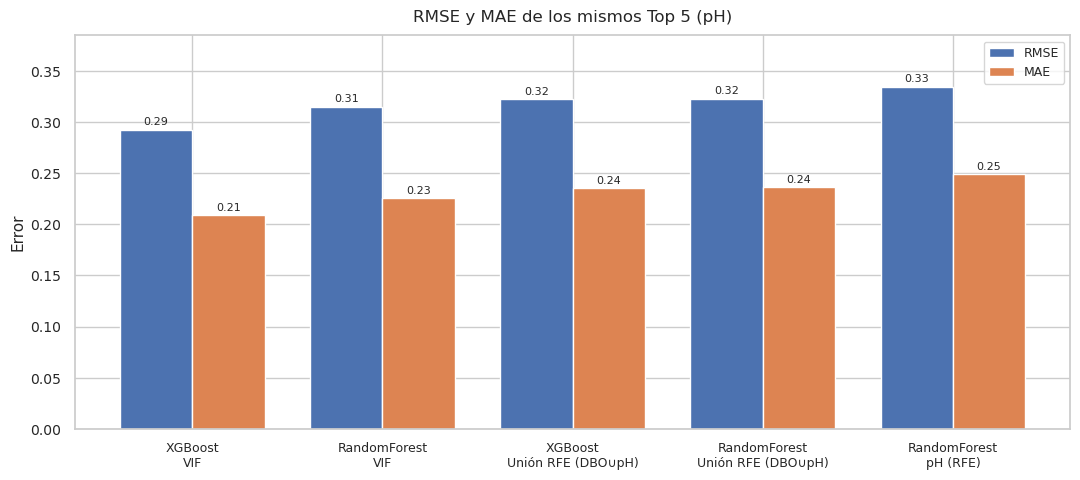

In [40]:
# 0) Fuente tipogr√°fica con buen soporte Unicode (‚à™)
plt.rcParams['font.family'] = 'DejaVu Sans'

# 1) Tomar la tabla de resultados (prefiere tuning si existe)
assert 'artefactos' in globals(), "Faltan artefactos; ejecuta primero el bloque de 4 escenarios"
resumen = artefactos.get('tabla_tuning_4esc', artefactos.get('resumen_global_4esc'))
assert resumen is not None, "No encontr√© resultados en artefactos"
resumen = resumen.copy()

# --- Helpers gen√©ricos --------------------------------------------------------

def _pick_objetivo(df, keyword_list):
    """
    Devuelve el primer nombre de objetivo en df['objetivo'] que matchee
    alguno de los keywords (case-insensitive). Ej: ['DBO','DEMANDA'] o ['PH'].
    """
    candidates = []
    for s in df['objetivo'].dropna().unique():
        su = str(s).upper()
        if any(k.upper() in su for k in keyword_list):
            candidates.append(s)
    return candidates[0] if candidates else None

def _display_text_factory(obj_alias, obj_real_name):
    """
    Devuelve una funci√≥n que reemplaza el nombre largo del objetivo real por un alias corto
    dentro del texto del escenario (para etiquetas).
    """
    def _f(s):
        t = str(s)
        return t.replace(str(obj_real_name), obj_alias)
    return _f

def _top5_por_r2(df, obj_name):
    """Filtra por objetivo, normaliza num√©ricos y devuelve Top-5 por R¬≤ (desc)."""
    d = df[df['objetivo'] == obj_name].copy()
    for c in ['R2','RMSE','MAE']:
        d[c] = pd.to_numeric(d[c], errors='coerce')
    d = d.dropna(subset=['R2']).sort_values('R2', ascending=False).head(5)
    return d

def _plot_top5_r2(d, titulo):
    x = np.arange(len(d))
    fig, ax = plt.subplots(figsize=(11,5), facecolor='white'); ax.set_facecolor('white')

    bars = ax.bar(x, d['R2'])
    ax.set_title(titulo, fontsize=12, pad=10)
    ax.set_ylabel("R¬≤", fontsize=11); ax.set_xlabel("")
    ax.set_xticks(x); ax.set_xticklabels(d['label'], fontsize=9)
    ax.tick_params(axis='y', labelsize=10)

    # Y din√°mico con headroom (cap a 1.05)
    y_max = float(d['R2'].max()) if len(d) else 1.0
    ax.set_ylim(0, min(1.05, (y_max * 1.15 if y_max > 0 else 0.1)))

    for b, v in zip(bars, d['R2'].to_numpy()):
        ax.text(b.get_x()+b.get_width()/2, b.get_height()*1.01, f"{v:.3f}",
                ha='center', va='bottom', fontsize=8)

    fig.subplots_adjust(bottom=0.22, top=0.88)
    plt.tight_layout(); plt.show()

def _plot_rmse_mae(d, titulo):
    x = np.arange(len(d)); w = 0.38
    fig, ax = plt.subplots(figsize=(11,5), facecolor='white'); ax.set_facecolor('white')

    b1 = ax.bar(x - w/2, d['RMSE'], width=w, label='RMSE')
    b2 = ax.bar(x + w/2, d['MAE'],  width=w, label='MAE')
    ax.set_title(titulo, fontsize=12, pad=10)
    ax.set_ylabel("Error", fontsize=11); ax.set_xlabel("")
    ax.set_xticks(x); ax.set_xticklabels(d['label'], fontsize=9)
    ax.tick_params(axis='y', labelsize=10); ax.legend(fontsize=9)

    y_max = float(np.nanmax([d['RMSE'].max(), d['MAE'].max()])) if len(d) else 1.0
    ax.set_ylim(0, y_max * 1.15 if y_max > 0 else 0.1)

    for bars, vals in [(b1, d['RMSE'].to_numpy()), (b2, d['MAE'].to_numpy())]:
        for b, v in zip(bars, vals):
            ax.text(b.get_x()+b.get_width()/2, b.get_height()*1.01, f"{v:.2f}",
                    ha='center', va='bottom', fontsize=8)

    fig.subplots_adjust(bottom=0.22, top=0.88)
    plt.tight_layout(); plt.show()

def _run_top5_for(df, keywords, alias):
    """
    Orquesta: detecta objetivo por keywords, arma labels y grafica Top-5 por R¬≤ y RMSE/MAE.
    keywords: lista de palabras clave para encontrar el objetivo (p.ej., ['DBO','DEMANDA'])
    alias: c√≥mo quieres que aparezca en t√≠tulos/etiquetas (p.ej., 'DBO' o 'pH')
    """
    obj_name = _pick_objetivo(df, keywords)
    if obj_name is None:
        print(f"No encontr√© objetivo '{alias}' en resultados.")
        return

    # Preparar top-5 y etiquetas
    disp = _display_text_factory(alias, obj_name)
    d = _top5_por_r2(df, obj_name)
    if d.empty:
        print(f"No hay resultados para el objetivo {alias}.")
        return
    d = d.assign(label=d['modelo'] + '\n' + d['escenario'].map(disp))

    # Graficar
    _plot_top5_r2(d, f"Top 5 modelos por R¬≤ ({alias})")
    _plot_rmse_mae(d, f"RMSE y MAE de los mismos Top 5 ({alias})")

# Ejecutar para DBO y pH en un mismo bloque

_run_top5_for(resumen, keywords=['DBO','DEMANDA'], alias='DBO')
_run_top5_for(resumen, keywords=['PH'], alias='pH')

# GRID SEARCH Y OPTUNA + diagn√≥stico

In [107]:
# ============================================================
# GRID SEARCH + OPTUNA (4 escenarios) + GRI_RMSE FINAL
# ¬∑ Reproducible, anti-overfit, compatible con splits fijos
# ¬∑ Mantiene nombres/llaves originales; a√±ade contrato robusto
# ============================================================

# --- Flags/entorno requeridos y constantes ---
try:
    HAS_XGB, HAS_OPTUNA = True, True
    _ = XGBRegressor  # importado en tu entorno
    _ = optuna
except Exception:
    HAS_XGB, HAS_OPTUNA = False, False

assert 'df_vif_filtered' in globals() and 'df_imputed' in globals()
assert 'objetivos' in globals() and 'rfe_resultados' in globals() and 'rfe_comun' in globals()

rng = 42
N_TRIALS = 40
EVITA_COOBJETIVO = True

# -------------------------
# Helpers de datos
# -------------------------
def _filtra_coobjetivo(X, y_col):
    if EVITA_COOBJETIVO and isinstance(objetivos, (list, tuple)) and len(objetivos) == 2:
        other = objetivos[0] if objetivos[1] == y_col else objetivos[1]
        if other in X.columns:
            X = X.drop(columns=[other])
    return X

def _build_xy_vif(y_col):
    X = df_vif_filtered.select_dtypes(include='number').copy()
    if y_col in X.columns:
        X = X.drop(columns=[y_col])
    X = _filtra_coobjetivo(X, y_col)
    y = df_imputed.loc[X.index, y_col].copy()
    m = y.notna()
    return X.loc[m], y.loc[m], list(X.columns)

def _build_xy_vars(y_col, feat_list):
    keep = [c for c in feat_list if c in df_vif_filtered.columns and c != y_col]
    X = df_vif_filtered.loc[:, keep].copy()
    X = _filtra_coobjetivo(X, y_col)
    y = df_imputed.loc[X.index, y_col].copy()
    m = y.notna()
    return X.loc[m], y.loc[m], list(X.columns)

# -------------------------
# Registro de modelos y grids
# -------------------------
def _registry_and_grids():
    reg = {
        "LinearRegression": Pipeline([("sc", StandardScaler()), ("m", LinearRegression())]),
        "DecisionTree (CART)": DecisionTreeRegressor(random_state=rng),
        "RandomForest": RandomForestRegressor(random_state=rng, n_jobs=1),
        "SVR (RBF)": Pipeline([("mx", MinMaxScaler()), ("m", SVR(kernel="rbf"))]),
        "MLPRegressor": Pipeline([("sc", StandardScaler()),
                                  ("m", MLPRegressor(max_iter=3000, random_state=rng))])
    }
    grids = {
        "LinearRegression": {"sc__with_mean":[True], "sc__with_std":[True]},
        "DecisionTree (CART)": {"max_depth":[4,6,8,12], "min_samples_split":[5,10], "min_samples_leaf":[2,4,8]},
        "RandomForest": {"n_estimators":[400,800], "max_depth":[8,12,16], "min_samples_leaf":[3,5,8], "max_features":["sqrt"]},
        "SVR (RBF)": {"m__C":[1.0,5.0,10.0], "m__epsilon":[0.05,0.1,0.2], "m__gamma":["scale","auto"]},
        "MLPRegressor": {"m__hidden_layer_sizes":[(64,32),(128,64,32)], "m__alpha":[1e-4,3e-4,1e-3], "m__activation":["relu","tanh"]}
    }
    if HAS_XGB:
        reg["XGBoost"] = XGBRegressor(random_state=rng, n_jobs=1, tree_method="hist", eval_metric="rmse")
        grids["XGBoost"] = {
            "n_estimators":[600,1000,1600,2200],
            "max_depth":[3,4,5,6],
            "learning_rate":[0.01,0.03,0.05,0.07],
            "subsample":[0.6,0.7,0.8,0.85],
            "colsample_bytree":[0.6,0.7,0.8,0.85],
            "min_child_weight":[3,5,8,10],
            "gamma":[0.0,0.1,0.3,0.5],
            "reg_lambda":[1.0,3.0,7.0,12.0],
            "reg_alpha":[0.0,0.05,0.1,0.5]
        }
    return reg, grids

# -------------------------
# Optuna objective ‚Äî RMSE
# -------------------------
def _optuna_objective(trial, Xtr, ytr):
    X_tr, X_val, y_tr, y_val = train_test_split(Xtr, ytr, test_size=0.2, shuffle=True, random_state=rng)
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 600, 2200, step=200),
        "max_depth": trial.suggest_int("max_depth", 3, 6),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.07, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 0.85),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 0.85),
        "min_child_weight": trial.suggest_int("min_child_weight", 3, 10),
        "gamma": trial.suggest_float("gamma", 0.0, 0.5),
        "reg_lambda": trial.suggest_float("reg_lambda", 1.0, 20.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "random_state": rng, "n_jobs": 1, "tree_method": "hist", "eval_metric": "rmse"
    }
    model = XGBRegressor(**params)
    try:
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], early_stopping_rounds=100, verbose=False)
    except TypeError:
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
    pr = model.predict(X_val)
    return root_mean_squared_error(y_val, pr)

# -------------------------
# B√∫squeda (Grid u Optuna)
# -------------------------
def _fit_with_search(name, base_est, grid, Xtr, Xte, ytr, yte):
    info = {}
    # XGB + Optuna
    if name == "XGBoost" and HAS_OPTUNA:
        study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=rng))
        study.optimize(lambda t: _optuna_objective(t, Xtr, ytr), n_trials=N_TRIALS, show_progress_bar=False)
        best_params = study.best_params
        best_est = XGBRegressor(**{**best_params, "random_state": rng, "n_jobs":1, "tree_method":"hist", "eval_metric":"rmse"})
        # reentrena en TRAIN completo (con validaci√≥n interna para early stopping si aplica)
        X_tr, X_val, y_tr, y_val = train_test_split(Xtr, ytr, test_size=0.2, shuffle=True, random_state=rng)
        try:
            best_est.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], early_stopping_rounds=100, verbose=False)
        except TypeError:
            best_est.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
        pred = best_est.predict(Xte)
        info = {"search":"optuna", "best_params":best_params, "study":study}
    else:
        # GridSearchCV (sobre TRAIN)
        kf = KFold(n_splits=3, shuffle=True, random_state=rng)
        gs = GridSearchCV(estimator=base_est, param_grid=grid,
                          scoring="neg_root_mean_squared_error",
                          cv=kf, n_jobs=1, refit=True)
        gs.fit(Xtr, ytr)
        best_est = gs.best_estimator_
        pred = best_est.predict(Xte)
        info = {"search":"grid", "best_params":gs.best_params_}

    # M√©tricas en TEST
    r2  = r2_score(yte, pred)
    rmse = root_mean_squared_error(yte, pred)
    mae  = mean_absolute_error(yte, pred)
    return best_est, info, r2, rmse, mae

# -------------------------
# Entrenamiento principal
# -------------------------
def entrenar_todo_4esc_tuning():
    dbo_obj, ph_obj = objetivos if len(objetivos)==2 else (objetivos[0], objetivos[0])
    esc = {
        "VIF": None,
        f"{dbo_obj} (RFE)": rfe_resultados[dbo_obj]["seleccion_mayoria"],
        f"{ph_obj} (RFE)":  rfe_resultados[ph_obj]["seleccion_mayoria"],
        "RFE DBO‚à™pH": (list(rfe_comun) if not (isinstance(rfe_comun, list) and len(rfe_comun)==0)
                       else sorted(list(set(rfe_resultados[dbo_obj]["seleccion_mayoria"]) |
                                        set(rfe_resultados[ph_obj]["seleccion_mayoria"])))),
    }
    reg, grids = _registry_and_grids()

    splits_fijos = (artefactos.get("splits_fijos") if 'artefactos' in globals() else None)
    splits = {}
    filas, modelos, metas = [], {}, {}

    for nombre_esc, feats in esc.items():
        for y_col in objetivos:
            # X,y
            if nombre_esc == "VIF":
                X, y, usadas = _build_xy_vif(y_col)
            else:
                X, y, usadas = _build_xy_vars(y_col, feats)
            if X.shape[1] == 0:
                continue
            X = X.sort_index(); y = y.loc[X.index]

            # split fijo o generado
            if splits_fijos and (y_col, nombre_esc) in splits_fijos:
                idx_tr, idx_te = splits_fijos[(y_col, nombre_esc)]
                Xtr, Xte, ytr, yte = X.loc[idx_tr], X.loc[idx_te], y.loc[idx_tr], y.loc[idx_te]
            else:
                Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=rng)
                splits[(y_col, nombre_esc)] = (Xtr.index, Xte.index)

            modelos[(y_col, nombre_esc)] = {}
            metas[(y_col, nombre_esc)]   = {}

            for mdl_name, base_est in reg.items():
                grid = grids.get(mdl_name, {})
                best_est, info, r2, rmse, mae = _fit_with_search(mdl_name, base_est, grid, Xtr, Xte, ytr, yte)

                # Fijar feature_names en XGB (para SHAP/consistencia)
                if HAS_XGB and isinstance(best_est, XGBRegressor):
                    try:
                        booster = best_est.get_booster()
                        booster.feature_names = usadas
                    except Exception:
                        pass

                # Guardado robusto: nested + clave plana (compat)
                modelos[(y_col, nombre_esc)][mdl_name] = {"est": best_est, "features": list(usadas)}
                modelos[(y_col, nombre_esc, mdl_name)] = best_est  # compatibilidad con c√≥digo previo

                metas[(y_col, nombre_esc)][mdl_name] = info

                filas.append({
                    "escenario": nombre_esc,
                    "objetivo": y_col,
                    "modelo": mdl_name,
                    "info": info["search"],
                    "R2": r2,
                    "RMSE": rmse,
                    "MAE": mae,
                    "n_vars": len(usadas),
                    "vars": ", ".join(usadas),
                    "best_params": info.get("best_params", {})
                })

    # tabla tuning
    tabla = (pd.DataFrame(filas)
             .sort_values(["escenario","objetivo","RMSE","MAE","R2","modelo"],
                          ascending=[True,True,True,True,False,True])
             .reset_index(drop=True))

    # escenarios_features (para compat) y splits finales
    esc_feats = {}
    for k, v in esc.items():
        if k == "VIF":
            esc_feats[k] = list(df_vif_filtered.select_dtypes(include='number').columns)
        else:
            esc_feats[k] = list(v)
    splits_final = splits_fijos if splits_fijos else splits

    return tabla, modelos, splits_final, metas, esc_feats

# -------------------------
# Ejecutar y guardar artefactos base
# -------------------------
tabla_tuning_4esc, modelos_tuning_4esc, splits_tuning_4esc, metas_tuning_4esc, escenarios_features = entrenar_todo_4esc_tuning()

artefactos = artefactos if 'artefactos' in globals() else {}
artefactos["tabla_tuning_4esc"]   = tabla_tuning_4esc
artefactos["modelos_tuning_4esc"] = modelos_tuning_4esc
artefactos["splits_tuning_4esc"]  = splits_tuning_4esc
artefactos["metas_tuning_4esc"]   = metas_tuning_4esc
artefactos["escenarios_features"] = escenarios_features

print("Tabla final de tuning (Grid + Optuna):")
display(tabla_tuning_4esc)

# ============================================================
# GRI_RMSE FINAL (solo este) ‚Äî train + CV + test
# ============================================================

# --- Normalizador (nombres con variantes)
def _canon(s: str) -> str:
    if s is None: return ""
    t = str(s).lower()
    rep = {'√°':'a','√©':'e','√≠':'i','√≥':'o','√∫':'u','√±':'n','‚à™':'u','¬∑':' ','‚Äî':' ','‚Äì':'-'}
    for k,v in rep.items(): t = t.replace(k,v)
    t = (t.replace('uni√≥n','union')
           .replace('(', ' ').replace(')', ' ')
           .replace('[',' ').replace(']',' ')
           .replace('{',' ').replace('}',' '))
    t = re.sub(r'\s+', ' ', t).strip()
    keep = re.sub(r'[^a-z0-9]', '', t)
    if ('rfedbouph' in keep) or ('dbouph' in keep):
        keep = 'unionrfedbouph'
    return keep

_split_keys = { (_canon(k[0]), _canon(k[1])): k for k in artefactos["splits_tuning_4esc"].keys() }
_feat_keys  = { _canon(k): k for k in artefactos["escenarios_features"].keys() }

def _find_split_key(obj, esc):
    key = (_canon(obj), _canon(esc))
    if key in _split_keys:
        return _split_keys[key]
    candidates = [orig for (co, ce), orig in _split_keys.items() if ce == key[1]]
    if len(candidates) == 1:
        return candidates[0]
    raise KeyError(f"No encuentro split can√≥nico para objetivo='{obj}', escenario='{esc}'")

def _find_feats_key(esc):
    c = _canon(esc)
    if c in _feat_keys:
        return _feat_keys[c]
    for k_can, k_orig in _feat_keys.items():
        if c in k_can or k_can in c:
            return k_orig
    if ('rfedbouph' in c) or ('dbouph' in c):
        for k_can, k_orig in _feat_keys.items():
            if 'unionrfedbouph' in k_can:
                return k_orig
    raise KeyError(f"No encuentro features para el escenario '{esc}'")

def _get_model_record(obj, esc, mdl):
    """Devuelve registro {'est','features'} si est√° disponible; si no, intenta compat antigua."""
    group = artefactos["modelos_tuning_4esc"].get((obj, esc), None)
    if isinstance(group, dict) and mdl in group:
        rec = group[mdl]
        if isinstance(rec, dict) and "est" in rec:
            return rec
        # compat muy antigua: group[mdl] era el estimador plano
        return {"est": rec, "features": artefactos["escenarios_features"][_find_feats_key(esc)]}
    # compat plana (obj,esc,mdl)
    est_flat = artefactos["modelos_tuning_4esc"].get((obj, esc, mdl))
    if est_flat is not None:
        return {"est": est_flat, "features": artefactos["escenarios_features"][_find_feats_key(esc)]}
    raise KeyError(f"No encuentro modelo para {(obj,esc,mdl)}")

def _build_xy_gri(obj, esc):
    """Usa features reales del modelo si existen; si no, cae a escenarios_features."""
    try:
        # probar recuperar cualquier modelo del combo para sacar su orden de features
        # (la tabla de tuning asegura que habr√° alguno; si no, cae al mapping de escenario)
        any_mdl = next(iter(artefactos["modelos_tuning_4esc"][(obj, esc)].keys()))
        feats = _get_model_record(obj, esc, any_mdl)["features"]
    except Exception:
        feats = artefactos["escenarios_features"][_find_feats_key(esc)]
    if esc == "VIF":
        X = df_vif_filtered.select_dtypes(include='number').copy()
        if obj in X.columns: X = X.drop(columns=[obj])
    else:
        X = df_vif_filtered.loc[:, [c for c in feats if c in df_vif_filtered.columns]].copy()
    X = _filtra_coobjetivo(X, obj)
    y = df_imputed.loc[X.index, obj].copy()
    m = y.notna()
    return X.loc[m].sort_index(), y.loc[m].sort_index()

def _resolve_split_gri(obj, esc, X, y):
    k = _find_split_key(obj, esc)
    s = artefactos["splits_tuning_4esc"][k]
    if isinstance(s, (tuple, list)) and len(s)==2:
        idx_tr, idx_te = s
        return X.loc[idx_tr], X.loc[idx_te], y.loc[idx_tr], y.loc[idx_te]
    if isinstance(s, dict) and all(u in s for u in ("X_train","X_test","y_train","y_test")):
        return s["X_train"], s["X_test"], s["y_train"], s["y_test"]
    raise TypeError(f"Formato inesperado de split para {k}: {type(s)}")

def _get_estimator_gri(obj, esc, mdl):
    rec = _get_model_record(obj, esc, mdl)
    return rec["est"]

def _gri_rmse(rmse_train, rmse_cv_mean, rmse_cv_std, rmse_test, eps=1e-9):
    gap   = abs(rmse_train - rmse_cv_mean) / (rmse_cv_mean + eps)   # sobreajuste
    stab  = rmse_cv_std / (rmse_cv_mean + eps)                      # inestabilidad
    rel   = rmse_test / (rmse_cv_mean + eps)                        # coherencia test/CV
    score = 1.0 / (rel * (1.0 + gap + stab) + eps)                  # mayor = mejor
    return float(score), float(gap), float(stab), float(rel)

def calcular_gri_final(cv_folds=3, cv_repeats=2, seed=42):
    df_res = artefactos["tabla_tuning_4esc"].copy()
    filas = []
    for _, r in df_res.iterrows():
        obj, esc, mdl = r['objetivo'], r['escenario'], r['modelo']

        X, y = _build_xy_gri(obj, esc)
        Xtr, Xte, ytr, yte = _resolve_split_gri(obj, esc, X, y)
        est = _get_estimator_gri(obj, esc, mdl)

        pr_tr = est.predict(Xtr); pr_te = est.predict(Xte)
        rmse_tr = root_mean_squared_error(ytr, pr_tr)
        rmse_te = root_mean_squared_error(yte, pr_te)
        r2_tr   = r2_score(ytr, pr_tr)
        r2_te   = r2_score(yte, pr_te)

        vals = []
        for rep in range(cv_repeats):
            kf = KFold(n_splits=cv_folds, shuffle=True, random_state=seed + rep)
            scores = cross_val_score(est, Xtr, ytr, scoring='neg_root_mean_squared_error', cv=kf, n_jobs=1)
            vals.extend(scores)
        rmse_cv = -np.array(vals, dtype=float)
        rmse_cv_mean = float(np.mean(rmse_cv))
        rmse_cv_std  = float(np.std(rmse_cv, ddof=1)) if len(rmse_cv) > 1 else 0.0

        gri, gap, stab, rel = _gri_rmse(rmse_tr, rmse_cv_mean, rmse_cv_std, rmse_te)

        filas.append({
            "objetivo": obj, "escenario": esc, "modelo": mdl,
            "RMSE_train": rmse_tr, "RMSE_CV_mean": rmse_cv_mean, "RMSE_CV_std": rmse_cv_std, "RMSE_test": rmse_te,
            "R2_train": r2_tr, "R2_test": r2_te,
            "gap_train_cv": gap, "cv_instability": stab, "test_vs_cv": rel,
            "GRI_RMSE": gri
        })

    gri_final = (pd.DataFrame(filas)
                 .sort_values(["objetivo","GRI_RMSE"], ascending=[True,False])
                 .reset_index(drop=True))

    tabla_gri = artefactos["tabla_tuning_4esc"].merge(
        gri_final[["objetivo","escenario","modelo","GRI_RMSE"]],
        on=["objetivo","escenario","modelo"],
        how="left"
    ).sort_values(["objetivo","GRI_RMSE"], ascending=[True,False]).reset_index(drop=True)

    artefactos["gri_final"]             = gri_final
    artefactos["tabla_tuning_4esc_gri"] = tabla_gri

    cols_finales = ['escenario','objetivo','modelo','info','R2','RMSE','MAE','GRI_RMSE','best_params']
    cols_finales = [c for c in cols_finales if c in tabla_gri.columns]
    tabla_final = (tabla_gri[cols_finales]
                   .copy()
                   .sort_values(['objetivo','GRI_RMSE'], ascending=[True,False])
                   .reset_index(drop=True))
    artefactos["tabla_resultados_final"] = tabla_final

    print("\nTabla GRI (detalle train‚ÄìCV‚Äìtest):")
    display(gri_final)
    print("\nTabla tuning + GRI_RMSE:")
    display(tabla_gri)
    print("\nTabla final simplificada (Optuna/Grid + GRI_RMSE):")
    display(tabla_final)

    return gri_final, tabla_gri, tabla_final

# Ejecutar c√°lculo GRI
gri_final, tabla_tuning_4esc_gri, tabla_resultados_final = calcular_gri_final(cv_folds=3, cv_repeats=2)


[I 2025-10-24 00:51:58,140] A new study created in memory with name: no-name-94060b4e-2f2f-406d-9195-0fa3582c127e
[I 2025-10-24 00:51:59,406] Trial 0 finished with value: 16.358830151088974 and parameters: {'n_estimators': 1200, 'max_depth': 6, 'learning_rate': 0.041553407742923563, 'subsample': 0.7496646210492591, 'colsample_bytree': 0.6390046601106091, 'min_child_weight': 4, 'gamma': 0.02904180608409973, 'reg_lambda': 13.39433470675048, 'reg_alpha': 0.6011150117432088}. Best is trial 0 with value: 16.358830151088974.
[I 2025-10-24 00:52:00,440] Trial 1 finished with value: 15.845963181134746 and parameters: {'n_estimators': 1800, 'max_depth': 3, 'learning_rate': 0.06601899594641057, 'subsample': 0.8081106602001054, 'colsample_bytree': 0.653084777669569, 'min_child_weight': 4, 'gamma': 0.09170225492671691, 'reg_lambda': 2.4878734419814426, 'reg_alpha': 0.5247564316322378}. Best is trial 1 with value: 15.845963181134746.
[I 2025-10-24 00:52:01,125] Trial 2 finished with value: 16.44669

Tabla final de tuning (Grid + Optuna):


escenario  \
0   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
1   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
2   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
3   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
4   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
5   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
6   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
7   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
8   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
9   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
10  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
11  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
12                                     RFE DBO‚à™pH   
13                                     RFE DBO‚à™pH   
14                                     RFE DBO‚à™pH   
15                                     RFE DBO‚à™pH   
16                                     RFE DBO‚à™pH   
17                                     RFE DBO‚à™pH   
18                                     RFE DBO‚à™pH   
19                                     RFE DBO‚à™pH   
20                                     RFE DBO‚à™pH   
21                                     RFE DBO‚à™pH   
22                                     RFE DBO‚à™pH   
23                                     RFE DBO‚à™pH   
24                                            VIF   
25                                            VIF   
26                                            VIF   
27                                            VIF   
28                                            VIF   
29                                            VIF   
30                                            VIF   
31                                            VIF   
32                                            VIF   
33                                            VIF   
34                                            VIF   
35                                            VIF   
36                                       pH (RFE)   
37                                       pH (RFE)   
38                                       pH (RFE)   
39                                       pH (RFE)   
40                                       pH (RFE)   
41                                       pH (RFE)   
42                                       pH (RFE)   
43                                       pH (RFE)   
44                                       pH (RFE)   
45                                       pH (RFE)   
46                                       pH (RFE)   
47                                       pH (RFE)   

                                   objetivo               modelo    info  \
0   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)         MLPRegressor    grid   
1   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)         RandomForest    grid   
2   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)              XGBoost  optuna   
3   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)     LinearRegression    grid   
4   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)            SVR (RBF)    grid   
5   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)  DecisionTree (CART)    grid   
6                                        pH              XGBoost  optuna   
7                                        pH         RandomForest    grid   
8                                        pH            SVR (RBF)    grid   
9                                        pH  DecisionTree (CART)    grid   
10                                       pH         MLPRegressor    grid   
11                                       pH     LinearRegression    grid   
12  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)         MLPRegressor    grid   
13  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)         RandomForest    grid   
14  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)            SVR (RBF)    grid   
15  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)              XGBoost  optuna   
16  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)     LinearRegression    grid   
17  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)  Decis


Tabla GRI (detalle train‚ÄìCV‚Äìtest):


objetivo  \
0   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)   
1   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)   
2   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)   
3   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)   
4   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)   
5   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)   
6   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)   
7   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)   
8   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)   
9   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)   
10  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)   
11  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)   
12  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)   
13  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)   
14  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)   
15  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)   
16  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)   
17  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)   
18  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)   
19  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)   
20  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)   
21  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)   
22  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)   
23  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)   
24                                       pH   
25                                       pH   
26                                       pH   
27                                       pH   
28                                       pH   
29                                       pH   
30                                       pH   
31                                       pH   
32                                       pH   
33                                       pH   
34                                       pH   
35                                       pH   
36                                       pH   
37                                       pH   
38                                       pH   
39                                       pH   
40                                       pH   
41                                       pH   
42                                       pH   
43                                       pH   
44                                       pH   
45                                       pH   
46                                       pH   
47                                       pH   

                                        escenario               modelo  \
0                                        pH (RFE)         RandomForest   
1                                      RFE DBO‚à™pH         MLPRegressor   
2                                             VIF         RandomForest   
3                                      RFE DBO‚à™pH         RandomForest   
4                                        pH (RFE)         MLPRegressor   
5   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)         MLPRegressor   
6                                             VIF            SVR (RBF)   
7                                      RFE DBO‚à™pH            SVR (RBF)   
8                                             VIF         MLPRegressor   
9                                             VIF     LinearRegression   
10                                       pH (RFE)              XGBoost   
11  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)         RandomForest   
12  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)     LinearRegression   
13                                     RFE DBO‚à™pH     LinearRegression   
14  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)            SVR (RBF)   
15  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)              XGBoost   
16                                       pH (RFE)     LinearRegression   
17                                       pH (RFE)            SVR (RBF)   
18                                            VIF              XGBoost   
19                                     RFE DBO‚à™pH              XGBoost   
20                                     RFE DBO‚à™pH  DecisionTree (CART)   
21                                       pH (RFE)  DecisionTree (CART)   
22  DEMANDA BIOQU


Tabla tuning + GRI_RMSE:


escenario  \
0                                        pH (RFE)   
1                                      RFE DBO‚à™pH   
2                                             VIF   
3                                      RFE DBO‚à™pH   
4                                        pH (RFE)   
5   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
6                                             VIF   
7                                      RFE DBO‚à™pH   
8                                             VIF   
9                                             VIF   
10                                       pH (RFE)   
11  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
12  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
13                                     RFE DBO‚à™pH   
14  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
15  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
16                                       pH (RFE)   
17                                       pH (RFE)   
18                                            VIF   
19                                     RFE DBO‚à™pH   
20                                     RFE DBO‚à™pH   
21                                       pH (RFE)   
22  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
23                                            VIF   
24                                       pH (RFE)   
25                                     RFE DBO‚à™pH   
26                                            VIF   
27  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
28  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
29                                       pH (RFE)   
30                                            VIF   
31                                            VIF   
32                                     RFE DBO‚à™pH   
33  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
34  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
35                                       pH (RFE)   
36                                     RFE DBO‚à™pH   
37                                     RFE DBO‚à™pH   
38                                       pH (RFE)   
39  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
40                                            VIF   
41  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
42                                       pH (RFE)   
43                                       pH (RFE)   
44                                            VIF   
45                                     RFE DBO‚à™pH   
46                                     RFE DBO‚à™pH   
47                                            VIF   

                                   objetivo               modelo    info  \
0   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)         RandomForest    grid   
1   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)         MLPRegressor    grid   
2   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)         RandomForest    grid   
3   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)         RandomForest    grid   
4   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)         MLPRegressor    grid   
5   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)         MLPRegressor    grid   
6   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)            SVR (RBF)    grid   
7   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)            SVR (RBF)    grid   
8   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)         MLPRegressor    grid   
9   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)     LinearRegression    grid   
10  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)              XGBoost  optuna   
11  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)         RandomForest    grid   
12  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)     LinearRegression    grid   
13  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)     LinearRegression    grid   
14  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)            SVR (RBF)    grid   
15  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)              XGBoost  optuna   
16  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)     LinearRegression    grid   
17  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)       


Tabla final simplificada (Optuna/Grid + GRI_RMSE):


escenario  \
0                                        pH (RFE)   
1                                      RFE DBO‚à™pH   
2                                             VIF   
3                                      RFE DBO‚à™pH   
4                                        pH (RFE)   
5   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
6                                             VIF   
7                                      RFE DBO‚à™pH   
8                                             VIF   
9                                             VIF   
10                                       pH (RFE)   
11  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
12  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
13                                     RFE DBO‚à™pH   
14  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
15  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
16                                       pH (RFE)   
17                                       pH (RFE)   
18                                            VIF   
19                                     RFE DBO‚à™pH   
20                                     RFE DBO‚à™pH   
21                                       pH (RFE)   
22  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
23                                            VIF   
24                                       pH (RFE)   
25                                     RFE DBO‚à™pH   
26                                            VIF   
27  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
28  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
29                                       pH (RFE)   
30                                            VIF   
31                                            VIF   
32                                     RFE DBO‚à™pH   
33  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
34  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
35                                       pH (RFE)   
36                                     RFE DBO‚à™pH   
37                                     RFE DBO‚à™pH   
38                                       pH (RFE)   
39  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
40                                            VIF   
41  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)   
42                                       pH (RFE)   
43                                       pH (RFE)   
44                                            VIF   
45                                     RFE DBO‚à™pH   
46                                     RFE DBO‚à™pH   
47                                            VIF   

                                   objetivo               modelo    info  \
0   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)         RandomForest    grid   
1   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)         MLPRegressor    grid   
2   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)         RandomForest    grid   
3   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)         RandomForest    grid   
4   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)         MLPRegressor    grid   
5   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)         MLPRegressor    grid   
6   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)            SVR (RBF)    grid   
7   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)            SVR (RBF)    grid   
8   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)         MLPRegressor    grid   
9   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)     LinearRegression    grid   
10  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)              XGBoost  optuna   
11  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)         RandomForest    grid   
12  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)     LinearRegression    grid   
13  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)     LinearRegression    grid   
14  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)            SVR (RBF)    grid   
15  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)              XGBoost  optuna   
16  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)     LinearRegression    grid   
17  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)       


Top 5 curado ‚Äî DBO:


escenario        modelo    info  \
0                                     RFE DBO‚à™pH       XGBoost  optuna   
1                                            VIF       XGBoost  optuna   
2  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)       XGBoost  optuna   
3  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)  RandomForest    grid   
4                                       pH (RFE)       XGBoost  optuna   

   GRI_RMSE        R2      RMSE       MAE  
0  1.092925  0.667627  6.101894  2.383026  
1  1.134902  0.648961  6.270898  2.009546  
2  1.188756  0.659600  6.175144  2.487772  
3  1.259877  0.724872  5.551612  2.307435  
4  1.267573  0.657649  6.192813  2.469935

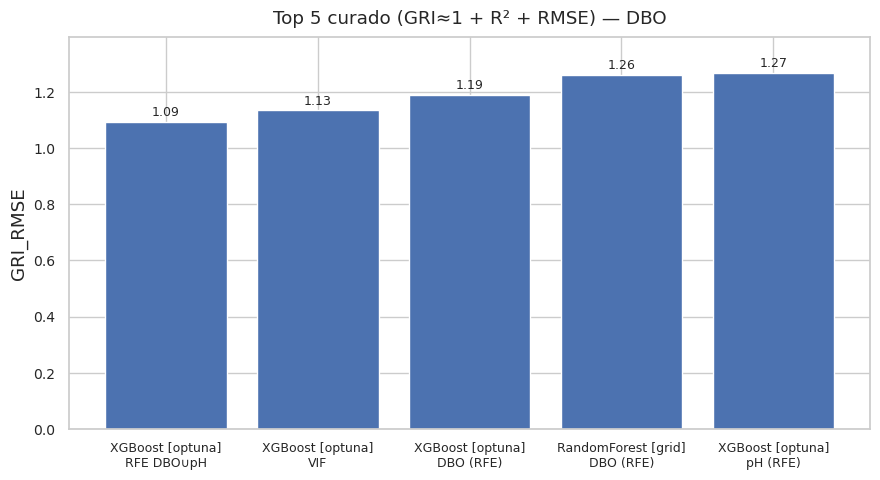


Top 5 curado ‚Äî pH:


escenario            modelo    info  GRI_RMSE        R2      RMSE  \
0    pH (RFE)           XGBoost  optuna  0.998531  0.252425  0.334540   
1         VIF      MLPRegressor    grid  0.994686  0.209546  0.344000   
2         VIF  LinearRegression    grid  0.990798  0.188789  0.348487   
3         VIF         SVR (RBF)    grid  1.029923  0.263676  0.332013   
4  RFE DBO‚à™pH         SVR (RBF)    grid  1.033283  0.196279  0.346875   

        MAE  
0  0.251188  
1  0.260501  
2  0.262555  
3  0.246778  
4  0.262573

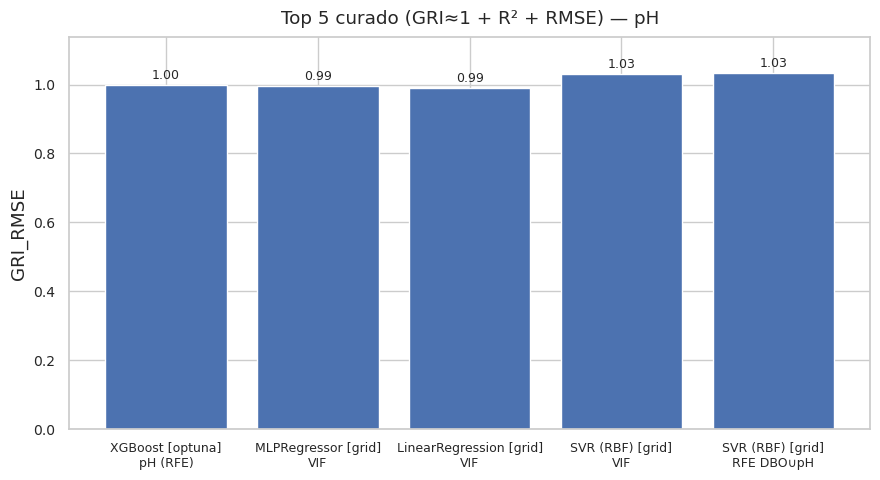

In [108]:
# === Top-5 CURADO (DBO y pH) por GRI‚âà1 + R¬≤ + RMSE ===
# Requiere: artefactos con tabla_resultados_final o tabla_tuning_4esc[_gri] y, si hace falta, gri_final.

plt.rcParams['font.family'] = 'DejaVu Sans'

assert 'artefactos' in globals(), "Faltan artefactos; ejecuta el bloque de tuning + GRI."

# 0) Cargar resultados y asegurar GRI_RMSE

def _load_results_with_gri(artefactos):
    # Obtiene la primera tabla disponible sin usar "or" entre DataFrames
    df = artefactos.get('tabla_resultados_final')
    if df is None:
        df = artefactos.get('tabla_tuning_4esc_gri')
    if df is None:
        df = artefactos.get('tabla_tuning_4esc')

    assert df is not None, "No encontr√© tabla de resultados en artefactos."
    df = df.copy()

    # Asegura columna GRI_RMSE fusionando desde gri_final si faltara
    if ('GRI_RMSE' not in df.columns) or df['GRI_RMSE'].isna().all():
        gri_det = artefactos.get('gri_final')
        if gri_det is not None:
            df = df.merge(
                gri_det[['objetivo','escenario','modelo','GRI_RMSE']],
                on=['objetivo','escenario','modelo'],
                how='left'
            )

    # Tipos num√©ricos
    for c in ('GRI_RMSE','R2','RMSE','MAE'):
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')
    return df


df_all = _load_results_with_gri(artefactos)

# 1) Utilidades de alias y labels

def _alias_obj(objetivo: str) -> str:
    s = str(objetivo)
    if ('DBO' in s.upper()) or ('DEMANDA' in s.upper()):
        return 'DBO'
    if 'PH' in s.upper():
        return 'pH'
    return s

def _alias_en_escenario(objetivo: str, escenario: str) -> str:
    """Reemplaza el nombre largo del objetivo dentro del texto del escenario por su alias (DBO/pH)."""
    ali = _alias_obj(objetivo)
    return str(escenario).replace(str(objetivo), ali)

# 2) Selecci√≥n CURADA (filtros + score compuesto)

def _select_topk_curado(df_obj, k=5,
                        gri_range=(0.95, 1.60),
                        min_r2=0.60,
                        w_gri=0.50, w_r2=0.35, w_rmse=0.15,
                        allow_outlier_slot=True,
                        relax_steps=((0.90,1.75,0.55),
                                     (0.85,1.90,0.50),
                                     (0.80,2.10,0.45))):
    """
    df_obj: DataFrame ya filtrado por 'objetivo'.
    1) Filtro inicial: GRI en rango, R¬≤ >= min_r2.
    2) Score compuesto:    score = w_gri*(1/|GRI-1|) + w_r2*(R2) - w_rmse*(RMSE / mediana_RMSE)
    3) Si no alcanza k, se relaja gradualmente (relax_steps).
    4) allow_outlier_slot: si queda hueco, a√±ade 1 mejor por RMSE aunque GRI salga del rango (como referencia).
    """
    d = df_obj.copy()
    d = d.dropna(subset=['GRI_RMSE','R2','RMSE'])

    if d.empty:
        return d

    # Reglas m√≠nimas base
    lo, hi = gri_range
    d_f = d[(d['GRI_RMSE'] >= lo) & (d['GRI_RMSE'] <= hi) & (d['R2'] >= min_r2)].copy()

    # Relajar si no hay suficientes
    step_idx = 0
    while len(d_f) < min(k, len(d)) and step_idx < len(relax_steps):
        lo2, hi2, r2min2 = relax_steps[step_idx]
        d_f = d[(d['GRI_RMSE'] >= lo2) & (d['GRI_RMSE'] <= hi2) & (d['R2'] >= r2min2)].copy()
        step_idx += 1

    # Si a√∫n no alcanza, usar todo y rankear (√∫ltimo recurso)
    if len(d_f) == 0:
        d_f = d.copy()

    # Score compuesto
    eps = 1e-9
    rmse_med = max(d_f['RMSE'].median(), eps)
    d_f['score_compuesto'] = (w_gri * (1.0 / (np.abs(d_f['GRI_RMSE'] - 1.0) + eps))
                              + w_r2 * d_f['R2']
                              - w_rmse * (d_f['RMSE'] / rmse_med))

    d_f = d_f.sort_values(['score_compuesto','GRI_RMSE','R2'],
                          ascending=[False, False, False]).head(k).copy()

    # A√±adir 1 "outlier de referencia" si se permite y seguimos por debajo de k
    if allow_outlier_slot and len(d_f) < k:
        # mejor RMSE global que no est√© ya en la lista
        resto = d.drop(d_f.index, errors='ignore')
        if not resto.empty:
            outlier = resto.sort_values('RMSE', ascending=True).head(1)
            d_f = pd.concat([d_f, outlier], ignore_index=True)

    # Reordenar por score (bonito)
    d_f = d_f.sort_values('score_compuesto', ascending=False).head(k).reset_index(drop=True)
    return d_f

# 3) Armado de Top-5 por objetivo (DBO / pH) y gr√°ficos

def _plot_top_curado(df, objetivo, topk, titulo_alias):
    if topk.empty:
        print(f"[Aviso] No hay candidatos para {titulo_alias}.")
        return

    labels = []
    for _, r in topk.iterrows():
        src = f" [{r['info']}]" if 'info' in topk.columns else ""
        lbl = f"{r['modelo']}{src}\n{_alias_en_escenario(objetivo, r['escenario'])}"
        labels.append(lbl)

    x = np.arange(len(topk))
    fig, ax = plt.subplots(figsize=(9,5))
    
    # Solo barras de GRI_RMSE
    bars = ax.bar(x, topk['GRI_RMSE'], color="#4C72B0")
    
    # T√≠tulo y etiquetas
    ax.set_title(f"Top {len(topk)} curado (GRI‚âà1 + R¬≤ + RMSE) ‚Äî {titulo_alias}", pad=10)
    ax.set_ylabel("GRI_RMSE")
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=9)
    ax.tick_params(axis='y', labelsize=10)

    # Rango din√°mico del eje Y
    y_max = float(topk['GRI_RMSE'].max())
    ax.set_ylim(0, max(1.0, y_max * 1.10))

    # Etiquetas de valor encima de cada barra
    for b, v in zip(bars, topk['GRI_RMSE'].to_numpy()):
        ax.text(b.get_x()+b.get_width()/2, b.get_height()*1.01, f"{v:.2f}",
                ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

def _build_and_plot_curado(df_all, objetivo, k=5):
    alias = _alias_obj(objetivo)
    d = df_all[df_all['objetivo']==objetivo].copy()
    # R¬≤ m√≠nimo distinto para pH si fuera necesario
    min_r2 = 0.60 if alias == 'DBO' else 0.15

    topk = _select_topk_curado(
        d, k=k,
        gri_range=(0.95, 1.60),
        min_r2=min_r2,
        w_gri=0.50, w_r2=0.35, w_rmse=0.15,
        allow_outlier_slot=True
    )

    # Mostrar tabla elegida (√∫til para reporte)
    cols = ['escenario','modelo','info','GRI_RMSE','R2','RMSE','MAE']
    print(f"\nTop {len(topk)} curado ‚Äî {alias}:")
    display(topk[[c for c in cols if c in topk.columns]])

    _plot_top_curado(df_all, objetivo, topk, alias)

# 4) Detectar nombres exactos de objetivos y ejecutar

objs = list(pd.Series(df_all['objetivo'].dropna().unique()))
dbo_obj = next((s for s in objs if ('DBO' in str(s)) or ('DEMANDA' in str(s))), None)
ph_obj  = next((s for s in objs if 'PH' in str(s).upper()), None)

if dbo_obj:
    _build_and_plot_curado(df_all, dbo_obj, k=5)
else:
    print("[Aviso] No detect√© objetivo DBO en la tabla.")

if ph_obj:
    _build_and_plot_curado(df_all, ph_obj, k=5)
else:
    print("[Aviso] No detect√© objetivo pH en la tabla.")


Top 5 curado ‚Äî DBO:


escenario        modelo    info  \
0                                     RFE DBO‚à™pH       XGBoost  optuna   
1                                            VIF       XGBoost  optuna   
2  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)       XGBoost  optuna   
3  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)  RandomForest    grid   
4                                       pH (RFE)       XGBoost  optuna   

   GRI_RMSE        R2      RMSE       MAE  
0  1.092925  0.667627  6.101894  2.383026  
1  1.134902  0.648961  6.270898  2.009546  
2  1.188756  0.659600  6.175144  2.487772  
3  1.259877  0.724872  5.551612  2.307435  
4  1.267573  0.657649  6.192813  2.469935

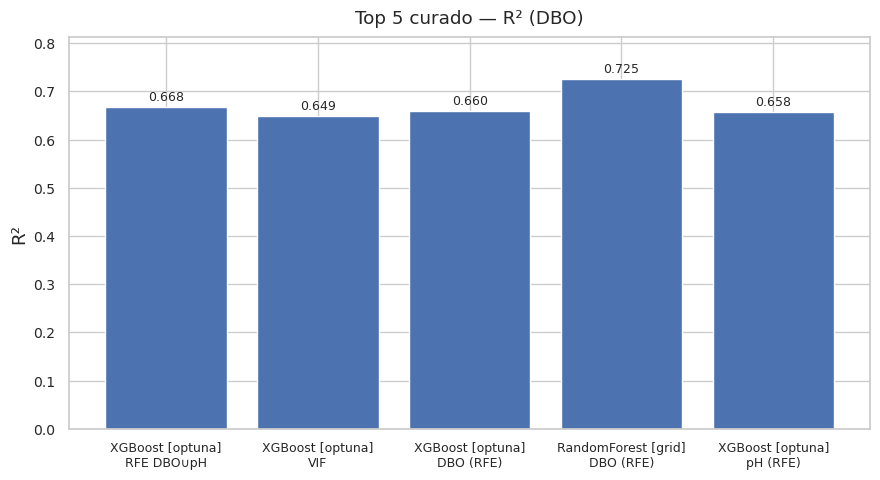

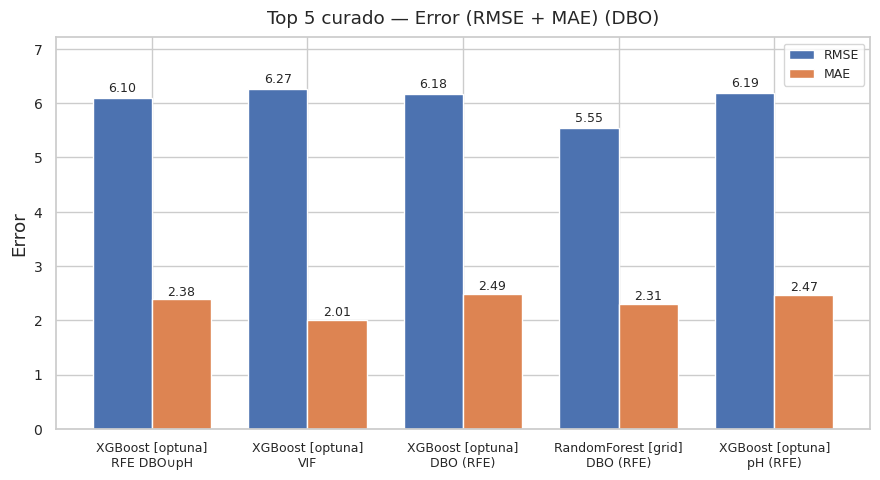


Top 5 curado ‚Äî pH:


escenario            modelo    info  GRI_RMSE        R2      RMSE  \
0    pH (RFE)           XGBoost  optuna  0.998531  0.252425  0.334540   
1         VIF      MLPRegressor    grid  0.994686  0.209546  0.344000   
2         VIF  LinearRegression    grid  0.990798  0.188789  0.348487   
3         VIF         SVR (RBF)    grid  1.029923  0.263676  0.332013   
4  RFE DBO‚à™pH         SVR (RBF)    grid  1.033283  0.196279  0.346875   

        MAE  
0  0.251188  
1  0.260501  
2  0.262555  
3  0.246778  
4  0.262573

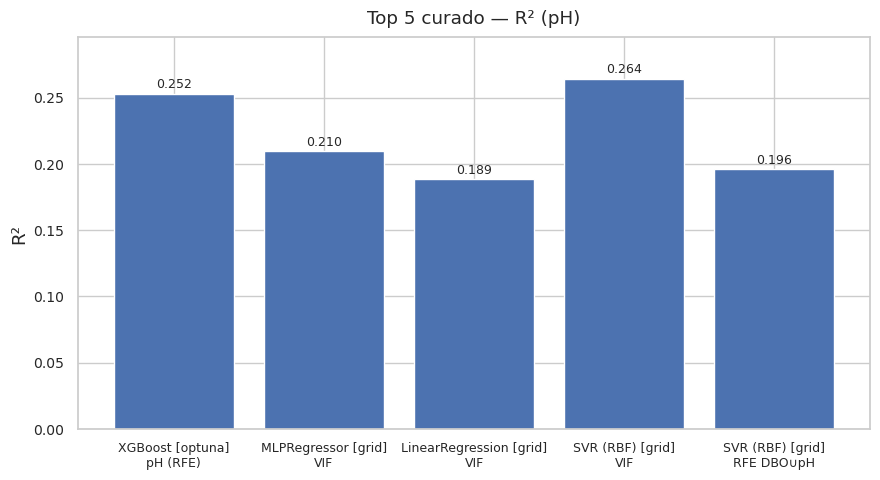

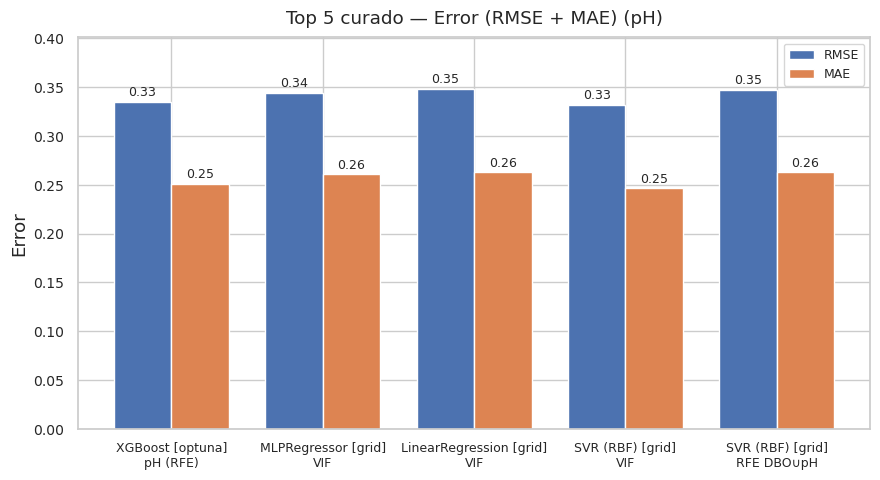

In [109]:
# TOP-5 CURADO  ‚Üí  GR√ÅFICAS R¬≤ y RMSE+MAE (sin GRI)

plt.rcParams['font.family'] = 'DejaVu Sans'

assert 'artefactos' in globals(), "Faltan artefactos; ejecuta el bloque de tuning + GRI."

# 0) Cargar resultados y asegurar tipos num√©ricos

def _load_results_with_gri(artefactos):
    df = artefactos.get('tabla_resultados_final')
    if df is None:
        df = artefactos.get('tabla_tuning_4esc_gri')
    if df is None:
        df = artefactos.get('tabla_tuning_4esc')
    assert df is not None, "No encontr√© tabla de resultados en artefactos."
    df = df.copy()

    # Si no hay GRI_RMSE, lo fusionamos por si lo quieres usar en la tabla
    if ('GRI_RMSE' not in df.columns) or df['GRI_RMSE'].isna().all():
        gri_det = artefactos.get('gri_final')
        if gri_det is not None:
            df = df.merge(
                gri_det[['objetivo','escenario','modelo','GRI_RMSE']],
                on=['objetivo','escenario','modelo'],
                how='left'
            )

    for c in ('GRI_RMSE','R2','RMSE','MAE'):
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')
    return df

df_all = _load_results_with_gri(artefactos)

# 1) Utilidades de alias y etiquetas

def _alias_obj(objetivo: str) -> str:
    s = str(objetivo)
    if ('DBO' in s.upper()) or ('DEMANDA' in s.upper()):
        return 'DBO'
    if 'PH' in s.upper():
        return 'pH'
    return s

def _alias_en_escenario(objetivo: str, escenario: str) -> str:
    """Reemplaza el nombre largo del objetivo dentro del texto del escenario por su alias (DBO/pH)."""
    ali = _alias_obj(objetivo)
    return str(escenario).replace(str(objetivo), ali)

# 2) Selecci√≥n CURADA (filtros + score compuesto) ‚Äî la misma l√≥gica que ven√≠as usando

def _select_topk_curado(df_obj, k=5,
                        gri_range=(0.95, 1.60),
                        min_r2=0.60,
                        w_gri=0.50, w_r2=0.35, w_rmse=0.15,
                        allow_outlier_slot=True,
                        relax_steps=((0.90,1.75,0.55),
                                     (0.85,1.90,0.50),
                                     (0.80,2.10,0.45))):
    d = df_obj.copy().dropna(subset=['GRI_RMSE','R2','RMSE'])
    if d.empty:
        return d

    lo, hi = gri_range
    d_f = d[(d['GRI_RMSE'] >= lo) & (d['GRI_RMSE'] <= hi) & (d['R2'] >= min_r2)].copy()

    step_idx = 0
    while len(d_f) < min(k, len(d)) and step_idx < len(relax_steps):
        lo2, hi2, r2min2 = relax_steps[step_idx]
        d_f = d[(d['GRI_RMSE'] >= lo2) & (d['GRI_RMSE'] <= hi2) & (d['R2'] >= r2min2)].copy()
        step_idx += 1

    if len(d_f) == 0:
        d_f = d.copy()

    eps = 1e-9
    rmse_med = max(d_f['RMSE'].median(), eps)
    d_f['score_compuesto'] = (w_gri * (1.0 / (np.abs(d_f['GRI_RMSE'] - 1.0) + eps))
                              + w_r2 * d_f['R2']
                              - w_rmse * (d_f['RMSE'] / rmse_med))

    d_f = d_f.sort_values(['score_compuesto','GRI_RMSE','R2'],
                          ascending=[False, False, False]).head(k).copy()

    if allow_outlier_slot and len(d_f) < k:
        resto = d.drop(d_f.index, errors='ignore')
        if not resto.empty:
            outlier = resto.sort_values('RMSE', ascending=True).head(1)
            d_f = pd.concat([d_f, outlier], ignore_index=True)

    return d_f.sort_values('score_compuesto', ascending=False).head(k).reset_index(drop=True)

# 3) Gr√°ficas pedidas (R¬≤ y RMSE+MAE)

def _plot_top_r2(objetivo, topk, titulo_alias):
    if topk.empty:
        print(f"[Aviso] No hay candidatos para {titulo_alias}.")
        return

    labels = []
    for _, r in topk.iterrows():
        src = f" [{r['info']}]" if 'info' in topk.columns else ""
        labels.append(f"{r['modelo']}{src}\n{_alias_en_escenario(objetivo, r['escenario'])}")

    x = np.arange(len(topk))
    fig, ax = plt.subplots(figsize=(9,5))
    bars = ax.bar(x, topk['R2'], color="#4C72B0")

    ax.set_title(f"Top {len(topk)} curado ‚Äî R¬≤ ({titulo_alias})", pad=10)
    ax.set_ylabel("R¬≤")
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=9)
    ax.tick_params(axis='y', labelsize=10)

    y_max = float(topk['R2'].max()) if len(topk) else 1.0
    ax.set_ylim(0, min(1.05, max(0.1, y_max * 1.12)))

    for b, v in zip(bars, topk['R2'].to_numpy()):
        ax.text(b.get_x()+b.get_width()/2, b.get_height()*1.01, f"{v:.3f}",
                ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    plt.show()

def _plot_top_rmse_mae(objetivo, topk, titulo_alias):
    if topk.empty:
        print(f"[Aviso] No hay candidatos para {titulo_alias}.")
        return

    labels = []
    for _, r in topk.iterrows():
        src = f" [{r['info']}]" if 'info' in topk.columns else ""
        labels.append(f"{r['modelo']}{src}\n{_alias_en_escenario(objetivo, r['escenario'])}")

    x = np.arange(len(topk))
    w = 0.38
    fig, ax = plt.subplots(figsize=(9,5))
    b1 = ax.bar(x - w/2, topk['RMSE'], width=w, label='RMSE')
    b2 = ax.bar(x + w/2, topk['MAE'],  width=w, label='MAE')

    ax.set_title(f"Top {len(topk)} curado ‚Äî Error (RMSE + MAE) ({titulo_alias})", pad=10)
    ax.set_ylabel("Error")
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=9)
    ax.tick_params(axis='y', labelsize=10)
    ax.legend(fontsize=9)

    y_max = float(np.nanmax([topk['RMSE'].max(), topk['MAE'].max()])) if len(topk) else 1.0
    ax.set_ylim(0, max(0.1, y_max * 1.15))

    for bars, vals in [(b1, topk['RMSE'].to_numpy()), (b2, topk['MAE'].to_numpy())]:
        for b, v in zip(bars, vals):
            ax.text(b.get_x()+b.get_width()/2, b.get_height()*1.01, f"{v:.2f}",
                    ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    plt.show()

# 4) Construye Top-5 y dibuja (para DBO y pH)

def _build_and_plot_curado(df_all, objetivo, k=5):
    alias = _alias_obj(objetivo)
    d = df_all[df_all['objetivo']==objetivo].copy()
    min_r2 = 0.60 if alias == 'DBO' else 0.15   # ajusta si quieres otro umbral para pH

    topk = _select_topk_curado(
        d, k=k,
        gri_range=(0.95, 1.60),
        min_r2=min_r2,
        w_gri=0.50, w_r2=0.35, w_rmse=0.15,
        allow_outlier_slot=True
    )

    # Tabla para el reporte
    cols = ['escenario','modelo','info','GRI_RMSE','R2','RMSE','MAE']
    print(f"\nTop {len(topk)} curado ‚Äî {alias}:")
    display(topk[[c for c in cols if c in topk.columns]])

    # Gr√°ficas pedidas
    _plot_top_r2(objetivo, topk, alias)
    _plot_top_rmse_mae(objetivo, topk, alias)


# 5) Detectar nombres exactos de objetivos y ejecutar

objs = list(pd.Series(df_all['objetivo'].dropna().unique()))
dbo_obj = next((s for s in objs if ('DBO' in str(s)) or ('DEMANDA' in str(s))), None)
ph_obj  = next((s for s in objs if 'PH' in str(s).upper()), None)

if dbo_obj:
    _build_and_plot_curado(df_all, dbo_obj, k=5)
else:
    print("[Aviso] No detect√© objetivo DBO en la tabla.")

if ph_obj:
    _build_and_plot_curado(df_all, ph_obj, k=5)
else:
    print("[Aviso] No detect√© objetivo pH en la tabla.")

# Fase 4. Evaluaci√≥n de modelos


Top 5 curado ‚Äî DBO:


escenario        modelo    info  \
0                                     RFE DBO‚à™pH       XGBoost  optuna   
1                                            VIF       XGBoost  optuna   
2  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)       XGBoost  optuna   
3  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)  RandomForest    grid   
4                                       pH (RFE)       XGBoost  optuna   

   GRI_RMSE        R2      RMSE       MAE  
0  1.092925  0.667627  6.101894  2.383026  
1  1.134902  0.648961  6.270898  2.009546  
2  1.188756  0.659600  6.175144  2.487772  
3  1.259877  0.724872  5.551612  2.307435  
4  1.267573  0.657649  6.192813  2.469935

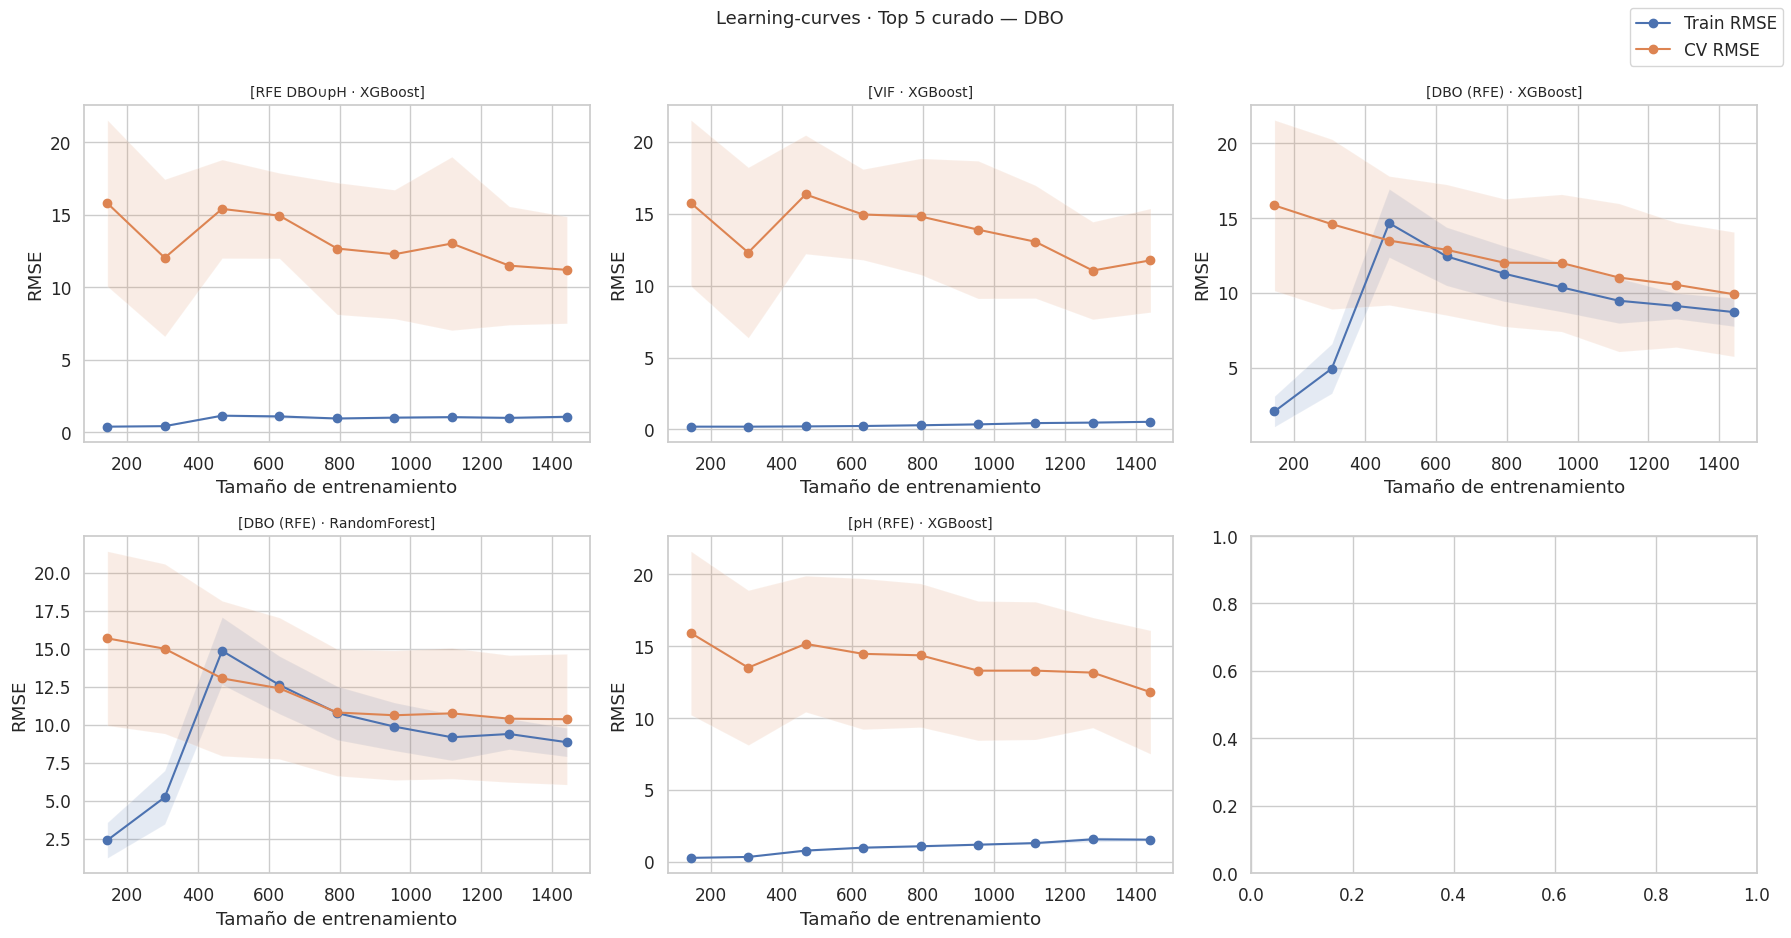


Top 5 curado ‚Äî pH:


escenario            modelo    info  GRI_RMSE        R2      RMSE  \
0    pH (RFE)           XGBoost  optuna  0.998531  0.252425  0.334540   
1         VIF      MLPRegressor    grid  0.994686  0.209546  0.344000   
2         VIF  LinearRegression    grid  0.990798  0.188789  0.348487   
3         VIF         SVR (RBF)    grid  1.029923  0.263676  0.332013   
4  RFE DBO‚à™pH         SVR (RBF)    grid  1.033283  0.196279  0.346875   

        MAE  
0  0.251188  
1  0.260501  
2  0.262555  
3  0.246778  
4  0.262573

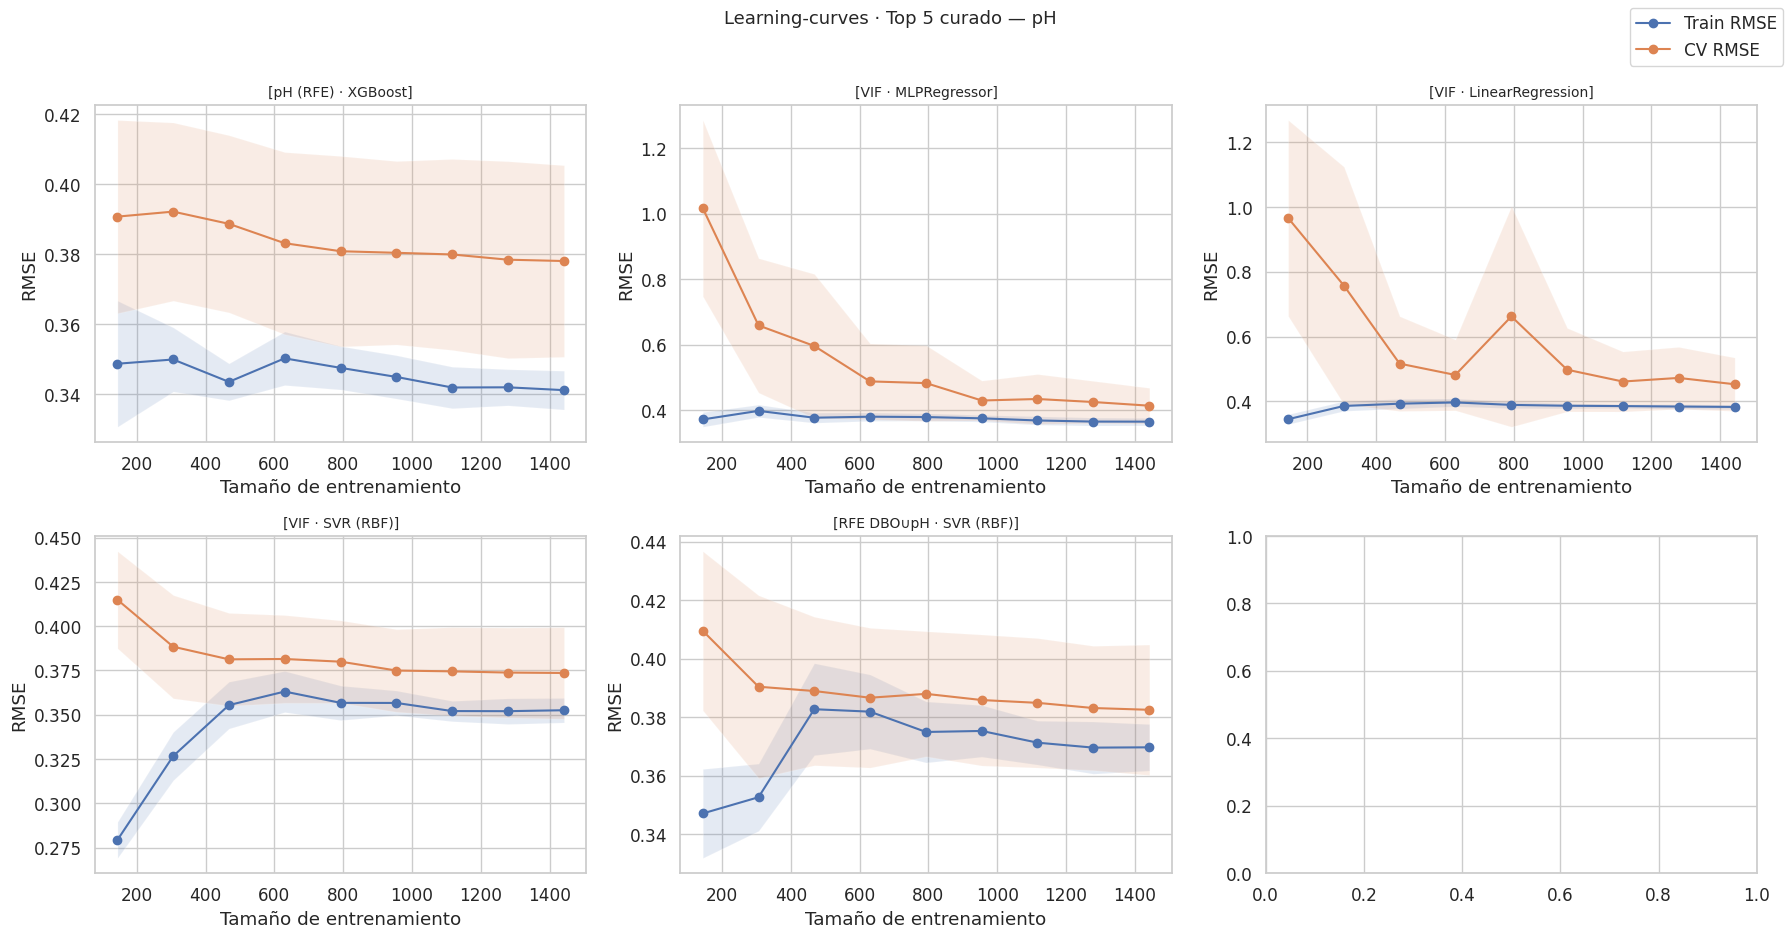

In [133]:
# LEARNING CURVES para el Top-5 CURADO (GRI‚âà1 + R¬≤ + RMSE)

assert 'artefactos' in globals(), "Faltan artefactos en memoria."
assert 'df_vif_filtered' in globals() and 'df_imputed' in globals(), "Faltan DF base."

# Silenciar advertencias ruidosas
import warnings
try:
    from sklearn.exceptions import ConvergenceWarning
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
except Exception:
    pass
warnings.filterwarnings("ignore")

from sklearn.model_selection import KFold, learning_curve
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

# Fuentes (modelos entrenados, splits y features por escenario)
src_models = artefactos.get('modelos_tuning_4esc', artefactos.get('modelos_entrenados_4esc'))
src_splits = artefactos.get('splits_tuning_4esc', artefactos.get('splits_fijos'))
esc_feats  = artefactos.get('escenarios_features', {})
rng = 42

# ---------------------------
# Carga de resultados y tipos
# ---------------------------
def _load_results_with_gri(artefactos):
    df = artefactos.get('tabla_resultados_final')
    if df is None:
        df = artefactos.get('tabla_tuning_4esc_gri')
    if df is None:
        df = artefactos.get('tabla_tuning_4esc')
    assert df is not None, "No encontr√© tabla de resultados en artefactos."
    df = df.copy()
    # A√±adir GRI_RMSE si hace falta
    if ('GRI_RMSE' not in df.columns) or df['GRI_RMSE'].isna().all():
        gri_det = artefactos.get('gri_final')
        if gri_det is not None:
            df = df.merge(
                gri_det[['objetivo','escenario','modelo','GRI_RMSE']],
                on=['objetivo','escenario','modelo'], how='left'
            )
    for c in ('GRI_RMSE','R2','RMSE','MAE'):
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')
    return df

df_all = _load_results_with_gri(artefactos)

# ---------------------------
# Alias DBO/pH y etiquetas
# ---------------------------
def _alias_obj(objetivo: str) -> str:
    s = str(objetivo)
    if ('DBO' in s.upper()) or ('DEMANDA' in s.upper()):
        return 'DBO'
    if 'PH' in s.upper():
        return 'pH'
    return s

_obj_names = set(map(str, df_all['objetivo'].dropna().unique()))
_dbo_long = next((s for s in _obj_names if ("DBO" in s.upper()) or ("DEMANDA" in s.upper())), None)
_ph_long  = next((s for s in _obj_names if "PH" in s.upper()), None)

def _alias_en_escenario(objetivo: str, escenario: str) -> str:
    s = str(escenario)
    if _dbo_long: s = s.replace(_dbo_long, "DBO")
    if _ph_long:  s = s.replace(_ph_long, "pH")
    return s

# ------------------------------------
# Canonicaci√≥n (splits / feature-sets)
# ------------------------------------
def _canon(s: str) -> str:
    if s is None: return ""
    t = str(s).lower()
    rep = {'√°':'a','√©':'e','√≠':'i','√≥':'o','√∫':'u','√±':'n','‚à™':'u','¬∑':' ','‚Äî':' ','‚Äì':'-'}
    for k,v in rep.items(): t = t.replace(k,v)
    t = (t.replace('uni√≥n','union')
           .replace('(', ' ').replace(')', ' ')
           .replace('[',' ').replace(']',' ')
           .replace('{',' ').replace('}',' '))
    t = re.sub(r'\s+', ' ', t).strip()
    keep = re.sub(r'[^a-z0-9]', '', t)
    if ('rfedbouph' in keep) or ('dbouph' in keep):
        keep = 'unionrfedbouph'
    return keep

_split_keys = { (_canon(k[0]), _canon(k[1])): k for k in src_splits.keys() }
_feat_keys  = { _canon(k): k for k in esc_feats.keys() }

def _find_split_key(obj, esc):
    key = (_canon(obj), _canon(esc))
    if key in _split_keys:
        return _split_keys[key]
    candidates = [orig for (co, ce), orig in _split_keys.items() if ce == key[1]]
    if len(candidates) == 1:
        return candidates[0]
    if not candidates:
        for (co, ce), orig in _split_keys.items():
            if key[1] in ce or ce in key[1]:
                return orig
    raise KeyError(f"No encuentro split can√≥nico para objetivo='{obj}', escenario='{esc}'")

def _find_feats_key(esc):
    c = _canon(esc)
    if c in _feat_keys: return _feat_keys[c]
    for k_can, k_orig in _feat_keys.items():
        if c in k_can or k_can in c:
            return k_orig
    if ('rfedbouph' in c) or ('dbouph' in c):
        for k_can, k_orig in _feat_keys.items():
            if 'unionrfedbouph' in k_can:
                return k_orig
    raise KeyError(f"No encuentro features para el escenario '{esc}'")

# ------------------------------------
# Reconstrucci√≥n X,y + split + modelo
# ------------------------------------
def _build_xy(obj, esc):
    if esc == "VIF":
        X = df_vif_filtered.select_dtypes(include='number').copy()
        if obj in X.columns:
            X = X.drop(columns=[obj])
    else:
        feats = esc_feats.get(esc, None)
        if feats is None:
            feats = esc_feats[_find_feats_key(esc)]
        cols = [c for c in feats if c in df_vif_filtered.columns]
        X = df_vif_filtered.loc[:, cols].copy()
    y = df_imputed.loc[X.index, obj].copy()
    m = y.notna()
    return X.loc[m], y.loc[m]

def _resolve_split(obj, esc, X, Y):
    k = _find_split_key(obj, esc)
    s = src_splits[k]
    if isinstance(s, (tuple, list)) and len(s)==2:
        idx_tr, idx_te = s
        return X.loc[idx_tr], X.loc[idx_te], Y.loc[idx_tr], Y.loc[idx_te]
    return s["X_train"], s["X_test"], s["y_train"], s["y_test"]

# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# FIX: desempaquetar el estimador real desde los artefactos si vienen
# como {'est': <modelo>, 'features': [...], ...}
def _get_trained_estimator(obj, esc, mdl_name):
    pack = src_models.get((obj, esc), None)
    if isinstance(pack, dict):
        rec = pack.get(mdl_name)
        if isinstance(rec, dict) and ('est' in rec):
            return rec['est']             # caso nuevo (dict con 'est')
        return rec                        # caso antiguo (ya es el modelo)
    # compatibilidad con estructura plana (obj, esc, mdl)
    return src_models.get((obj, esc, mdl_name))
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

# --------------------------------------
# Selecci√≥n Top-5 CURADO (misma l√≥gica)
# --------------------------------------
def _select_topk_curado(df_obj, k=5,
                        gri_range=(0.95, 1.60),
                        min_r2=0.60,
                        w_gri=0.50, w_r2=0.35, w_rmse=0.15,
                        allow_outlier_slot=True,
                        relax_steps=((0.90,1.75,0.55),
                                     (0.85,1.90,0.50),
                                     (0.80,2.10,0.45))):
    d = df_obj.copy().dropna(subset=['GRI_RMSE','R2','RMSE'])
    if d.empty:
        return d
    lo, hi = gri_range
    d_f = d[(d['GRI_RMSE'] >= lo) & (d['GRI_RMSE'] <= hi) & (d['R2'] >= min_r2)].copy()
    step_idx = 0
    while len(d_f) < min(k, len(d)) and step_idx < len(relax_steps):
        lo2, hi2, r2min2 = relax_steps[step_idx]
        d_f = d[(d['GRI_RMSE'] >= lo2) & (d['GRI_RMSE'] <= hi2) & (d['R2'] >= r2min2)].copy()
        step_idx += 1
    if len(d_f) == 0:
        d_f = d.copy()
    eps = 1e-9
    rmse_med = max(d_f['RMSE'].median(), eps)
    d_f['score_compuesto'] = (w_gri * (1.0 / (np.abs(d_f['GRI_RMSE'] - 1.0) + eps))
                              + w_r2 * d_f['R2']
                              - w_rmse * (d_f['RMSE'] / rmse_med))
    d_f = d_f.sort_values(['score_compuesto','GRI_RMSE','R2'],
                          ascending=[False, False, False]).head(k).copy()
    if allow_outlier_slot and len(d_f) < k:
        resto = d.drop(d_f.index, errors='ignore')
        if not resto.empty:
            outlier = resto.sort_values('RMSE', ascending=True).head(1)
            d_f = pd.concat([d_f, outlier], ignore_index=True)
    return d_f.sort_values('score_compuesto', ascending=False).head(k).reset_index(drop=True)

# ---------------------------------------------------
# Learning-curves para un Top-k dado (con protecci√≥n)
# ---------------------------------------------------
def learning_curves_para_topk(topk_df, objetivo:str, cv:int=5, puntos:int=9,
                              guarda:bool=False, fname:str=None):
    alias = _alias_obj(objetivo)
    n = len(topk_df)
    if n == 0:
        print(f"[Aviso] No hay candidatos para {alias}."); 
        return topk_df

    ncols = min(3, n)
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 4.6*nrows), squeeze=False)
    ax_iter = iter(axes.flat)

    for _, r in topk_df.iterrows():
        esc, mdl = r["escenario"], r["modelo"]
        ax = next(ax_iter)

        X, Y = _build_xy(objetivo, esc)
        X = X.sort_index(); Y = Y.loc[X.index]
        Xtr, Xte, ytr, yte = _resolve_split(objetivo, esc, X, Y)
        est = _get_trained_estimator(objetivo, esc, mdl)

        # Protecci√≥n extra por si llega como dict
        if isinstance(est, dict) and ('est' in est):
            est = est['est']

        sizes = np.linspace(0.1, 1.0, puntos)
        kf = KFold(n_splits=cv, shuffle=True, random_state=rng)
        ts, tr_scores, cv_scores = learning_curve(
            est, Xtr, ytr,
            train_sizes=sizes,
            cv=kf,
            scoring='neg_root_mean_squared_error',
            shuffle=False,
            n_jobs=1
        )
        tr_rmse = -tr_scores; cv_rmse = -cv_scores
        tr_mean, tr_std = tr_rmse.mean(axis=1), tr_rmse.std(axis=1)
        cv_mean, cv_std = cv_rmse.mean(axis=1), cv_rmse.std(axis=1)

        esc_corto = _alias_en_escenario(objetivo, esc)
        ax.plot(ts, tr_mean, marker='o', label='Train RMSE')
        ax.fill_between(ts, tr_mean-tr_std, tr_mean+tr_std, alpha=0.15)
        ax.plot(ts, cv_mean, marker='o', label='CV RMSE')
        ax.fill_between(ts, cv_mean-cv_std, cv_mean+cv_std, alpha=0.15)
        ax.set_title(f"[{esc_corto} ¬∑ {mdl}]", fontsize=10)
        ax.set_xlabel("Tama√±o de entrenamiento"); ax.set_ylabel("RMSE")

    handles, labels = axes[0,0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc="upper right")

    fig.suptitle(f"Learning-curves ¬∑ Top {n} curado ‚Äî {alias}", fontsize=13, y=1.02)
    plt.tight_layout()
    if guarda:
        if fname is None:
            fname = f"lc_top{n}_{alias}_curado.png"
        plt.savefig(fname, dpi=160, bbox_inches='tight')
    plt.show()
    return topk_df

# ---------------------------------------------------
# Orquestador: construye Top-5 curado y grafica
# ---------------------------------------------------
def learning_curves_top5_curado(objetivo:str, k:int=5, cv:int=5, puntos:int=9,
                                guarda:bool=False, fname:str=None):
    alias = _alias_obj(objetivo)
    d = df_all[df_all['objetivo'] == objetivo].copy()
    min_r2 = 0.60 if alias == 'DBO' else 0.15
    topk = _select_topk_curado(
        d, k=k, gri_range=(0.95, 1.60), min_r2=min_r2,
        w_gri=0.50, w_r2=0.35, w_rmse=0.15, allow_outlier_slot=True
    )
    cols = ['escenario','modelo','info','GRI_RMSE','R2','RMSE','MAE']
    print(f"\nTop {len(topk)} curado ‚Äî {alias}:")
    display(topk[[c for c in cols if c in topk.columns]])
    return learning_curves_para_topk(topk, objetivo, cv=cv, puntos=puntos,
                                     guarda=guarda, fname=fname)

# ----------------
# EJECUCI√ìN
# ----------------
objs = list(pd.Series(df_all['objetivo'].dropna().unique()))
dbo_obj = next((s for s in objs if ('DBO' in str(s)) or ('DEMANDA' in str(s))), None)
ph_obj  = next((s for s in objs if 'PH' in str(s).upper()), None)

if dbo_obj:
    _ = learning_curves_top5_curado(dbo_obj, k=5, cv=5, puntos=9)
else:
    print("[Aviso] No detect√© objetivo DBO en la tabla.")

if ph_obj:
    _ = learning_curves_top5_curado(ph_obj, k=5, cv=5, puntos=9)
else:
    print("[Aviso] No detect√© objetivo pH en la tabla.")



In [139]:
# ============================================================
# Selecci√≥n FINAL de modelos ganadores (para SHAP / PI)
# Prioriza R¬≤ dentro de un rango aceptable de GRI_RMSE
# ============================================================

import pandas as pd

# ------------------------------------------
# Par√°metros ajustables
# ------------------------------------------
GRI_MAX = 1.3      # l√≠mite superior de GRI aceptable
GRI_MIN = 0.80     # l√≠mite inferior de GRI aceptable
R2_MIN  = 0.10     # valor m√≠nimo razonable de R¬≤

# ------------------------------------------
# Cargar tabla de resultados
# ------------------------------------------
df_res = artefactos.get("tabla_resultados_final", None)
if df_res is None:
    df_res = artefactos.get("tabla_tuning_4esc_gri", None)
if df_res is None:
    raise ValueError("No se encontr√≥ tabla de resultados en artefactos.")

# Copia limpia
df = df_res.copy()
df = df.dropna(subset=["R2", "GRI_RMSE"]).reset_index(drop=True)

# ------------------------------------------
# Detecci√≥n de objetivos (DBO / pH)
# ------------------------------------------
objs = list(pd.Series(df["objetivo"].dropna().unique()))
dbo_obj = next((s for s in objs if ("DBO" in str(s).upper()) or ("DEMANDA" in str(s).upper())), None)
ph_obj  = next((s for s in objs if "PH" in str(s).upper()), None)

filas_finales = []

# ------------------------------------------
# Funci√≥n de selecci√≥n por objetivo
# ------------------------------------------
def seleccionar_mejor_modelo(df_obj, objetivo):
    """Selecciona el modelo con mayor R¬≤ dentro del rango de GRI aceptable."""
    d = df_obj.copy()
    d = d[(d["GRI_RMSE"] <= GRI_MAX) & (d["GRI_RMSE"] >= GRI_MIN) & (d["R2"] >= R2_MIN)]

    if d.empty:
        print(f"[Aviso] No hay modelos aceptables para {objetivo}.")
        return None

    # Prioridad: mayor R¬≤, luego GRI m√°s cercano a 1
    d["dist_gri"] = (d["GRI_RMSE"] - 1.0).abs()
    d = d.sort_values(["R2", "dist_gri"], ascending=[False, True])
    best = d.iloc[0]

    # Extracci√≥n de las variables reales usadas en el modelo
    obj, esc, mdl = best["objetivo"], best["escenario"], best["modelo"]
    modelos = artefactos.get("modelos_tuning_4esc", {})

    feats = []
    if (obj, esc) in modelos:
        pack = modelos[(obj, esc)]
        if mdl in pack:
            rec = pack[mdl]
            if isinstance(rec, dict) and "features" in rec:
                feats = rec["features"]
    if not feats:
        feats = artefactos.get("escenarios_features", {}).get(esc, [])

    best["n_features"] = len(feats)
    best["features"] = feats

    return best

# ------------------------------------------
# Selecci√≥n final para DBO y pH
# ------------------------------------------
if dbo_obj:
    best_dbo = seleccionar_mejor_modelo(df[df["objetivo"] == dbo_obj], dbo_obj)
    if best_dbo is not None:
        filas_finales.append(best_dbo)

if ph_obj:
    best_ph = seleccionar_mejor_modelo(df[df["objetivo"] == ph_obj], ph_obj)
    if best_ph is not None:
        filas_finales.append(best_ph)

# ------------------------------------------
# Tabla final con los modelos elegidos
# ------------------------------------------
tabla_modelos_finales = pd.DataFrame(
    filas_finales,
    columns=["objetivo", "escenario", "modelo", "info", "GRI_RMSE", "R2", "RMSE", "MAE", "n_features", "features"]
)

artefactos["tabla_modelos_finales"] = tabla_modelos_finales

# ------------------------------------------
# Mostrar resultados
# ------------------------------------------
print("\n=== MODELOS FINALES SELECCIONADOS ===")
display(tabla_modelos_finales)



=== MODELOS FINALES SELECCIONADOS ===


objetivo  \
11  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)   
44                                       pH   

                                        escenario        modelo    info  \
11  DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)  RandomForest    grid   
44                                            VIF       XGBoost  optuna   

    GRI_RMSE        R2      RMSE       MAE  n_features  \
11  1.259877  0.724872  5.551612  2.307435           5   
44  0.813107  0.397014  0.300451  0.218268          19   

                                             features  
11  [CALCIO (mg Ca/l), HIERRO TOTAL (mg Fe/l), TUR...  
44  [TEMPERATURA (¬∞C), COLOR (UPC), TURBIEDAD (UNT...


Calculando Permutation Importance para DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) ‚Äî RandomForest (DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE))...


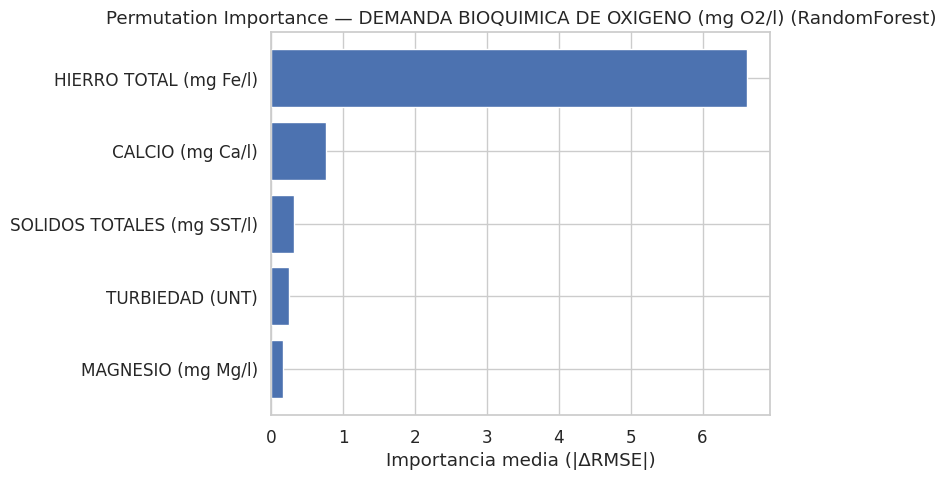


Calculando Permutation Importance para pH ‚Äî XGBoost (VIF)...


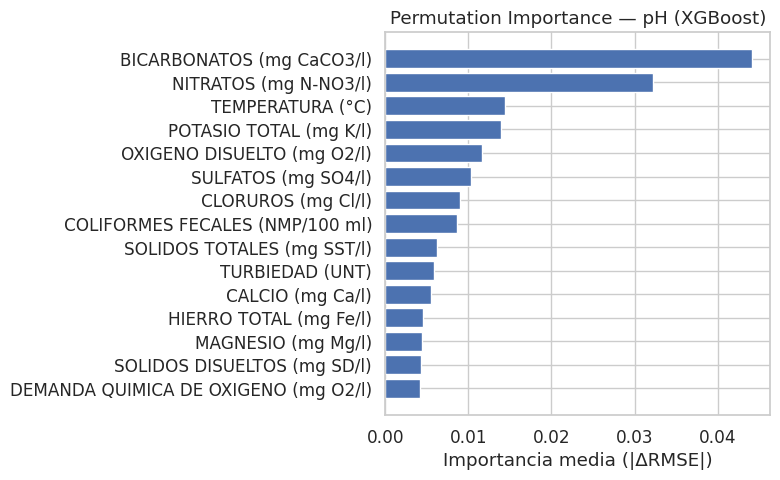


=== RESULTADOS DE PERMUTATION IMPORTANCE ===


feature  importance_mean  importance_std  \
0                 HIERRO TOTAL (mg Fe/l)         6.612693        0.120144   
1                       CALCIO (mg Ca/l)         0.759312        0.247593   
2             SOLIDOS TOTALES (mg SST/l)         0.321022        0.259544   
3                        TURBIEDAD (UNT)         0.247026        0.096119   
4                     MAGNESIO (mg Mg/l)         0.161040        0.122876   
5              BICARBONATOS (mg CaCO3/l)         0.044153        0.004476   
6                  NITRATOS (mg N-NO3/l)         0.032276        0.004209   
7                       TEMPERATURA (¬∞C)         0.014428        0.001445   
8                 POTASIO TOTAL (mg K/l)         0.013916        0.003936   
9             OXIGENO DISUELTO (mg O2/l)         0.011590        0.003914   
10                   SULFATOS (mg SO4/l)         0.010331        0.002727   
11                    CLORUROS (mg Cl/l)         0.008952        0.001808   
12       COLIFORMES FECALES (NMP/100 ml)         0.008578        0.001093   
13            SOLIDOS TOTALES (mg SST/l)         0.006200        0.001535   
14                       TURBIEDAD (UNT)         0.005854        0.001083   
15                      CALCIO (mg Ca/l)         0.005476        0.002135   
16                HIERRO TOTAL (mg Fe/l)         0.004535        0.001448   
17                    MAGNESIO (mg Mg/l)         0.004363        0.001094   
18           SOLIDOS DISUELTOS (mg SD/l)         0.004267        0.001688   
19  DEMANDA QUIMICA DE OXIGENO (mg O2/l)         0.004231        0.001129   

                                   objetivo  \
0   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)   
1   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)   
2   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)   
3   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)   
4   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)   
5                                        pH   
6                                        pH   
7                                        pH   
8                                        pH   
9                                        pH   
10                                       pH   
11                                       pH   
12                                       pH   
13                                       pH   
14                                       pH   
15                                       pH   
16                                       pH   
17                                       pH   
18                                       pH   
19                                       pH   

                                        escenario        modelo  
0   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)  RandomForest  
1   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)  RandomForest  
2   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)  RandomForest  
3   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)  RandomForest  
4   DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE)  RandomForest  
5                                             VIF       XGBoost  
6                                             VIF       XGBoost  
7                                             VIF       XGBoost  
8                                             VIF       XGBoost  
9                                             VIF       XGBoost  
10                                            VIF       XGBoost  
11                                            VIF       XGBoost  
12                                            VIF       XGBoost  
13                                            VIF       XGBoost  
14                                            VIF       XGBoost  
15                                            VIF       XGBoost  
16                                            VIF       XGBoost  
17                                            VIF       XGBoost  
18                                            VIF       XGBoost  
19                                            VIF       XGBoost

In [140]:
# ============================================================
# PERMUTATION IMPORTANCE (PI)
# Para los modelos ganadores almacenados en artefactos["tabla_modelos_finales"]
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

assert "tabla_modelos_finales" in artefactos, "Faltan modelos finales en artefactos."
assert "modelos_tuning_4esc" in artefactos, "Faltan modelos entrenados en artefactos."
assert "splits_tuning_4esc" in artefactos, "Faltan splits en artefactos."

df_final = artefactos["tabla_modelos_finales"].copy()
modelos_all = artefactos["modelos_tuning_4esc"]
splits_all = artefactos["splits_tuning_4esc"]

# ============================================================
# Funciones auxiliares
# ============================================================

def _get_split_indices(objetivo, escenario):
    """Recupera los √≠ndices de train/test del escenario y objetivo dado."""
    for k, v in splits_all.items():
        if isinstance(k, tuple) and len(k) == 2:
            if k[0] == objetivo and k[1] == escenario:
                return v
    raise KeyError(f"No se encontr√≥ split para ({objetivo}, {escenario}).")

def _get_modelo_entrenado(objetivo, escenario, modelo_nombre):
    """Obtiene el modelo entrenado desde artefactos."""
    pack = modelos_all.get((objetivo, escenario))
    if isinstance(pack, dict):
        rec = pack.get(modelo_nombre)
        if isinstance(rec, dict) and "est" in rec:
            return rec["est"]
        return rec
    return modelos_all.get((objetivo, escenario, modelo_nombre))

# ============================================================
# Ejecuci√≥n principal del Permutation Importance
# ============================================================

pi_resultados = []

for _, fila in df_final.iterrows():
    obj = fila["objetivo"]
    esc = fila["escenario"]
    mdl = fila["modelo"]
    feats = fila["features"]

    print(f"\nCalculando Permutation Importance para {obj} ‚Äî {mdl} ({esc})...")

    # Recuperar datos
    X_full = df_vif_filtered[feats].copy()
    y_full = df_imputed[obj].copy()
    idx_tr, idx_te = _get_split_indices(obj, esc)
    X_train, X_test = X_full.loc[idx_tr], X_full.loc[idx_te]
    y_train, y_test = y_full.loc[idx_tr], y_full.loc[idx_te]

    # Obtener el modelo entrenado
    est = _get_modelo_entrenado(obj, esc, mdl)
    assert est is not None, f"No se encontr√≥ el modelo para {obj} ‚Äî {mdl} ({esc})"

    # Calcular Permutation Importance (en test)
    r = permutation_importance(
        est, X_test, y_test,
        n_repeats=10,
        scoring="neg_root_mean_squared_error",
        random_state=42,
        n_jobs=1
    )

    # Armar DataFrame ordenado
    df_pi = pd.DataFrame({
        "feature": X_test.columns,
        "importance_mean": r.importances_mean,
        "importance_std": r.importances_std
    }).sort_values("importance_mean", ascending=False).reset_index(drop=True)

    df_pi["objetivo"] = obj
    df_pi["escenario"] = esc
    df_pi["modelo"] = mdl

    pi_resultados.append(df_pi)

    # Gr√°fico
    top_n = min(15, len(df_pi))
    plt.figure(figsize=(8, 5))
    plt.barh(df_pi["feature"].head(top_n)[::-1], df_pi["importance_mean"].head(top_n)[::-1])
    plt.xlabel("Importancia media (|ŒîRMSE|)")
    plt.title(f"Permutation Importance ‚Äî {obj} ({mdl})")
    plt.tight_layout()
    plt.show()

# ============================================================
# Consolidaci√≥n y guardado de resultados
# ============================================================
pi_final = pd.concat(pi_resultados, ignore_index=True)
artefactos["permutation_importance"] = pi_final

print("\n=== RESULTADOS DE PERMUTATION IMPORTANCE ===")
display(pi_final.head(20))



Calculando SHAP values para DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) ‚Äî RandomForest (DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l) (RFE))...
Mostrando gr√°fico tipo columnas (bar) para DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)...


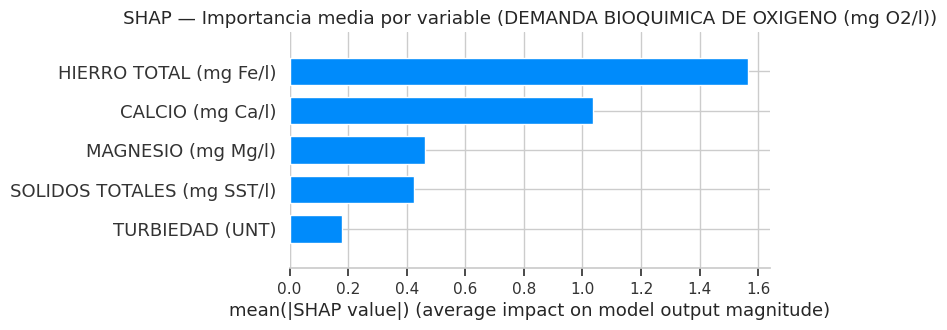

Mostrando gr√°fico tipo violin (dot plot) para DEMANDA BIOQUIMICA DE OXIGENO (mg O2/l)...


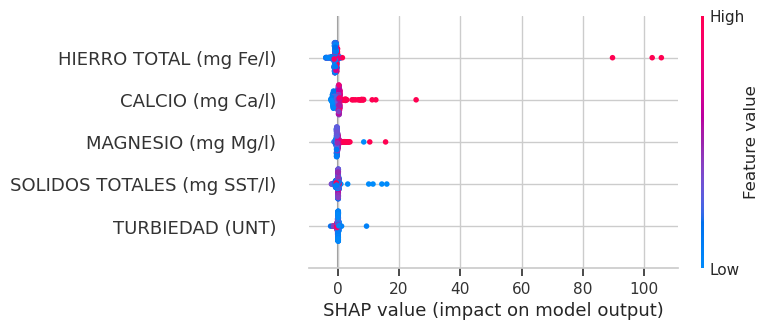


Calculando SHAP values para pH ‚Äî XGBoost (VIF)...


PermutationExplainer explainer: 452it [04:47,  1.54it/s]                         


Mostrando gr√°fico tipo columnas (bar) para pH...


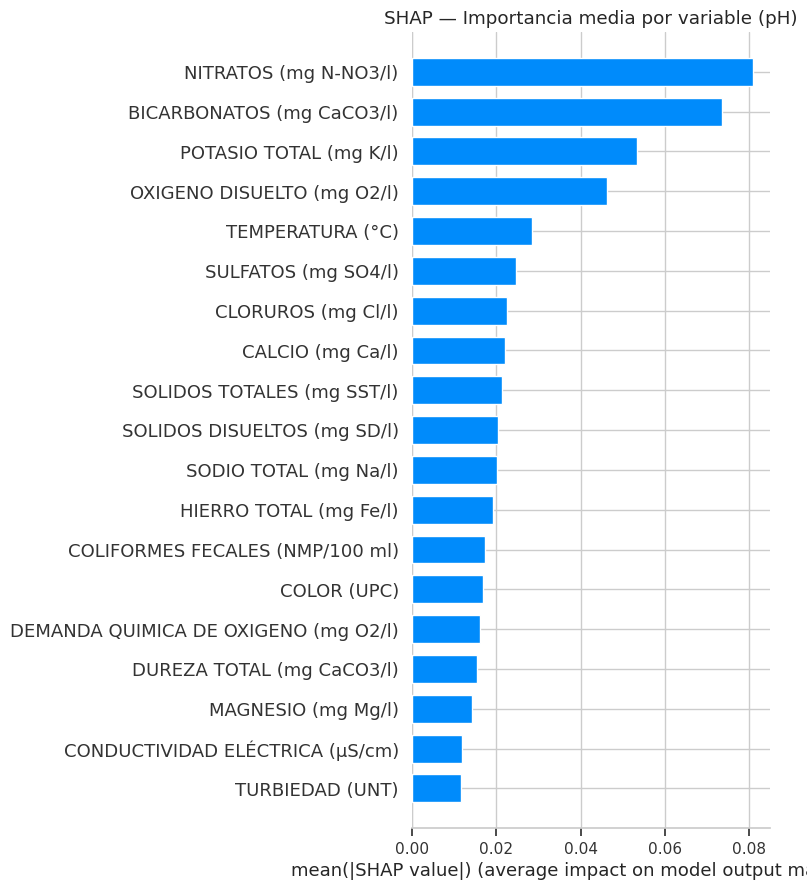

Mostrando gr√°fico tipo violin (dot plot) para pH...


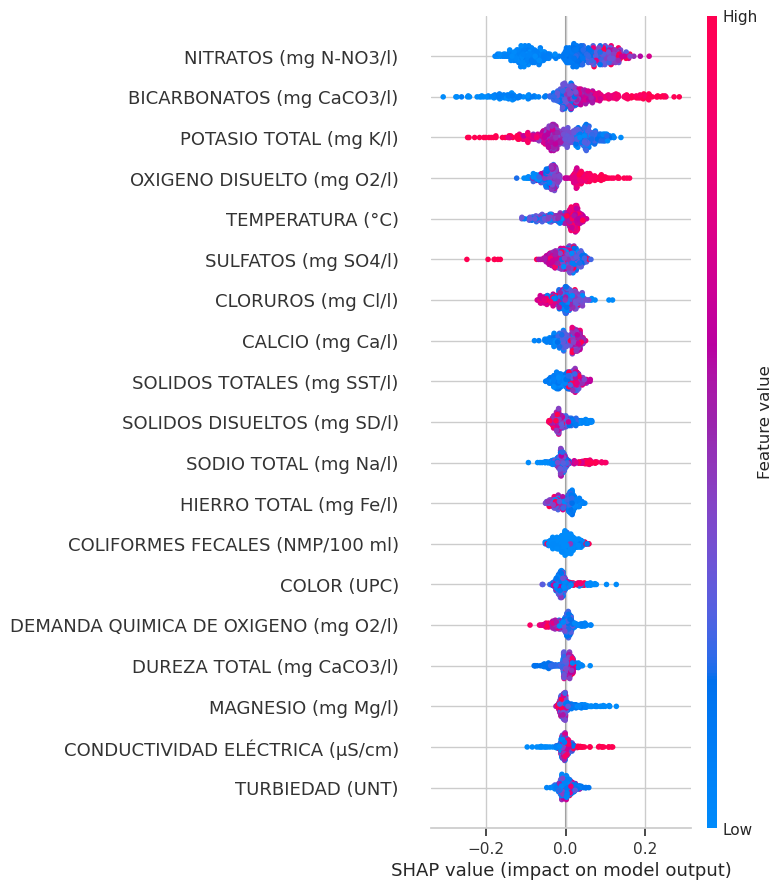


An√°lisis SHAP completado correctamente.


In [142]:
# ============================================================
# SHAP VALUES para los modelos finales seleccionados
# Versi√≥n corregida (compatible con XGBoost nuevos)
# Incluye gr√°ficos tipo columnas (bar) y violin (dot plot)
# ============================================================

import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Verificaciones previas
assert "tabla_modelos_finales" in artefactos, "Faltan modelos finales en artefactos."
assert "modelos_tuning_4esc" in artefactos, "Faltan modelos entrenados en artefactos."
assert "splits_tuning_4esc" in artefactos, "Faltan splits en artefactos."

df_final = artefactos["tabla_modelos_finales"].copy()
modelos_all = artefactos["modelos_tuning_4esc"]
splits_all = artefactos["splits_tuning_4esc"]

# ============================================================
# Funciones auxiliares
# ============================================================

def _get_split_indices(objetivo, escenario):
    for k, v in splits_all.items():
        if isinstance(k, tuple) and len(k) == 2:
            if k[0] == objetivo and k[1] == escenario:
                return v
    raise KeyError(f"No se encontr√≥ split para ({objetivo}, {escenario}).")

def _get_modelo_entrenado(objetivo, escenario, modelo_nombre):
    pack = modelos_all.get((objetivo, escenario))
    if isinstance(pack, dict):
        rec = pack.get(modelo_nombre)
        if isinstance(rec, dict) and "est" in rec:
            return rec["est"]
        return rec
    return modelos_all.get((objetivo, escenario, modelo_nombre))

# ============================================================
# C√°lculo SHAP con compatibilidad total
# ============================================================

shap_resultados = {}

for _, fila in df_final.iterrows():
    obj = fila["objetivo"]
    esc = fila["escenario"]
    mdl = fila["modelo"]
    feats = fila["features"]

    print(f"\nCalculando SHAP values para {obj} ‚Äî {mdl} ({esc})...")

    # Recuperar datos
    X_full = df_vif_filtered[feats].copy()
    y_full = df_imputed[obj].copy()
    idx_tr, idx_te = _get_split_indices(obj, esc)
    X_train, X_test = X_full.loc[idx_tr], X_full.loc[idx_te]
    y_train, y_test = y_full.loc[idx_tr], y_full.loc[idx_te]

    # Modelo entrenado
    est = _get_modelo_entrenado(obj, esc, mdl)
    assert est is not None, f"No se encontr√≥ el modelo para {obj} ‚Äî {mdl} ({esc})"

    # ========================================================
    # Determinar el tipo de explicador SHAP (seguro)
    # ========================================================
    try:
        if "RandomForest" in mdl:
            explainer = shap.TreeExplainer(est)
        elif "XGB" in mdl or "XGBoost" in mdl:
            # XGBoost moderno puede fallar con TreeExplainer, usamos el gen√©rico
            explainer = shap.Explainer(est.predict, X_train, feature_names=X_train.columns)
        else:
            explainer = shap.Explainer(est.predict, X_train, feature_names=X_train.columns)
    except Exception:
        # Si TreeExplainer falla, usa fallback gen√©rico
        explainer = shap.Explainer(est.predict, X_train, feature_names=X_train.columns)

    # Calcular valores SHAP en el conjunto de prueba
    shap_values = explainer(X_test)
    shap_resultados[obj] = {
        "explainer": explainer,
        "values": shap_values,
        "X_test": X_test,
        "y_test": y_test
    }

    # ============================================================
    # 1. Gr√°fico tipo COLUMNAS (bar)
    # ============================================================
    print(f"Mostrando gr√°fico tipo columnas (bar) para {obj}...")
    plt.title(f"SHAP ‚Äî Importancia media por variable ({obj})")
    shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
    plt.tight_layout()
    plt.show()

    # ============================================================
    # 2. Gr√°fico tipo VIOLIN (dot / beeswarm)
    # ============================================================
    print(f"Mostrando gr√°fico tipo violin (dot plot) para {obj}...")
    shap.summary_plot(shap_values, X_test, plot_type="dot", show=False)
    plt.tight_layout()
    plt.show()

# ============================================================
# Guardar resultados
# ============================================================
artefactos["shap_resultados"] = shap_resultados

print("\nAn√°lisis SHAP completado correctamente.")

